# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

**Estudiante**: Malena Núñez Martínez

**Datos del modelo final elegido**
* **MAE test (DrivenData):** 26,0120
* **MAE validación:** 19,8870 (San Juan)	7,5180 (Iquitos)
* **Algoritmo ML:** Random Forest
* **Hiperparámetros:**
  * San Juan: n_estimators=256; criterion='poisson'; max_depth=5; min_samples_split=2; min_samples_seaf=10
  * Iquitos: n_estimators=128; criterion='poisson'; max_depth=15; min_samples_split=3; min_samples_seaf=1
* **Lista de características:** 'year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c'
* **Resumen dataset (transformaciones, etc.):** El preprocesado realizado ha sido el mismo que el de la Actividad 1. En cuanto al dataset de 'train', se ha cargado el obtenido en la Actividad 1. Por su parte, el dataset de 'test' se ha tratado con los mismos algoritmos. En cuanto a la selección de características, se ha analizado tanto la matriz de correlación como la importancia de cada característica.

A continuación, se realiza un resumen más detallado de cada uno de los pasos seguidos.

#### NOTA IMPORTANTE

La líneas de código utilizadas para realizar las descargas de las predicciones están comentadas.

---
# Resumen
---

El dengue es una enfermedad transmitida por mosquitos que se da en zonas tropicales y subtropicales del mundo. En casos graves, la enfermedad puede causar hemorragias graves, hipertensión arterial e incluso la muerte.

Al ser transmitido por mosquitos, la dinámica de transmisión del dengue está relacionada con variables climáticas como la temperatura, precipitaciones y humedad.

Por otro lado, a raíz del cambio climático, cada vez más científicos sostienen que es probable que se produzcan cambios en la distribución del dengue, lo cual tendrá importantes consecuencias en la salud pública de todo el mundo.

El **objetivo** principal de la actividad es predecir el número de casos de dengue registrados cada semana en las ciudades de San Juan (Puerto Rico) e Inquitos (Perú).

La comprensión entre el clima y la dinámica del dengue puede mejorar la investigación y la asignación de recursos para ayudar a combatir posibles pandemias potencialmente mortales.

**Datos**  
Los datos de vigilancia del dengue proceden de los Centros para el Control y la Prevención de Enfermedades de EE.UU., así como de la Unidad 6 de Investigación Médica Naval del Departamento de Defensa y del Centro de Vigilancia Sanitaria de las Fuerzas Armadas, en colaboración con el gobierno peruano y universidades estadounidenses. Los datos medioambientales y climáticos proceden de la Administración Nacional Oceánica y Atmosférica (NOAA), una agencia del Departamento de Comercio estadounidense.

**Fases**  
La actividad se ha dividido en las siguientes fases:
1. **Inicialización:** En este apartado se han cargado los conjuntos de 'train' y de 'test'. Como en la Actividad 1 se eliminaron algunos registros considerados *outliers* se ha tratado el dataset *train_labels* para quedarnos, únicamente, con los registros finales.
2. **Preprocesado:** En esta fase se ha realizado la limpieza de los datos (discretización, valores perdidos, outliers, ...) del dataset 'test'.
3. **Características:** Aquí es donde se han normalizado los conjuntos de datos siguiendo el mismo enfoque utilizado en la Actividad 1. También se ha realizado la selección de características mediante el algoritmo *'RandomForestRegressor'*.
4. **Predicción:** Utilizando distintos algoritmos de aprendizaje supervisado, se han parametrizado, construido y ejecutado distintos modelos de predicción. Una vez obtenido el resultado de cada validación mediante MAE, se ha elegido el modelo más preciso, esto es, el modelo que ha obtenido el menor MAE.
5. **Conclusiones:** Se han presentado los resultados, se han analizado y se han planteado posibles mejoras. En este caso, el mejor resultado se ha obtenido con el algoritmo Random Forest y realizando el análisis con la división del dataset por ciudades (San Juan e Iquitos).
6. **Competición**


---
# Inicialización
---

In [1]:
# Imports generales
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets
import statsmodels.api as sm # Biblioteca de Python que se utiliza para realizar análisis estadísticos y estimaciones econométricas


import time

# Función para subir archivos desde el sistema local de archivos

import io # herramientas para el manejo de E/S (entrada/salida)
from google.colab import files

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

#Subir arhivos desde drive
from google.colab import drive
drive.mount('/content/drive')

#Función para descargar los resultados
def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

Mounted at /content/drive


En los siguientes códigos se realizará la subida de archivos:
* Test Data Features: dengue_features_test
* Training Data Features: Se utilizará el dataset procesado en la actividad 1 'df_a1' en vez de 'denge_features_train'
* Training Data Labels: denge_labels_train

En cuanto a la subida de archivos, estos se van a importar desde Google Drive

NOTA: En el dataset tratado sj=1 (San Juan) y iq=0 (Iquitos)

In [2]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)

train_feat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/07 Machine Learning/Práctica 2/df_a1.csv')
print(train_feat.shape)
train_feat.head()

#train_feat = upload_files()
#print(train_feat.shape)
#train_feat.head()

(1368, 19)


year  weekofyear  city_bin   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  1990          18         1 -0.062977 -0.204344 -0.035307 -0.273059   
1  1990          19         1  0.293274  0.128725 -0.542414 -0.553103   
2  1990          20         1 -0.743468  0.395455 -0.614805 -0.358774   
3  1990          21         1 -0.017536  1.020014  0.372806  0.464274   
4  1990          22         1  0.491358  1.168430  0.704684  0.609216   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0             -0.824201              -0.871164                    -2.038997   
1             -0.564646              -0.393079                    -0.970438   
2             -0.272148               0.033667                     0.060384   
3             -0.750827               0.187681                    -0.026015   
4             -0.946492               0.585549                     0.329510   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                  -1.144473                   0.016175   
1                  -0.788243                   0.220947   
2                  -0.917781                   0.589537   
3                  -0.626320                   0.466674   
4                  -0.464397                   0.671446   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                        -0.182188                             -1.294711   
1                        -0.635171                             -0.723000   
2                        -0.372273                             -0.053964   
3                        -0.765331                             -0.299012   
4                        -0.820101                             -0.281465   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           -1.456516                -0.552083           -1.636456   
1           -0.418112                -0.810260           -0.402893   
2           -0.418112                -0.754438           -0.134727   
3            0.200263                -0.614882            0.455237   
4            1.402012                 0.655069            1.367001   

   station_min_temp_c  station_precip_mm  
0           -1.501300          -0.576010  
1           -0.002582          -0.790838  
2            0.406159           0.161373  
3            0.746777          -0.924380  
4            1.155518          -0.872124

In [3]:
# Subir el conjunto de entrenamiento SIN NORMALIZAR sin variable objetivo (dengue_features_train.csv)

train_feat_noNorm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/07 Machine Learning/Práctica 2/df_noNorm_a1.csv')
print(train_feat_noNorm.shape)
train_feat_noNorm.head()

(1368, 19)


year  weekofyear  city_bin   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  1990          18         1  0.122600  0.103725  0.198483  0.177617   
1  1990          19         1  0.169900  0.142175  0.162357  0.155486   
2  1990          20         1  0.032250  0.172967  0.157200  0.170843   
3  1990          21         1  0.128633  0.245067  0.227557  0.235886   
4  1990          22         1  0.196200  0.262200  0.251200  0.247340   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0                 12.42             297.572857                   292.414286   
1                 22.82             298.211429                   293.951429   
2                 34.54             298.781429                   295.434286   
3                 15.36             298.987143                   295.310000   
4                  7.52             299.518571                   295.821429   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                      299.8                      295.9   
1                      300.9                      296.4   
2                      300.5                      297.3   
3                      301.4                      297.0   
4                      301.9                      297.5   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   
3                            13.90                             80.337143   
4                            12.20                             80.460000   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           25.442857                 6.900000                29.4   
1           26.714286                 6.371429                31.7   
2           26.714286                 6.485714                32.2   
3           27.471429                 6.771429                33.3   
4           28.942857                 9.371429                35.0   

   station_min_temp_c  station_precip_mm  
0                20.0               16.0  
1                22.2                8.6  
2                22.8               41.4  
3                23.3                4.0  
4                23.9                5.8

In [4]:
# Subir el conjunto de entrenamiento SIN TRATAR sin variable objetivo (dengue_features_train.csv)

train_feat_V1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/07 Machine Learning/Práctica 2/dengue_features_train.csv')
print(train_feat.shape)
train_feat.head()

(1368, 19)


year  weekofyear  city_bin   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  1990          18         1 -0.062977 -0.204344 -0.035307 -0.273059   
1  1990          19         1  0.293274  0.128725 -0.542414 -0.553103   
2  1990          20         1 -0.743468  0.395455 -0.614805 -0.358774   
3  1990          21         1 -0.017536  1.020014  0.372806  0.464274   
4  1990          22         1  0.491358  1.168430  0.704684  0.609216   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0             -0.824201              -0.871164                    -2.038997   
1             -0.564646              -0.393079                    -0.970438   
2             -0.272148               0.033667                     0.060384   
3             -0.750827               0.187681                    -0.026015   
4             -0.946492               0.585549                     0.329510   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                  -1.144473                   0.016175   
1                  -0.788243                   0.220947   
2                  -0.917781                   0.589537   
3                  -0.626320                   0.466674   
4                  -0.464397                   0.671446   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                        -0.182188                             -1.294711   
1                        -0.635171                             -0.723000   
2                        -0.372273                             -0.053964   
3                        -0.765331                             -0.299012   
4                        -0.820101                             -0.281465   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           -1.456516                -0.552083           -1.636456   
1           -0.418112                -0.810260           -0.402893   
2           -0.418112                -0.754438           -0.134727   
3            0.200263                -0.614882            0.455237   
4            1.402012                 0.655069            1.367001   

   station_min_temp_c  station_precip_mm  
0           -1.501300          -0.576010  
1           -0.002582          -0.790838  
2            0.406159           0.161373  
3            0.746777          -0.924380  
4            1.155518          -0.872124

In [5]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/07 Machine Learning/Práctica 2/dengue_labels_train.csv')
print(train_labels.shape)
train_labels.head()

(1456, 4)


city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4
3   sj  1990          21            3
4   sj  1990          22            6

Para poder unificar el conjunto de entrenamiento, es necesario eliminar del dataset 'train_labels' las filas que fueron eliminadas en la actividad 1 de 07MBID.

Primero, se va a discretizar la variable categórica 'city' de dataset 'train_labels'. Una vez categorizada, se comprobará que líneas no existen en el dataset 'train_feat', mediante las variables 'city', 'year', 'weekofyear'.

In [6]:
# Discretización de la variable 'city'

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer() #Convertir variables categóricas o de etiquetas en una representación binaria
train_labels['city_bin'] = lb.fit_transform(train_labels['city'])
train_labels.drop("city", axis = 1, inplace = True)

In [7]:
train_labels.head()

year  weekofyear  total_cases  city_bin
0  1990          18            4         1
1  1990          19            5         1
2  1990          20            4         1
3  1990          21            3         1
4  1990          22            6         1

In [8]:
# Para poder hacer la comparación, se establecen los índices de ambos DataFrames usando las columnas 'city_bin', 'year' y 'weekofyear'
# Luego, compararemos si los índices de 'train_labels' no están presentes en 'train_feat'
train_feat.set_index(['city_bin', 'year', 'weekofyear'], inplace = True)
train_labels.set_index(['city_bin', 'year', 'weekofyear'], inplace = True)

# Identificar las filas que deben eliminarse
df_bool = train_labels.index.isin(train_feat.index)
df_bool_rev = ~(df_bool)
filas_a_eliminar = train_labels[df_bool_rev]

#Eliminar las filas
train_labels.drop(filas_a_eliminar.index, inplace=True)

print(train_labels.shape)
print(train_feat.shape)

# isin() --> Comparamos las combinaciones de valores entre ambos DataFrames. Esta función devolverá un DataFrame booleano
# ~ --> Revierte el resultado: True <--> False
# .all(axis='columns') --> Comprobamos si todos los valores de la fila (por lo tanto, de las tres variables) son True. Esto quiere decir que las combinaciones coinciden
# Como hemos invertido False por True, en este caso se seleccionarán filas que NO COINCIDEN (eran False y ahora son True)

(1368, 1)
(1368, 16)


In [9]:
train_feat.reset_index(inplace = True)
train_labels.reset_index(inplace = True)

In [10]:
train_feat.head()

city_bin  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0         1  1990          18 -0.062977 -0.204344 -0.035307 -0.273059   
1         1  1990          19  0.293274  0.128725 -0.542414 -0.553103   
2         1  1990          20 -0.743468  0.395455 -0.614805 -0.358774   
3         1  1990          21 -0.017536  1.020014  0.372806  0.464274   
4         1  1990          22  0.491358  1.168430  0.704684  0.609216   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0             -0.824201              -0.871164                    -2.038997   
1             -0.564646              -0.393079                    -0.970438   
2             -0.272148               0.033667                     0.060384   
3             -0.750827               0.187681                    -0.026015   
4             -0.946492               0.585549                     0.329510   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                  -1.144473                   0.016175   
1                  -0.788243                   0.220947   
2                  -0.917781                   0.589537   
3                  -0.626320                   0.466674   
4                  -0.464397                   0.671446   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                        -0.182188                             -1.294711   
1                        -0.635171                             -0.723000   
2                        -0.372273                             -0.053964   
3                        -0.765331                             -0.299012   
4                        -0.820101                             -0.281465   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           -1.456516                -0.552083           -1.636456   
1           -0.418112                -0.810260           -0.402893   
2           -0.418112                -0.754438           -0.134727   
3            0.200263                -0.614882            0.455237   
4            1.402012                 0.655069            1.367001   

   station_min_temp_c  station_precip_mm  
0           -1.501300          -0.576010  
1           -0.002582          -0.790838  
2            0.406159           0.161373  
3            0.746777          -0.924380  
4            1.155518          -0.872124

In [11]:
train_labels.head()

city_bin  year  weekofyear  total_cases
0         1  1990          18            4
1         1  1990          19            5
2         1  1990          20            4
3         1  1990          21            3
4         1  1990          22            6

In [12]:
print(filas_a_eliminar.shape)

(88, 1)


In [13]:
# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city_bin', 'year', 'weekofyear'])
print(train.shape)
train.head()

(1368, 20)


city_bin  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0         1  1990          18 -0.062977 -0.204344 -0.035307 -0.273059   
1         1  1990          19  0.293274  0.128725 -0.542414 -0.553103   
2         1  1990          20 -0.743468  0.395455 -0.614805 -0.358774   
3         1  1990          21 -0.017536  1.020014  0.372806  0.464274   
4         1  1990          22  0.491358  1.168430  0.704684  0.609216   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0             -0.824201              -0.871164                    -2.038997   
1             -0.564646              -0.393079                    -0.970438   
2             -0.272148               0.033667                     0.060384   
3             -0.750827               0.187681                    -0.026015   
4             -0.946492               0.585549                     0.329510   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                  -1.144473                   0.016175   
1                  -0.788243                   0.220947   
2                  -0.917781                   0.589537   
3                  -0.626320                   0.466674   
4                  -0.464397                   0.671446   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                        -0.182188                             -1.294711   
1                        -0.635171                             -0.723000   
2                        -0.372273                             -0.053964   
3                        -0.765331                             -0.299012   
4                        -0.820101                             -0.281465   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           -1.456516                -0.552083           -1.636456   
1           -0.418112                -0.810260           -0.402893   
2           -0.418112                -0.754438           -0.134727   
3            0.200263                -0.614882            0.455237   
4            1.402012                 0.655069            1.367001   

   station_min_temp_c  station_precip_mm  total_cases  
0           -1.501300          -0.576010            4  
1           -0.002582          -0.790838            5  
2            0.406159           0.161373            4  
3            0.746777          -0.924380            3  
4            1.155518          -0.872124            6

In [14]:
# Unificar el conjunto de entrenamiento (características SIN NORMALIZAR + variable objetivo)
train_noNorm = pd.merge(train_feat_noNorm,train_labels,on=['city_bin', 'year', 'weekofyear'])
print(train_noNorm.shape)
train.head()

(1368, 20)


city_bin  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0         1  1990          18 -0.062977 -0.204344 -0.035307 -0.273059   
1         1  1990          19  0.293274  0.128725 -0.542414 -0.553103   
2         1  1990          20 -0.743468  0.395455 -0.614805 -0.358774   
3         1  1990          21 -0.017536  1.020014  0.372806  0.464274   
4         1  1990          22  0.491358  1.168430  0.704684  0.609216   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0             -0.824201              -0.871164                    -2.038997   
1             -0.564646              -0.393079                    -0.970438   
2             -0.272148               0.033667                     0.060384   
3             -0.750827               0.187681                    -0.026015   
4             -0.946492               0.585549                     0.329510   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                  -1.144473                   0.016175   
1                  -0.788243                   0.220947   
2                  -0.917781                   0.589537   
3                  -0.626320                   0.466674   
4                  -0.464397                   0.671446   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                        -0.182188                             -1.294711   
1                        -0.635171                             -0.723000   
2                        -0.372273                             -0.053964   
3                        -0.765331                             -0.299012   
4                        -0.820101                             -0.281465   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           -1.456516                -0.552083           -1.636456   
1           -0.418112                -0.810260           -0.402893   
2           -0.418112                -0.754438           -0.134727   
3            0.200263                -0.614882            0.455237   
4            1.402012                 0.655069            1.367001   

   station_min_temp_c  station_precip_mm  total_cases  
0           -1.501300          -0.576010            4  
1           -0.002582          -0.790838            5  
2            0.406159           0.161373            4  
3            0.746777          -0.924380            3  
4            1.155518          -0.872124            6

In [15]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/07 Machine Learning/Práctica 2/dengue_features_test.csv')
print(test.shape)
test.columns

(416, 24)


Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [16]:
test.head()

city  year  weekofyear week_start_date  ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  2008          18      2008-04-29  -0.0189 -0.018900  0.102729   
1   sj  2008          19      2008-05-06  -0.0180 -0.012400  0.082043   
2   sj  2008          20      2008-05-13  -0.0015       NaN  0.151083   
3   sj  2008          21      2008-05-20      NaN -0.019867  0.124329   
4   sj  2008          22      2008-05-27   0.0568  0.039833  0.062267   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.091200                 78.60             298.492857  ...   
1  0.072314                 12.56             298.475714  ...   
2  0.091529                  3.66             299.455714  ...   
3  0.125686                  0.00             299.690000  ...   
4  0.075914                  0.76             299.780000  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            25.37                             78.781429   
1                            21.83                             78.230000   
2                             4.12                             78.270000   
3                             2.20                             73.015714   
4                             4.36                             74.084286   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         78.60                              15.918571   
1                         12.56                              15.791429   
2                          3.66                              16.674286   
3                          0.00                              15.775714   
4                          0.76                              16.137143   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           3.128571           26.528571                 7.057143   
1           2.571429           26.071429                 5.557143   
2           4.428571           27.928571                 7.785714   
3           4.342857           28.057143                 6.271429   
4           3.542857           27.614286                 7.085714   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                33.3                21.7               75.2  
1                30.0                22.2               34.3  
2                32.8                22.8                3.0  
3                33.3                24.4                0.3  
4                33.3                23.3               84.1  

[5 rows x 24 columns]

---
# Preprocesado
---

El dataset contiene datos de las ciudades San Juan (Puerto Rico) e Iquitos (Peru). Las ciudades están separadas por 2589km. Además, San Juan está en una isla del Mar Caribe, mientras que Iquitos está en América del Sur, cerca del Ecuador.

Por lo tanto, aunque ambas ciudades tengan un clima Tropical (ecuatorial lluvioso), como las localizaciones son diferentes, se ha decidido **separar el dataset de entrenamiento en dos**. La propagación del dengue puede seguir patrones diferentes entre las dos ciudades y, de esta manera, es posible estudiar las dos.

Antes de hacer la presentación final, se unirán ambas predicciones.

In [17]:
# Dividir los datos de San Juan (sj=1)
sj_train = train[train['city_bin'] == 1].copy()
sj_train_noNorm = train_noNorm[train_noNorm['city_bin'] == 1].copy()

#Dividir datos de Iquitos
iq_train = train[train['city_bin'] == 0].copy()
iq_train_noNorm = train_noNorm[train_noNorm['city_bin'] == 0].copy()

In [18]:
# Se resetean los índices para que no haya problemas en un futuro
sj_train.reset_index(drop=True, inplace=True)
iq_train.reset_index(drop=True, inplace=True)

In [19]:
print("San Juan: características y etiquetas")
print(sj_train.shape)
sj_train.head()

San Juan: características y etiquetas
(902, 20)


city_bin  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0         1  1990          18 -0.062977 -0.204344 -0.035307 -0.273059   
1         1  1990          19  0.293274  0.128725 -0.542414 -0.553103   
2         1  1990          20 -0.743468  0.395455 -0.614805 -0.358774   
3         1  1990          21 -0.017536  1.020014  0.372806  0.464274   
4         1  1990          22  0.491358  1.168430  0.704684  0.609216   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0             -0.824201              -0.871164                    -2.038997   
1             -0.564646              -0.393079                    -0.970438   
2             -0.272148               0.033667                     0.060384   
3             -0.750827               0.187681                    -0.026015   
4             -0.946492               0.585549                     0.329510   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                  -1.144473                   0.016175   
1                  -0.788243                   0.220947   
2                  -0.917781                   0.589537   
3                  -0.626320                   0.466674   
4                  -0.464397                   0.671446   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                        -0.182188                             -1.294711   
1                        -0.635171                             -0.723000   
2                        -0.372273                             -0.053964   
3                        -0.765331                             -0.299012   
4                        -0.820101                             -0.281465   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           -1.456516                -0.552083           -1.636456   
1           -0.418112                -0.810260           -0.402893   
2           -0.418112                -0.754438           -0.134727   
3            0.200263                -0.614882            0.455237   
4            1.402012                 0.655069            1.367001   

   station_min_temp_c  station_precip_mm  total_cases  
0           -1.501300          -0.576010            4  
1           -0.002582          -0.790838            5  
2            0.406159           0.161373            4  
3            0.746777          -0.924380            3  
4            1.155518          -0.872124            6

In [20]:
print("San Juan SIN NORMALIZAR: características y etiquetas")
print(sj_train_noNorm.shape)
sj_train_noNorm.head()

San Juan SIN NORMALIZAR: características y etiquetas
(902, 20)


year  weekofyear  city_bin   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  1990          18         1  0.122600  0.103725  0.198483  0.177617   
1  1990          19         1  0.169900  0.142175  0.162357  0.155486   
2  1990          20         1  0.032250  0.172967  0.157200  0.170843   
3  1990          21         1  0.128633  0.245067  0.227557  0.235886   
4  1990          22         1  0.196200  0.262200  0.251200  0.247340   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0                 12.42             297.572857                   292.414286   
1                 22.82             298.211429                   293.951429   
2                 34.54             298.781429                   295.434286   
3                 15.36             298.987143                   295.310000   
4                  7.52             299.518571                   295.821429   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                      299.8                      295.9   
1                      300.9                      296.4   
2                      300.5                      297.3   
3                      301.4                      297.0   
4                      301.9                      297.5   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   
3                            13.90                             80.337143   
4                            12.20                             80.460000   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           25.442857                 6.900000                29.4   
1           26.714286                 6.371429                31.7   
2           26.714286                 6.485714                32.2   
3           27.471429                 6.771429                33.3   
4           28.942857                 9.371429                35.0   

   station_min_temp_c  station_precip_mm  total_cases  
0                20.0               16.0            4  
1                22.2                8.6            5  
2                22.8               41.4            4  
3                23.3                4.0            3  
4                23.9                5.8            6

In [21]:
print("Iquitos: características y etiquetas")
print(iq_train.shape)
iq_train.head()

Iquitos: características y etiquetas
(466, 20)


city_bin  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0         0  2000          26  0.466396  0.042813  1.963612  0.607445   
1         0  2000          27  0.646762  1.288837  1.241703  0.537305   
2         0  2000          28  0.344920  0.396858  0.043736 -0.900725   
3         0  2000          30  1.488882  1.687555  0.749201  2.048007   
4         0  2000          32  1.367190  1.755616  2.520885  2.379901   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
0             -0.500007              -1.494705                    -0.113406   
1              0.378487              -1.573851                     0.007750   
2              0.251455              -1.737491                     0.191471   
3              0.432146              -1.724656                    -0.966466   
4              1.096257              -1.060472                    -1.060809   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                   1.284370                  -1.130551   
1                   1.057678                  -1.949640   
2                   0.377602                  -1.335323   
3                   1.187216                  -1.785822   
4                   1.770138                  -1.540095   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                         0.178329                              1.426526   
1                         0.268861                              1.592612   
2                         0.873590                              1.916418   
3                        -0.188632                              0.818497   
4                        -0.353587                              0.120691   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           -0.674796                 1.340634            0.026172   
1           -0.266435                 1.727318            0.830670   
2           -0.348107                 1.678474            0.294338   
3           -0.511452                 1.684986            0.455237   
4           -0.171151                 1.768021            0.830670   

   station_min_temp_c  station_precip_mm  total_cases  
0           -1.024436          -0.953411            0  
1           -0.956312           0.573610            0  
2           -1.024436           0.065571            0  
3           -2.114412          -0.924380            0  
4           -1.569424           1.075843            0

In [22]:
print("Iquitos SIN NORMALIZAR: características y etiquetas")
print(iq_train_noNorm.shape)
iq_train_noNorm.head()

Iquitos SIN NORMALIZAR: características y etiquetas
(466, 20)


year  weekofyear  city_bin   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
902  2000          26         0  0.192886  0.132257  0.340886  0.247200   
903  2000          27         0  0.216833  0.276100  0.289457  0.241657   
904  2000          28         0  0.176757  0.173129  0.204114  0.128014   
905  2000          30         0  0.328643  0.322129  0.254371  0.361043   
906  2000          32         0  0.312486  0.329986  0.380586  0.387271   

     precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
902                 25.41             296.740000                   295.184286   
903                 60.61             296.634286                   295.358571   
904                 55.52             296.415714                   295.622857   
905                 62.76             296.432857                   293.957143   
906                 89.37             297.320000                   293.821429   

     reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
902                      307.3                      293.1   
903                      306.6                      291.1   
904                      304.5                      292.6   
905                      307.0                      291.5   
906                      308.8                      292.1   

     reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
902                            43.19                             92.418571   
903                            46.00                             93.581429   
904                            64.77                             95.848571   
905                            31.80                             88.161429   
906                            26.68                             83.275714   

     station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
902           26.400000                10.775000                32.5   
903           26.900000                11.566667                34.0   
904           26.800000                11.466667                33.0   
905           26.600000                11.480000                33.3   
906           27.016667                11.650000                34.0   

     station_min_temp_c  station_precip_mm  total_cases  
902                20.7                3.0            0  
903                20.8               55.6            0  
904                20.7               38.1            0  
905                19.1                4.0            0  
906                19.9               72.9            0

Tal y como se observó en la Actividad 1, predominan las variables climáticas. Asimismo, al igual que se realizó en la Actividad 1, se va a **eliminar la variable 'week_start_date'** del DataFrame 'test', ya que no se debe utilizar como característica del modelo. Por último, también se va a **discretizar la variable 'city'** del DataFrame 'test'.


In [23]:
# Eliminar variable week_start_date por ser de tipo cadena de texto sin formato
test.drop("week_start_date", axis = 1, inplace = True)

In [24]:
# Discretizar la varaible 'city'
lb = preprocessing.LabelBinarizer() #Convertir variables categóricas o de etiquetas en una representación binaria
test['city_bin'] = lb.fit_transform(test['city'])
test.drop("city", axis = 1, inplace = True)

In [25]:
test.head()

year  weekofyear  ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  2008          18  -0.0189 -0.018900  0.102729  0.091200   
1  2008          19  -0.0180 -0.012400  0.082043  0.072314   
2  2008          20  -0.0015       NaN  0.151083  0.091529   
3  2008          21      NaN -0.019867  0.124329  0.125686   
4  2008          22   0.0568  0.039833  0.062267  0.075914   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
0                 78.60             298.492857             298.550000   
1                 12.56             298.475714             298.557143   
2                  3.66             299.455714             299.357143   
3                  0.00             299.690000             299.728571   
4                  0.76             299.780000             299.671429   

   reanalysis_dew_point_temp_k  ...  reanalysis_relative_humidity_percent  \
0                   294.527143  ...                             78.781429   
1                   294.395714  ...                             78.230000   
2                   295.308571  ...                             78.270000   
3                   294.402857  ...                             73.015714   
4                   294.760000  ...                             74.084286   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         78.60                              15.918571   
1                         12.56                              15.791429   
2                          3.66                              16.674286   
3                          0.00                              15.775714   
4                          0.76                              16.137143   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           3.128571           26.528571                 7.057143   
1           2.571429           26.071429                 5.557143   
2           4.428571           27.928571                 7.785714   
3           4.342857           28.057143                 6.271429   
4           3.542857           27.614286                 7.085714   

   station_max_temp_c  station_min_temp_c  station_precip_mm  city_bin  
0                33.3                21.7               75.2         1  
1                30.0                22.2               34.3         1  
2                32.8                22.8                3.0         1  
3                33.3                24.4                0.3         1  
4                33.3                23.3               84.1         1  

[5 rows x 23 columns]

En la Actividad 1 se comprobaron los **valores perdidos** del dataset 'dengue_features_train', en nuestro caso, 'df_a1'. Sin embargo, vamos a volver a realizar la comprobación para el dataset 'dengue_features_test' y para la columna 'total_cases' del nuevo DataFrame 'train'.

In [26]:
# Contar valores perdidos train
pd.isnull(train).sum()

city_bin                                0
year                                    0
weekofyear                              0
ndvi_ne                                 0
ndvi_nw                                 0
ndvi_se                                 0
ndvi_sw                                 0
precipitation_amt_mm                    0
reanalysis_air_temp_k                   0
reanalysis_dew_point_temp_k             0
reanalysis_max_air_temp_k               0
reanalysis_min_air_temp_k               0
reanalysis_precip_amt_kg_per_m2         0
reanalysis_relative_humidity_percent    0
station_avg_temp_c                      0
station_diur_temp_rng_c                 0
station_max_temp_c                      0
station_min_temp_c                      0
station_precip_mm                       0
total_cases                             0
dtype: int64

In [27]:
# Contar valores perdidos test
pd.isnull(test).sum()

year                                      0
weekofyear                                0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c                        9
station_precip_mm                         5
city_bin                        

A continuación, se van a graficar las características para poder analizar los patrones y la distribución de los valores faltantes:

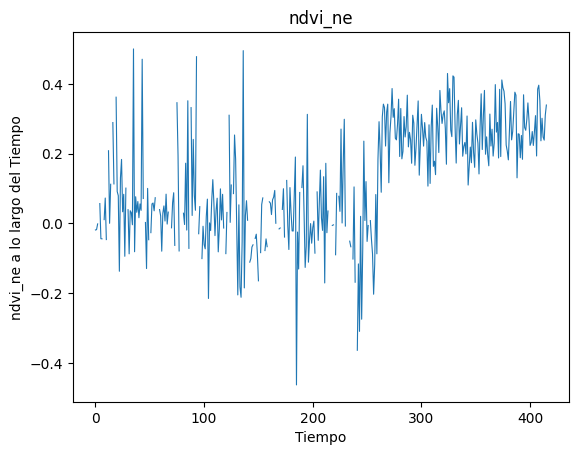

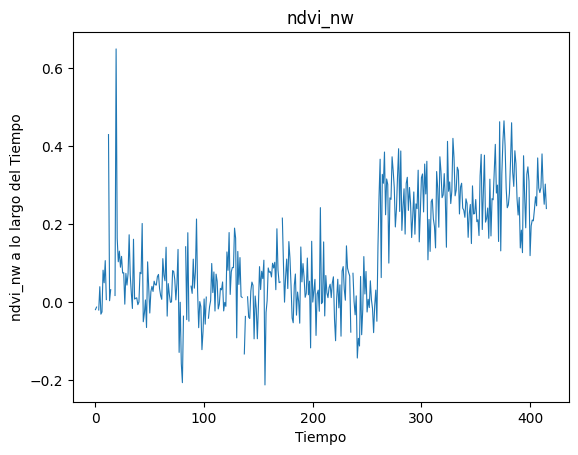

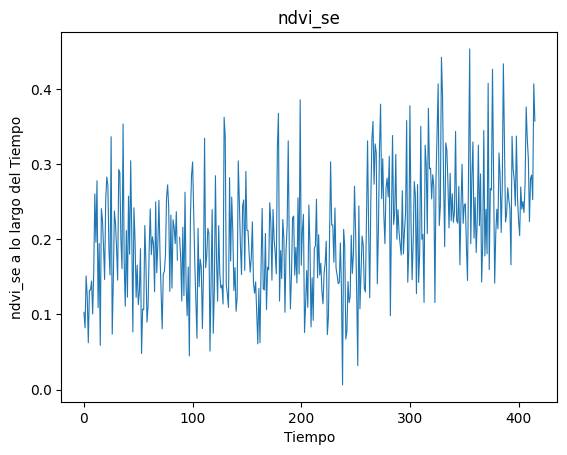

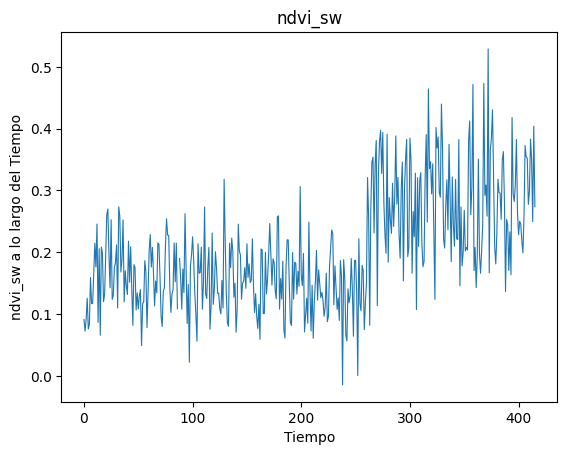

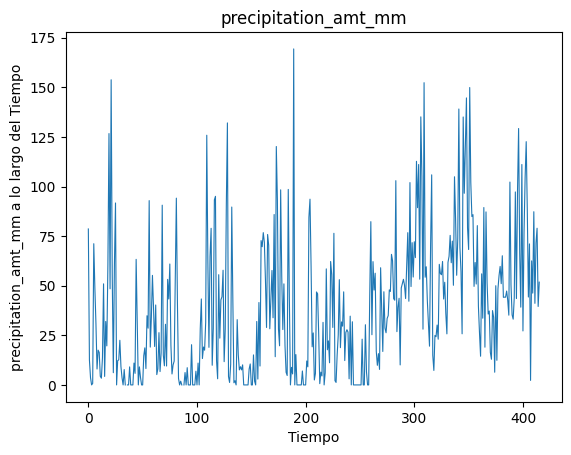

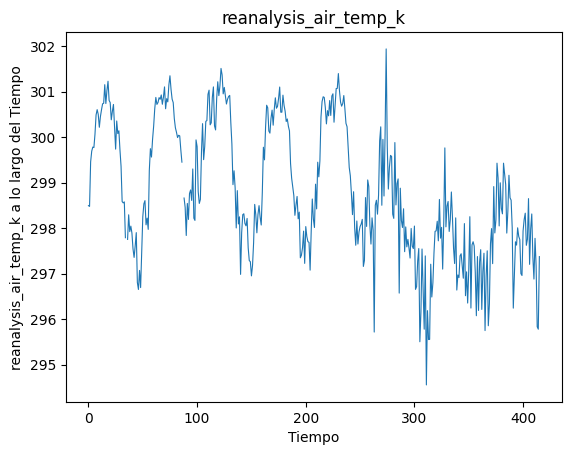

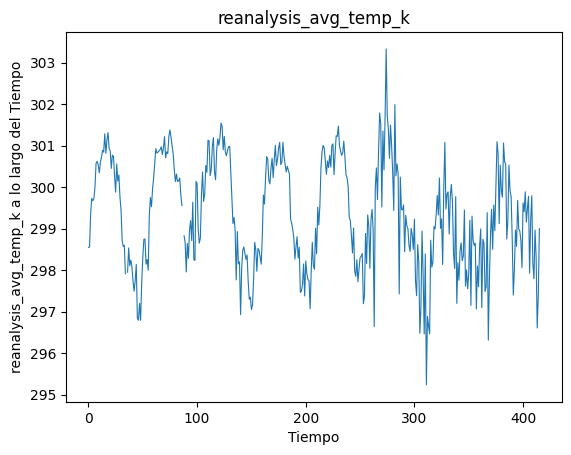

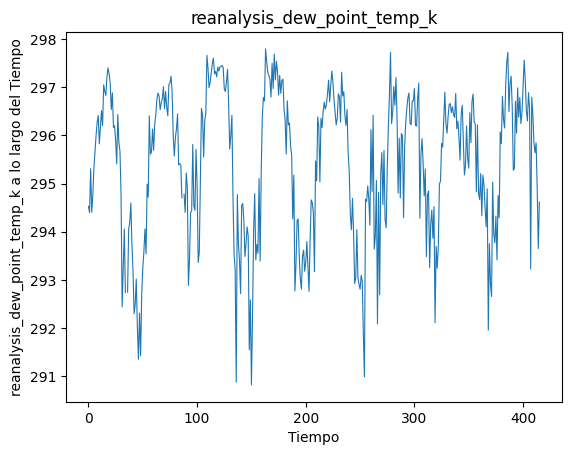

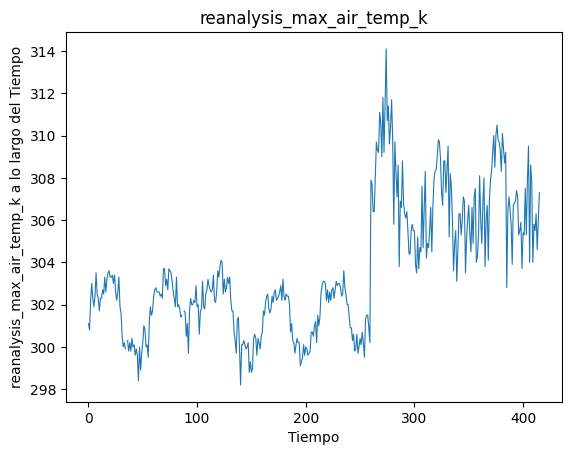

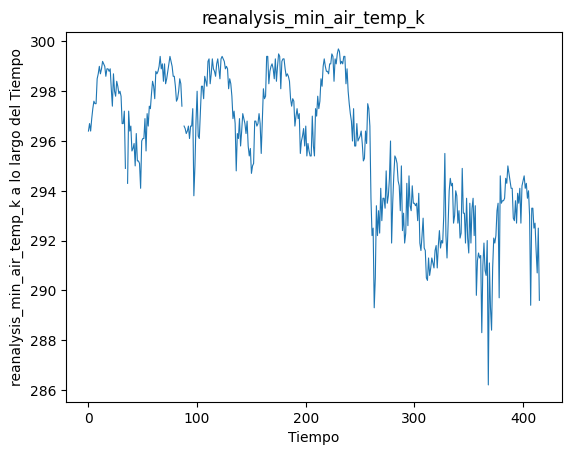

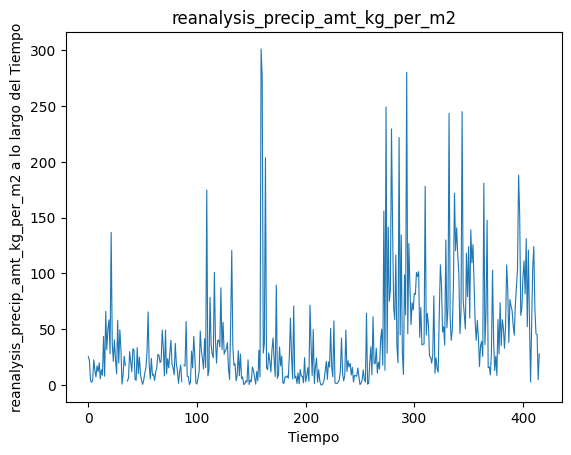

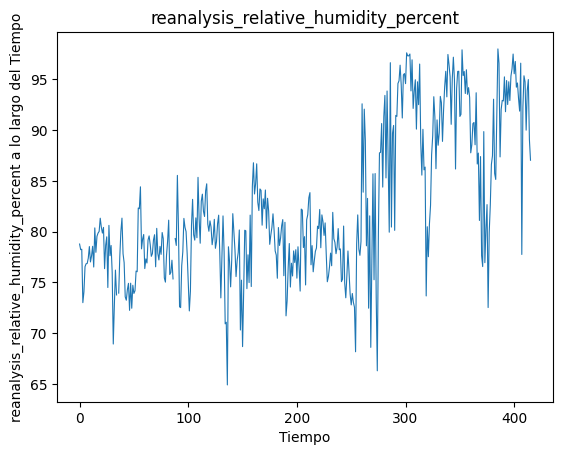

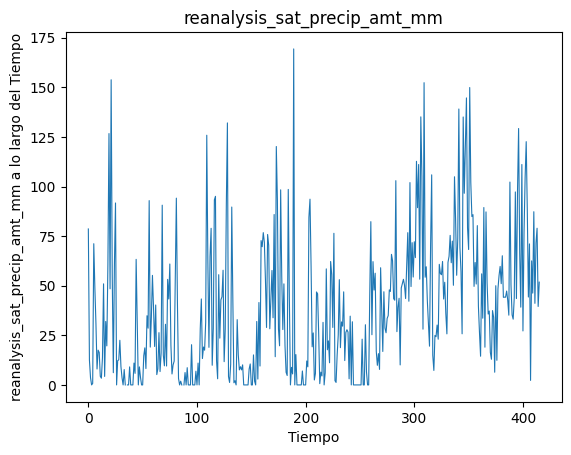

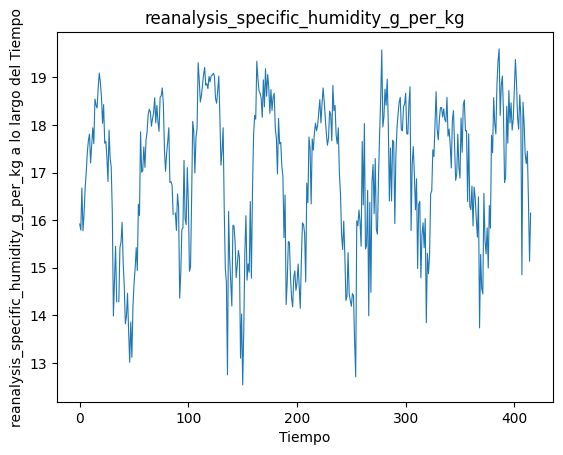

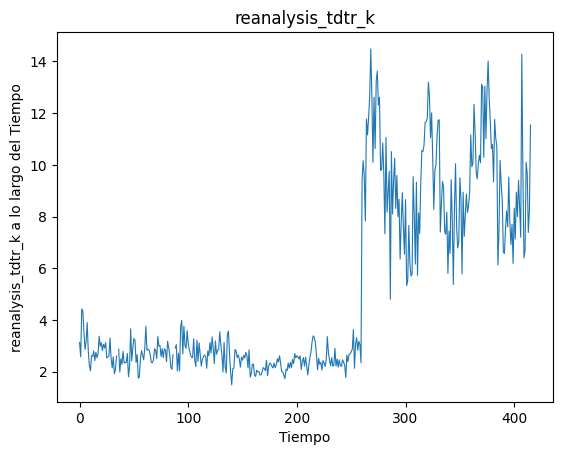

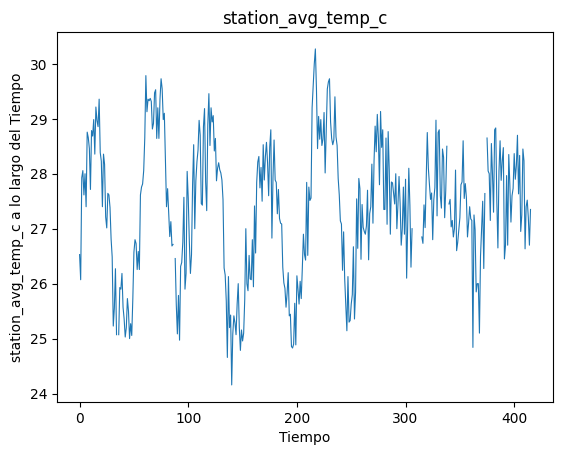

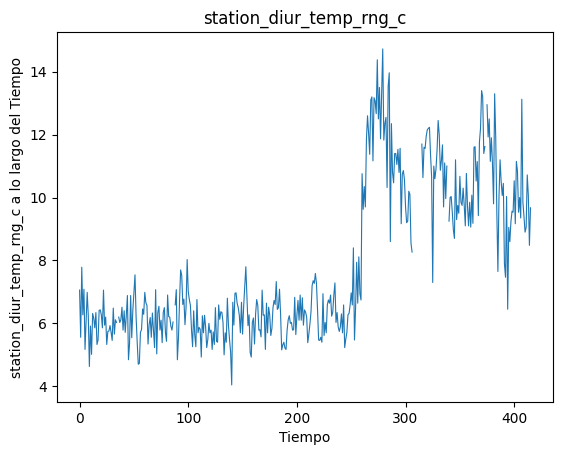

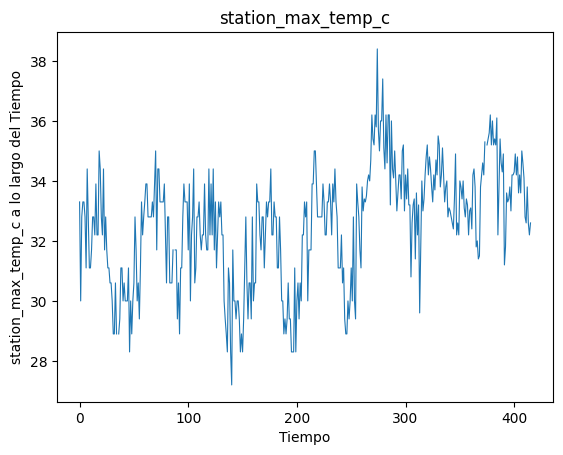

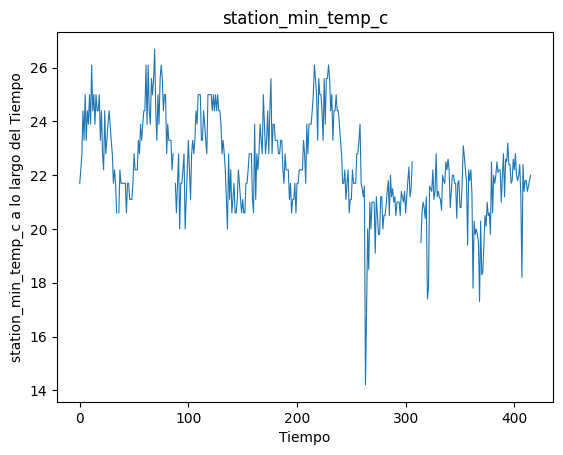

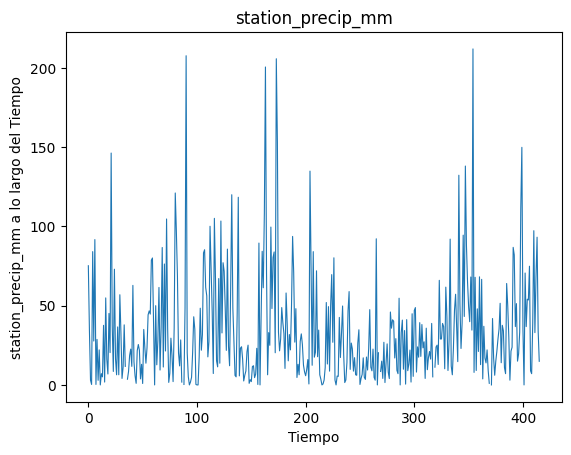

In [28]:
columns_to_exclude = ['year', 'weekofyear', 'city_bin']
columns_to_plot = [col for col in test.columns if col not in columns_to_exclude]

for col in columns_to_plot:
    (
        test[col]
        .plot.line(lw=0.8)
        .set_title(col)
    )

    plt.xlabel('Tiempo')
    plt.ylabel(col+' a lo largo del Tiempo')

    plt.show()

En las series de temporales graficadas se pueden ver los huecos donde hay NaN trazando los datos.

Para completar los valores perdidos, teniendo en cuenta que los datos son numéricos, que estos datos siguen un patrón y que se está realizando un análisis de series de tiempo, se ha decidido optar por el método interpolate().

In [29]:
# Completar valores perdidos con método interpolate
test.interpolate(inplace=True)
pd.isnull(test).any()

year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

Por último, se van a analizar los **valores atípicos** del DataFrame 'test'.

Primero, se utilizarán los **diagramas de cajas** para identificar posibles outliers.

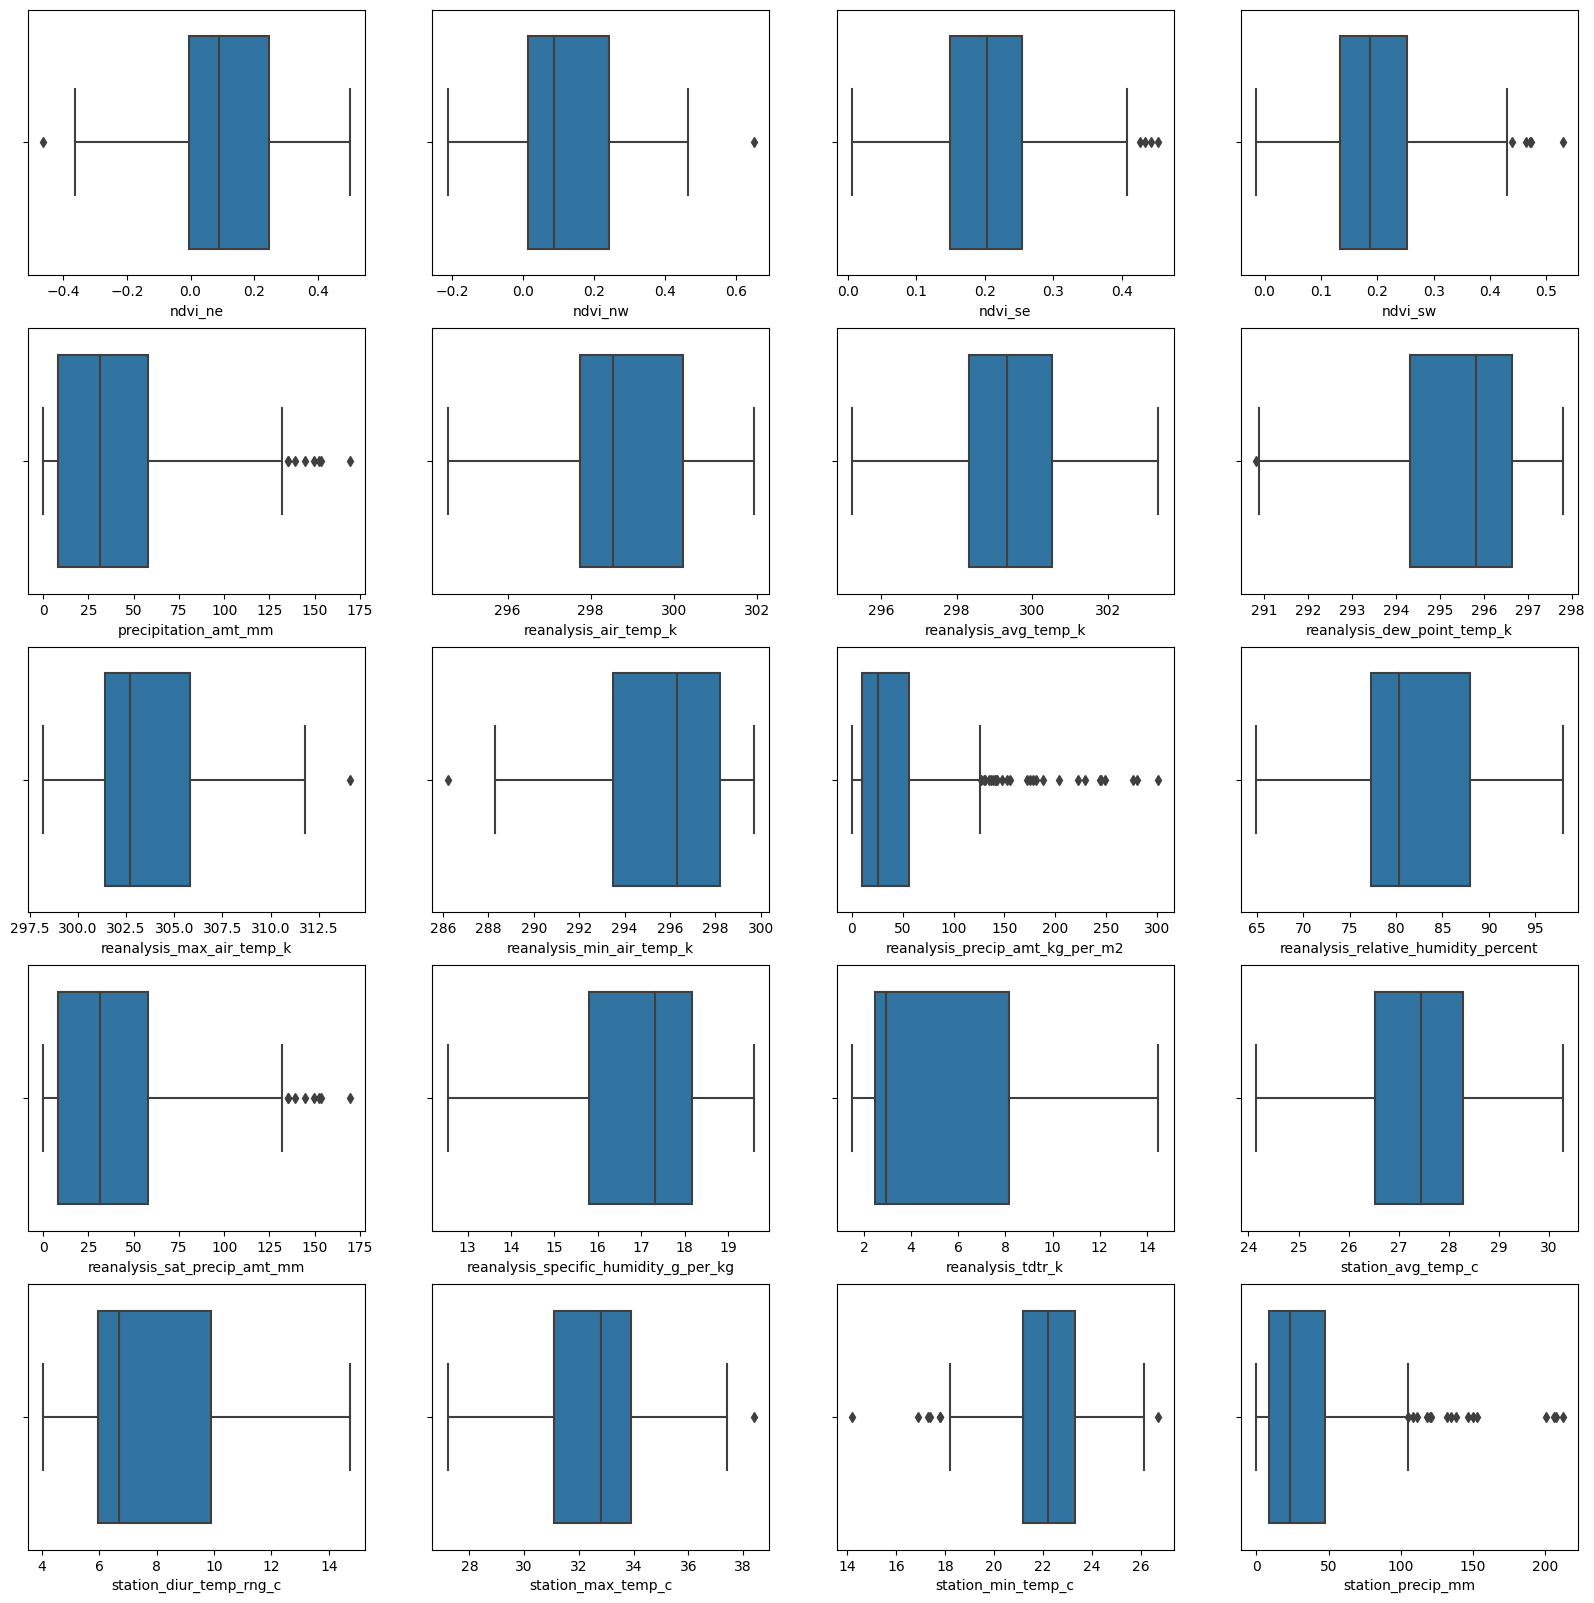

In [30]:
# Diagrama de cajas

f, axes = plt.subplots(figsize=(20,20),nrows=5, ncols=4)
i = 0; j = 0
for col in columns_to_plot :
  sns.boxplot(x=test[col], ax=axes[i, j])
  j += 1
  if (j == 4):
    j = 0; i += 1

plt.show()

Una vez graficados los outliers, se van a calcular los porcentajes en cada una de las variables. De esta manera se va a poder definir el mejor tratamiento para cada uno de los casos.

In [31]:
#Porcentaje de outliers
porcentaje_outliers = {}

#cols se ha definido arriba (se han eliminado las columnas 'year', 'weekofyear', 'city_bin')
for col in columns_to_plot:
    # Calcular los valores máximo y mínimo a partir del boxplot
    Q1 = test[col].quantile(0.25)
    Q3 = test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar los outliers en la columna
    outliers = test[(test[col] < lower_bound) | (test[col] > upper_bound)]
    num_outliers = len(outliers)

    # Calcular el porcentaje de outliers
    porcentaje = (num_outliers / len(test[col])) * 100

    # Guardar el porcentaje en el diccionario
    porcentaje_outliers[col] = porcentaje

# Imprimir los porcentajes de outliers en cada columna
for col, porcentaje in porcentaje_outliers.items():
    print(f"Columna {col}: {porcentaje:.2f}% de outliers")

Columna ndvi_ne: 0.24% de outliers
Columna ndvi_nw: 0.24% de outliers
Columna ndvi_se: 0.96% de outliers
Columna ndvi_sw: 1.20% de outliers
Columna precipitation_amt_mm: 1.92% de outliers
Columna reanalysis_air_temp_k: 0.00% de outliers
Columna reanalysis_avg_temp_k: 0.00% de outliers
Columna reanalysis_dew_point_temp_k: 0.24% de outliers
Columna reanalysis_max_air_temp_k: 0.24% de outliers
Columna reanalysis_min_air_temp_k: 0.24% de outliers
Columna reanalysis_precip_amt_kg_per_m2: 6.25% de outliers
Columna reanalysis_relative_humidity_percent: 0.00% de outliers
Columna reanalysis_sat_precip_amt_mm: 1.92% de outliers
Columna reanalysis_specific_humidity_g_per_kg: 0.00% de outliers
Columna reanalysis_tdtr_k: 0.00% de outliers
Columna station_avg_temp_c: 0.00% de outliers
Columna station_diur_temp_rng_c: 0.00% de outliers
Columna station_max_temp_c: 0.24% de outliers
Columna station_min_temp_c: 1.68% de outliers
Columna station_precip_mm: 3.85% de outliers


Tras analizar los porcentajes, se va a seguir este criterio:

1. Columnas con porcentajes de outliers muy bajos (menos del 1%): Se van a eliminar los outliers, ya que no son representativos para el análisis y podrían llegar a introducir un sesgo significativo.

2. Columnas con porcentajes de outliers moderados (entre el 1% y el 5%): Los outliers son importantes y podrían afectar negativamente a los datos. Por lo tanto, se van a sustituir por valores límite, en este caso, el rango intercuartílico.

3. Columnas con porcentajes de outliers altos (más del 5%): En este caso hay que analizar cuidadosamente la naturaleza de los outliers y el impacto potencial. Es recomendable considerar técnicas más avanzadas como transformaciones de variables, modelado robusto o métodos estadísticos más sofisticados. En el caso concreto de la variable que sobrepasa el 5% (reanalysis_precip_amt_kg_per_m2), la distribución del boxplot muestra que los outliers están muy concentrados y se dispersan a medida que se alejan del tercer cuartil (Q3), por lo que la técnica de truncamiento puede ser una opción adecuada.

**NOTA:** Aunque el preprocesamiento de *outliers* explicado en el anterior párrafo es el que se siguió en un primer momento, como Driven Data no acepta un valor menor de muestras/registros, se va a aplicar *truncate* a todas los valores perdidos.

In [32]:
"""
# Código para realizar el tratamiento d los outliers

# Lista para almacenar las columnas a eliminar o truncar
cols_eliminar = []
filas_eliminar = []
cols_truncar = []

# Recorrer las columnas del DataFrame
for col in columns_to_plot:
  # Calcular los valores máximo y mínimo a partir del boxplot
  Q1 = test[col].quantile(0.25)
  Q3 = test[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Calcular el porcentaje de outliers
  outliers_pct = test[(test[col] < lower_bound) | (test[col] > upper_bound)].shape[0] / test.shape[0] * 100

  # Verificar si el porcentaje es menor al 1%
  if outliers_pct < 1:
    # Obtener los índices de las filas a eliminar
    indices_eliminar = test[(test[col] < lower_bound) | (test[col] > upper_bound)].index
    filas_eliminar.extend(indices_eliminar)

    # Eliminar los outliers individuales
    test = test[(test[col] >= lower_bound) & (test[col] <= upper_bound)] #Se obtiene una serie booleana (tpye = bool) con la cual se filtra el df. Se eliminan todas las filas que no cumplan con la condición

  #Verificar si el porcentaje es mayor al 1%
  elif outliers_pct > 1:
    cols_truncar.append(col)
    # Truncar los valores fuera del rango intercuartílico
    test[col] = np.where(test[col] < lower_bound, lower_bound, test[col])
    test[col] = np.where(test[col] > upper_bound, upper_bound, test[col])
"""

'\n# Código para realizar el tratamiento d los outliers\n\n# Lista para almacenar las columnas a eliminar o truncar\ncols_eliminar = []\nfilas_eliminar = []\ncols_truncar = []\n\n# Recorrer las columnas del DataFrame\nfor col in columns_to_plot:\n  # Calcular los valores máximo y mínimo a partir del boxplot\n  Q1 = test[col].quantile(0.25)\n  Q3 = test[col].quantile(0.75)\n  IQR = Q3 - Q1\n  lower_bound = Q1 - 1.5 * IQR\n  upper_bound = Q3 + 1.5 * IQR\n\n  # Calcular el porcentaje de outliers\n  outliers_pct = test[(test[col] < lower_bound) | (test[col] > upper_bound)].shape[0] / test.shape[0] * 100\n\n  # Verificar si el porcentaje es menor al 1%\n  if outliers_pct < 1:\n    # Obtener los índices de las filas a eliminar\n    indices_eliminar = test[(test[col] < lower_bound) | (test[col] > upper_bound)].index\n    filas_eliminar.extend(indices_eliminar)\n\n    # Eliminar los outliers individuales\n    test = test[(test[col] >= lower_bound) & (test[col] <= upper_bound)] #Se obtiene una 

In [33]:
# Código para realizar el tratamiento d los outliers

# Recorrer las columnas del DataFrame
for col in columns_to_plot:
  # Calcular los valores máximo y mínimo a partir del boxplot
  Q1 = test[col].quantile(0.25)
  Q3 = test[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Truncar los valores fuera del rango intercuartílico
  test[col] = np.where(test[col] < lower_bound, lower_bound, test[col])
  test[col] = np.where(test[col] > upper_bound, upper_bound, test[col])

In [34]:
#Porcentaje de outliers
porcentaje_outliers = {}

#cols se ha definido arriba (se han eliminado las columnas 'year', 'weekofyear', 'city_bin')
for col in columns_to_plot:
    # Calcular los valores máximo y mínimo a partir del boxplot
    Q1 = test[col].quantile(0.25)
    Q3 = test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar los outliers en la columna
    outliers = test[(test[col] < lower_bound) | (test[col] > upper_bound)]
    num_outliers = len(outliers)

    # Calcular el porcentaje de outliers
    porcentaje = (num_outliers / len(test[col])) * 100

    # Guardar el porcentaje en el diccionario
    porcentaje_outliers[col] = porcentaje

# Imprimir los porcentajes de outliers en cada columna
for col, porcentaje in porcentaje_outliers.items():
    print(f"Columna {col}: {porcentaje:.2f}% de outliers")

Columna ndvi_ne: 0.00% de outliers
Columna ndvi_nw: 0.00% de outliers
Columna ndvi_se: 0.00% de outliers
Columna ndvi_sw: 0.00% de outliers
Columna precipitation_amt_mm: 0.00% de outliers
Columna reanalysis_air_temp_k: 0.00% de outliers
Columna reanalysis_avg_temp_k: 0.00% de outliers
Columna reanalysis_dew_point_temp_k: 0.00% de outliers
Columna reanalysis_max_air_temp_k: 0.00% de outliers
Columna reanalysis_min_air_temp_k: 0.00% de outliers
Columna reanalysis_precip_amt_kg_per_m2: 0.00% de outliers
Columna reanalysis_relative_humidity_percent: 0.00% de outliers
Columna reanalysis_sat_precip_amt_mm: 0.00% de outliers
Columna reanalysis_specific_humidity_g_per_kg: 0.00% de outliers
Columna reanalysis_tdtr_k: 0.00% de outliers
Columna station_avg_temp_c: 0.00% de outliers
Columna station_diur_temp_rng_c: 0.00% de outliers
Columna station_max_temp_c: 0.00% de outliers
Columna station_min_temp_c: 0.00% de outliers
Columna station_precip_mm: 0.00% de outliers


---
# Características
---

## Métrica

El objetivo principal de la actividad es predecir el número total de casos de dengue. Por lo tanto, la **variable objetivo** es **'total_cases'**, un número entero (discreto) y no negativo.

El **análisis de regresión** es la parte de aprendizaje automático que se ocupa de la predicción de valores numéricos continuos (respuesta cuantitativa en función de un vector de variables explicativas), por lo que es el análisis que se utilizará en esta práctica.

Las posibles **técnicas** que se pueden emplear son las siguientes:
* Regresión lineal simple
* Regresión lineal múltiple
* Arboles de decisión
* Random Forest
* Boosting
* Redes neuronales
* Vecinos más cercanos (KNN)

Para poder validar los resultados obtenidos por el modelo, se utilizará *Mean absolute error (MAE)*:

$$MAE = \sum_{i=0}^{N-1}|y_i-\hat{y}_i|^2$$

donde $y_i$ es el valor real y $\hat{y}_i$ es el valor predicho.

De esta manera, se podrán **parametrizar** los algoritmos de manera correcta y **validar** lo bien que se calculan los datos de salida ante la aparición de nuevas instancias.

Por último, para evaluar la **calidad del modelo**, es importante medir el error en el conjunto de entrenamiento y en la predicción. Es necesario obtener un buen ajuste para los datos de entrenamiento (ajuste de los parámetros del modelo) y, a su vez, que sea generalista con el fenómeno representado (ajuste de la complejidad del modelo). Para esto se utilizará la validación cruzada (***Cross-validation***), en concreto, la estrategia a seguir será ***K-fold cross-validation***.

## Normalización y modelos de regresión

La necesidad de normalizar depende principalmente de los requisitos y las características de cada modelo. A continuación, se presentan los posibles modelos de regresión que se pueden utilizar:

* **Regresión lineal simple:** No es necesario normalizar el conjunto de datos, ya que el algoritmo se encargará de encontrar la mejor relación lineal entre las variables.

* **Regresión lineal múltiple:** Es recomendable normalizar el conjunto de datos cuando las variables tienen diferentes escalas. Al normalizar, se asegura que todas las variables tengan una escala similar, lo cual puede ayudar al modelo a converger más rápidamente y evitar que ciertas variables dominen sobre otras.

* **Árboles de decisión:** No es necesario normalizar el conjunto de datos, ya que los árboles de decisión no se ven afectados por las escalas de las variables. Los árboles se basan en la estructura jerárquica de las reglas de decisión y no en las magnitudes de las variables.

* **Random Forest:** Al igual que con los árboles de decisión, no es necesario normalizar el conjunto de datos para el algoritmo de Random Forest. Los bosques aleatorios combinan múltiples árboles de decisión y, por lo tanto, no se ven afectados por las escalas de las variables.

* **Boosting:** En general, no es necesario normalizar el conjunto de datos para los algoritmos de boosting, como el Gradient Boosting o el AdaBoost. Estos modelos también combinan múltiples árboles de decisión y, por lo tanto, no se ven afectados por las escalas de las variables.

* **Redes neuronales:** Es altamente recomendable normalizar el conjunto de datos para las redes neuronales. La normalización ayuda a que las variables tengan una escala similar, lo cual puede mejorar la convergencia del modelo y evitar que ciertas variables dominen sobre otras. La normalización más común es la estandarización (por ejemplo, escalar las variables para que tengan media cero y desviación estándar uno).

* **Vecinos más cercanos (KNN):** Es necesario normalizar el conjunto de datos cuando se utiliza el algoritmo de vecinos más cercanos (KNN). KNN se basa en la distancia entre las instancias, por lo que las variables con escalas más grandes pueden tener un efecto dominante en la clasificación. La normalización asegura que todas las variables contribuyan por igual al cálculo de la distancia.

* **Regresión de Poisson:** No es necesario normalizar el conjunto de datos para la regresión de Poisson. Este modelo se utiliza para variables de respuesta que siguen una distribución de Poisson y no se ve afectado por las escalas de las variables predictoras.

* **Regresión binomial negativa:** No es necesario normalizar el conjunto de datos para la regresión binomial negativa. Este modelo se utiliza para variables de respuesta que siguen una distribución binomial negativa y no se ve afectado por las escalas de las variables predictoras.

En la Actividad 1, el conjunto de datos obtenido fue normalizado con *sklearn.preprocessing.StandardScaler*; esto es, estandarizando las características eliminando la media y escalando a la varianza unitaria: $z = (x - u) / s$.

Antes de realizar la selección de características mediante la matriz de correlaciones es recomendable normalizar el dataset. La razón principal es que la matriz de correlaciones se basa en los valores numéricos de las variables, y estas pueden tener diferentes escalas o rangos de valores. La normalización permite comparar y evaluar las correlaciones de manera más justa, ya que las diferencias de escala no afectarán el resultado.

Sin embargo, para la Actividad 2, dependiendo del modelo a emplear, puede ser recomendable no tener el dataset normalizado. Por lo tanto, se ha exportado el dataset tratado (limpieza y selección de observaciones y características) sin haberlo normalizado.

Tal y como se ha visto en el apartado *Preprocesado* tenemos ambos dataset de test normalizados:
* sj_train
* sj_train_noNorm
* iq_train
* iq_train_noNorm

A continuación, se va a normalizar el DataFrame test mediante la estandarización *Z_score estandarization*, tal y como se realizó con el dataset 'train'.

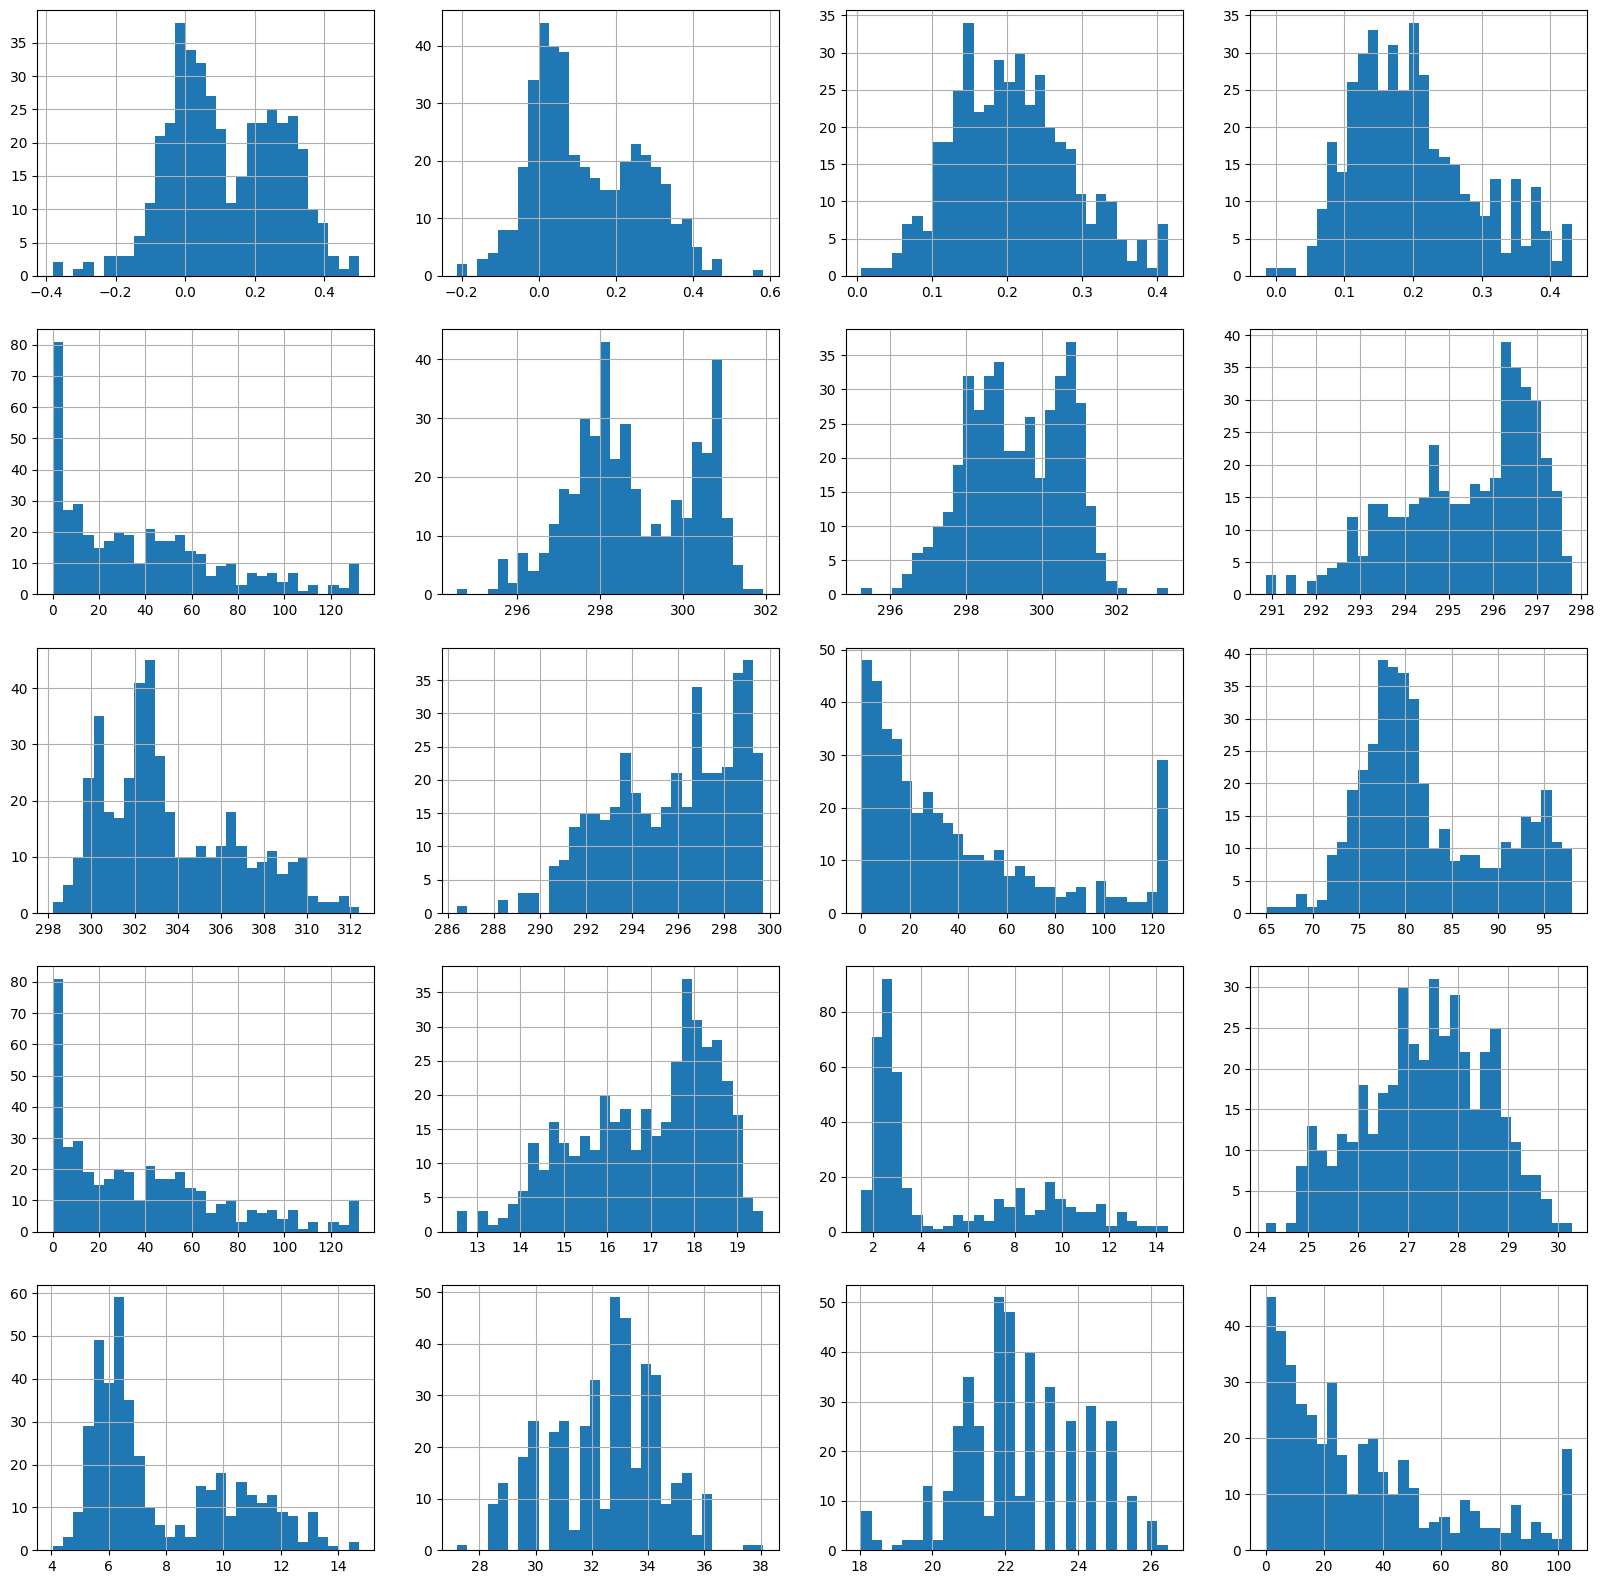

In [35]:
# Distribución de datos en 'test'
f, axes = plt.subplots(figsize=(20,20),nrows=5, ncols=4)
i = 0; j = 0
for col in columns_to_plot :
  test[col].hist(bins=30, ax=axes[i, j])
  j += 1
  if (j == 4):
    j = 0; i += 1
plt.show()

In [36]:
# Estandarización Z-score

from sklearn.preprocessing import StandardScaler

# Separamos las columnas que se van a estandarizar
cols_excluir = ['year', 'weekofyear', 'city_bin']
cols_estandarizar = [col for col in test.columns if col not in cols_excluir]

# Instanciar la clase StandardScaler y crear el dataframe
scaler = StandardScaler() #Se crea el objeto scaler de la clase StandardScaler
#Estandarizar el DataFrame
df_estandarizar_Z = pd.DataFrame(scaler.fit_transform(test[cols_estandarizar]), columns=cols_estandarizar)

# Reiniciar el índice de los dataframes
df_excluir = test[cols_excluir].reset_index(drop=True)
df_estandarizar_Z = df_estandarizar_Z.reset_index(drop=True)

# Verificar que no hay valores faltantes en las df construidas
print(df_excluir.isnull().any())
print(df_estandarizar_Z.isnull().any())

# Unir los dataframes
test_Z = pd.concat([df_excluir, df_estandarizar_Z], axis=1)

# Verificar que no hay valores faltantes en df_Z
print(test_Z.isnull().any())


year          False
weekofyear    False
city_bin      False
dtype: bool
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                  

### División del dataset test entre San Juan e Iquitos

In [37]:
# Cambio de nombre del DataFrame
test_noNorm = test.copy()
test = test_Z.copy()

# Dividir los datos de San Juan (sj=1)
sj_test = test[test['city_bin'] == 1].copy()
sj_test_noNorm = test_noNorm[test_noNorm['city_bin'] == 1].copy()

#Dividir datos de Iquitos
iq_test = test[test['city_bin'] == 0].copy()
iq_test_noNorm = test_noNorm[test_noNorm['city_bin'] == 0].copy()

# Se resetean los índices para que no haya problemas en un futuro
test_noNorm.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
sj_test.reset_index(drop=True, inplace=True)
sj_test_noNorm.reset_index(drop=True, inplace=True)
iq_test.reset_index(drop=True, inplace=True)
iq_test_noNorm.reset_index(drop=True, inplace=True)

In [38]:
test.head()

year  weekofyear  city_bin   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  2008          18         1 -0.837938 -1.025270 -1.337785 -1.216351   
1  2008          19         1 -0.832330 -0.978845 -1.602124 -1.425437   
2  2008          20         1 -0.729525 -1.005510 -0.719872 -1.212714   
3  2008          21         1 -0.547903 -1.032174 -1.061764 -0.834557   
4  2008          22         1 -0.366281 -0.605783 -1.854839 -1.385581   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_avg_temp_k  ...  \
0              1.188707              -0.220788              -0.613221  ...   
1             -0.739074              -0.232489              -0.607741  ...   
2             -0.998875               0.436390               0.006040  ...   
3             -1.105715               0.596297               0.291010  ...   
4             -1.083530               0.657724               0.247168  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                        -0.352327                             -0.500163   
1                        -0.448700                             -0.575003   
2                        -0.930837                             -0.569575   
3                        -0.983107                             -1.282693   
4                        -0.924303                             -1.137665   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                      1.188707                              -0.641981   
1                     -0.739074                              -0.723582   
2                     -0.998875                              -0.156956   
3                     -1.105715                              -0.733668   
4                     -1.083530                              -0.501699   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0          -0.561605           -0.678175                -0.328620   
1          -0.719264           -1.052428                -0.941514   
2          -0.193735            0.467977                -0.030928   
3          -0.217990            0.573235                -0.649660   
4          -0.444372            0.210677                -0.316945   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0            0.400712           -0.393712           1.486923  
1           -1.315928           -0.094070           0.069793  
2            0.140615            0.265500          -1.014710  
3            0.400712            1.224355          -1.108262  
4            0.400712            0.565142           1.795296  

[5 rows x 23 columns]

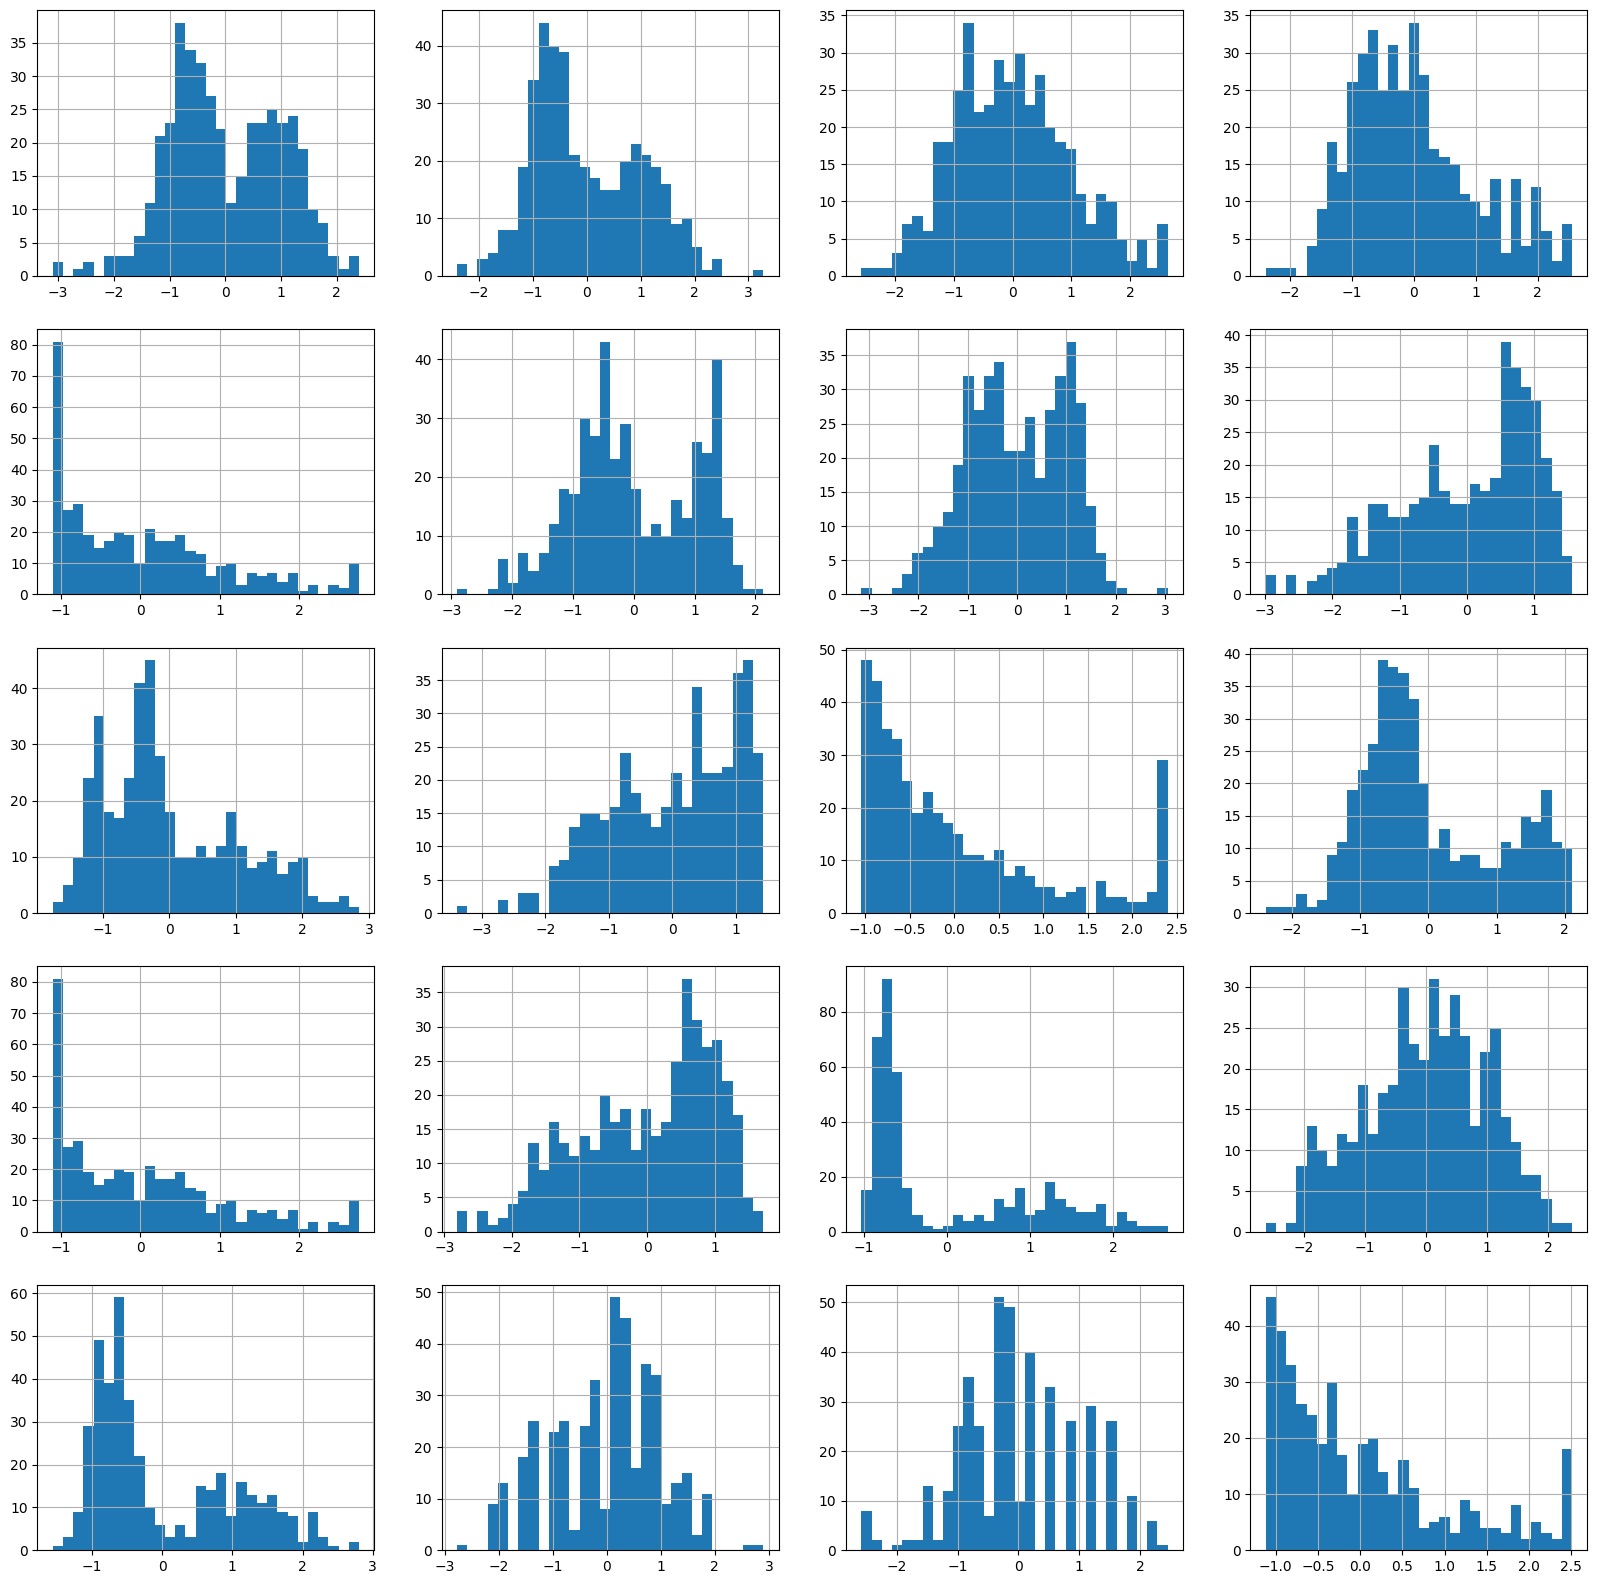

In [39]:
# Distribución de datos en 'test_Z'
f, axes = plt.subplots(figsize=(20,20),nrows=5, ncols=4)
i = 0; j = 0
for col in columns_to_plot :
  test_Z[col].hist(bins=30, ax=axes[i, j])
  j += 1
  if (j == 4):
    j = 0; i += 1
plt.show()

## Correlación con 'total_cases'

Se va a estudiar la correlación entre las características con la variable objetivo 'total_cases'.

Es verdad que en la Actividad 1 se realizó un estudio de correlación entre las diferentes características del dataset, sin embargo, no se estudió la correlación entre las características climáticas y la variable objetivo.

Al estudiar la relación entre variables, podremos seleccionar un subconjunto de características y eliminar información redundante e irrelevante.

En este caso se van a emplear los DataFrames estandarizados. La normalización ayuda a que todas las variables tengan una escala similar, por lo que la comparación entre variables será más justa.

In [40]:
# Correlaciones

cols_interes_sj = sj_train.columns.difference(['city_bin', 'year', 'weekofyear'])
cols_interes_iq = iq_train.columns.difference(['city_bin', 'year', 'weekofyear'])

sj_corr = sj_train[cols_interes_sj].corr()
iq_corr = iq_train[cols_interes_iq].corr()

Text(0.5, 1.0, 'Correlaciones San Juan')

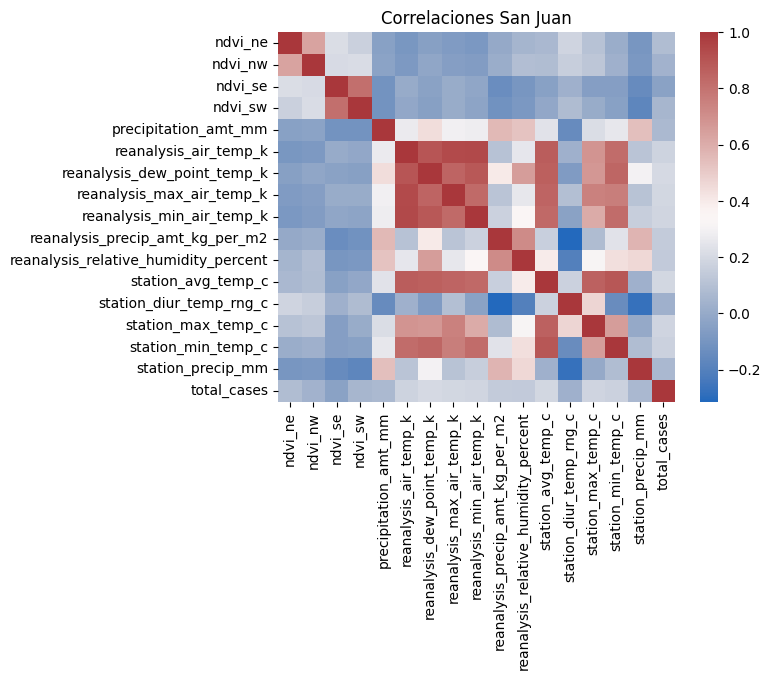

In [41]:
# Graficar San Juan
sj_corr_heat = sns.heatmap(sj_corr, cmap = "vlag")
plt.title("Correlaciones San Juan")

Text(0.5, 1.0, 'Correlaciones Iquitos')

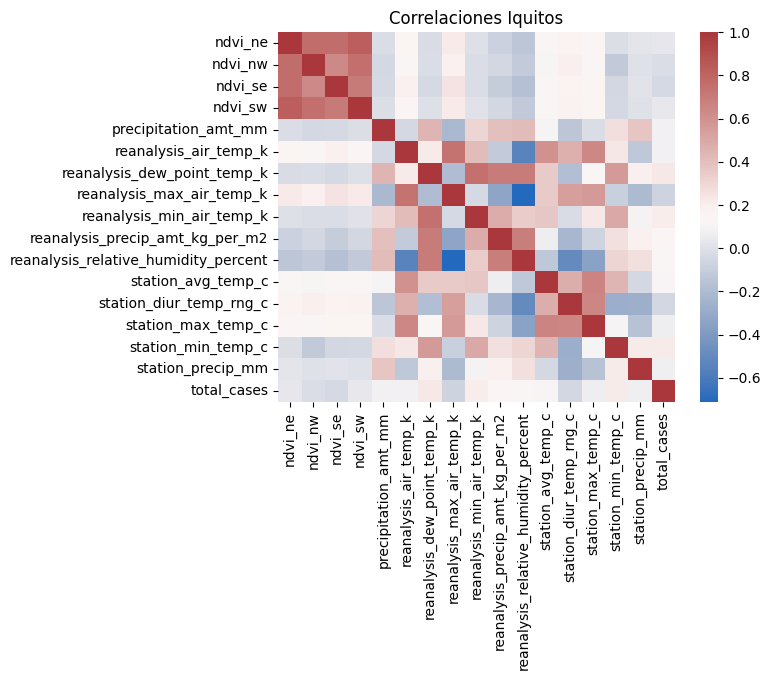

In [42]:
# Graficar Iquitos
sj_corr_heat = sns.heatmap(iq_corr, cmap = "vlag")
plt.title("Correlaciones Iquitos")

Como se observó en la Actividad 1, muchas de las variables relacionadas con la temperatura están fuertemente correlacionadas. Sin embargo, la variable 'total_cases' no tiene correlaciones claras. A continuación, se va a analizar la correlación de 'total_cases' de forma más precisa.

<Axes: >

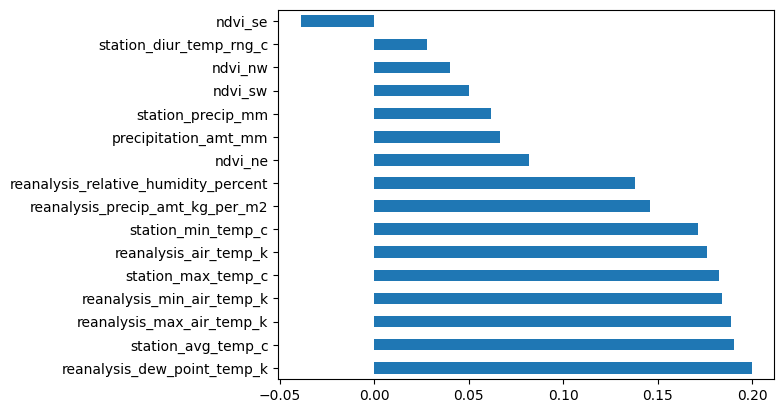

In [43]:
# San Juan
sj_corr.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh()

<Axes: >

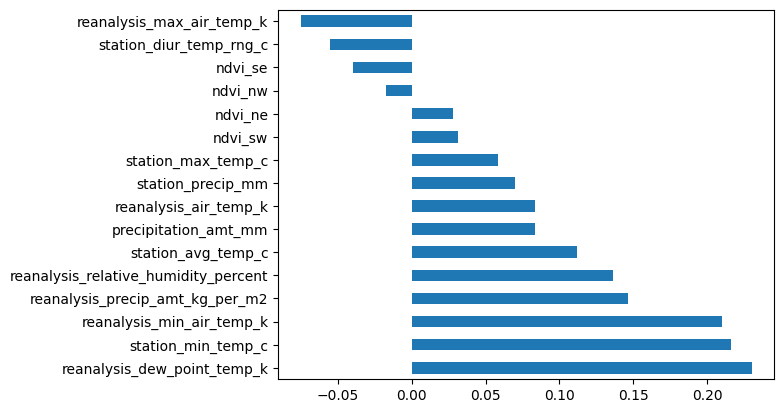

In [44]:
# Iquitos
iq_corr.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh()

Hay que tener en cuenta que en la Actividad 1 eliminamos las siguientes características:
* 'reanalysis_sat_precip_amt_mm'
* 'reanalysis_avg_temp_k'
* 'reanalysis_specific_humidity_g_per_kg'
* 'reanalysis_tdtr_k'

Tras revisar los anteriores gráficos, parece que **'reanalysis_dew_point_temp_k'** es la característica más fuertemente correlacionada con 'total_cases' en ambas ciudades; por lo que, cuanto más húmedo sea el clima, más picaduras habrá.

Asimismo, en cuanto a la **temperatura** se refiere, en ambas ciudades, cuando la temperatura media y la temperatura mínima suben, los casos de dengue también aumentan. En San Juan también sucede con la temperatura máxima. Sin embargo, en Iquitos (medición renalysis) la temperatura máxima y el número total de casos tienen una correlación negativa.

También se puede apreciar que la correlación ente **precipitation** y total_cases es pequeña, por lo que no parece que tenga mucha influencia en el resultado.

Por útimo, la **humedad** también parece tener impacto en el número total de casos.

### Correlación: Características influyentes
Por lo tanto, aunque ninguna de las correlaciones sea muy fuerte, parece que las características más influyentes en el número total de casos de dengue son:
* reanalysis_dew_point_temp_k
* station_avg_temp_c
* station_min_temp_c
* renalysis_relative_humidity_percent

## Importancia de cada característica

Además de realizar un estudio de correlaciones, también se va a utilizar el algoritmo *'RandomForestRegressor'* para obtener una medida de importancia de características. Cuanto mayor sea el valor obtenido por el atributo *'feature_importances_'*, mayor será la importancia relativa de la característica.

In [46]:
from sklearn.ensemble import RandomForestRegressor

def caract_import(train):

  # Entrenar el modelo de bosque aleatorio
  model_RF = RandomForestRegressor(random_state = 0)
  model_RF.fit(X = train.drop(['total_cases'], axis=1),
                              y = train['total_cases'])

  # Asociar los valores de importancia con los nombres de características
  importances = model_RF.feature_importances_

  # Obtener los nombres de las características del DataFrame
  feature_names = train.columns.values

  #Crear una lista de pares (característica, importancia)
  feature_importances = list(zip(feature_names, importances))

  # Ordenar la lista de pares por importancia en orden descendente
  sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

  # Imprimir la importancia de cada característica en orden descendente
  for feature_name, importance in sorted_importances:
      print(f'{feature_name}: {importance}')

  # Devolver sorted_importances como resultado

  # Nombres de características a eliminar
  carac_a_eliminar = ['year', 'weekofyear','city_bin']

  # Filtrar la lista eliminando los elementos con los nombres específicos
  sorted_importances = [tupla for tupla in sorted_importances if tupla[0] not in carac_a_eliminar]

  return sorted_importances

In [47]:
sj_feature_importances = caract_import(sj_train)

year: 0.39936012571418944
weekofyear: 0.19113297061668766
ndvi_sw: 0.06426251032356142
reanalysis_dew_point_temp_k: 0.060091472127463845
ndvi_se: 0.035593967521749176
ndvi_nw: 0.03216254686186892
reanalysis_precip_amt_kg_per_m2: 0.029019601545236178
station_max_temp_c: 0.027302817099873544
reanalysis_max_air_temp_k: 0.022509826903827544
reanalysis_relative_humidity_percent: 0.022504813401704335
reanalysis_air_temp_k: 0.02146334212986534
station_precip_mm: 0.019686291675461896
ndvi_ne: 0.01809453044959027
station_diur_temp_rng_c: 0.015369684212586242
station_avg_temp_c: 0.014658342341064638
precipitation_amt_mm: 0.010118776591746058
reanalysis_min_air_temp_k: 0.008984094465899496
station_min_temp_c: 0.007684286017623981
city_bin: 0.0


In [48]:
print(sj_feature_importances)

[('ndvi_sw', 0.06426251032356142), ('reanalysis_dew_point_temp_k', 0.060091472127463845), ('ndvi_se', 0.035593967521749176), ('ndvi_nw', 0.03216254686186892), ('reanalysis_precip_amt_kg_per_m2', 0.029019601545236178), ('station_max_temp_c', 0.027302817099873544), ('reanalysis_max_air_temp_k', 0.022509826903827544), ('reanalysis_relative_humidity_percent', 0.022504813401704335), ('reanalysis_air_temp_k', 0.02146334212986534), ('station_precip_mm', 0.019686291675461896), ('ndvi_ne', 0.01809453044959027), ('station_diur_temp_rng_c', 0.015369684212586242), ('station_avg_temp_c', 0.014658342341064638), ('precipitation_amt_mm', 0.010118776591746058), ('reanalysis_min_air_temp_k', 0.008984094465899496), ('station_min_temp_c', 0.007684286017623981)]


In [49]:
iq_feature_importances = caract_import(iq_train)

weekofyear: 0.15241349158724238
year: 0.1445184583586178
reanalysis_dew_point_temp_k: 0.07862617812460349
station_precip_mm: 0.07556726253574865
station_diur_temp_rng_c: 0.07551707271207053
station_avg_temp_c: 0.05194019793065037
ndvi_sw: 0.04450412818380811
station_min_temp_c: 0.040991176375644464
reanalysis_precip_amt_kg_per_m2: 0.040220898421298855
ndvi_nw: 0.03934945812818857
reanalysis_min_air_temp_k: 0.037059736235801014
ndvi_se: 0.03561877938740609
station_max_temp_c: 0.03479101791091878
reanalysis_air_temp_k: 0.03457205510389874
reanalysis_max_air_temp_k: 0.03233433815848154
ndvi_ne: 0.028948662692454868
precipitation_amt_mm: 0.028346733724741037
reanalysis_relative_humidity_percent: 0.024680354428424773
city_bin: 0.0


In [50]:
print(len(sj_feature_importances))

16


Para seleccionar las características relevantes se va a emplear un umbral basado en la importancia relativa; esto es, se van a seleccionar las características cuya importancia esté por encima del 40% del umbral máximo.

In [51]:
def caract_selec (feature_import):
  feature_select = []
  umbral = (feature_import[0][1])*0.4
  print(umbral)
  for tupla in feature_import:
    if tupla[1] > umbral:
      feature_select.append(tupla[0])
  return feature_select

In [52]:
sj_feature_selec = caract_selec(sj_feature_importances)
print(sj_feature_selec)

0.025705004129424572
['ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c']


In [53]:
print(len(sj_feature_selec))

6


In [54]:
iq_feature_selec = caract_selec(iq_feature_importances)
print(iq_feature_selec)

0.0314504712498414
['reanalysis_dew_point_temp_k', 'station_precip_mm', 'station_diur_temp_rng_c', 'station_avg_temp_c', 'ndvi_sw', 'station_min_temp_c', 'reanalysis_precip_amt_kg_per_m2', 'ndvi_nw', 'reanalysis_min_air_temp_k', 'ndvi_se', 'station_max_temp_c', 'reanalysis_air_temp_k', 'reanalysis_max_air_temp_k']


In [55]:
print(len(iq_feature_selec))

13


Por último, se van a seleccionar las características comunes en ambas ciudades:

In [56]:
# Crear una tercera lista con los nombres iguales en ambas listas
carac_selec1 = [carac for carac in sj_feature_selec if carac in iq_feature_selec]
carac_a_eliminar = ['year', 'weekofyear','city_bin']
carac_selec = carac_a_eliminar + carac_selec1
carac_selec.append('total_cases')
print(carac_selec)

['year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c', 'total_cases']


En este caso, al igual que en análisis de correlación, se han obtenido las características correspondientes a humedad y temperatura.

#### Selección de características en los dataset test y test_noNorm

*NOTA: La selección de características en el dataset train se realiza más adelante*

In [57]:
print(carac_selec)
carac_selec_test = carac_selec[:]
carac_selec_test.remove('total_cases')
print(carac_selec_test)

test_selec = test[carac_selec_test]
test_selec_noNorm = test_noNorm[carac_selec_test]
sj_test_selec = sj_test[carac_selec_test]
sj_test_selec_noNorm = sj_test_noNorm[carac_selec_test]
iq_test_selec = iq_test[carac_selec_test]
iq_test_selec_noNorm = iq_test_noNorm[carac_selec_test]

['year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c', 'total_cases']
['year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c']


### ¿El dataset cuenta con un gran número de características?

Consideraciones:
* Relación entre características y muestras
* Complejidad computacional
* Relevancia y redundancia de las características

Referencias:
* Regla general: Si el número de características es del mismo orden o mayor que el número de muestras, se podría considerar un gran número de características.
* Aprendizaje supervisado tradicional: Se sugiere que el número de características no exceda de 10 veces el número de muestras

En nuestro caso, el número es el siguiente:
* San Juan: (902, 20)
* Iquitos: (466, 20)
Los números no están en el mismo orden, por lo tanto, es factible realizar la predicción utilizando todas las características.

 ---
# Predicción
---

### División train test

Primero se va a dividir el conjunto de datos en dos partes, una para el entrenamiento (Training data) y otra para evaluación final (Test data).

Se va a emplear un 70% para el entrenamiento y un 30% para la prueba.

Además, teniendo en cuenta que estamos empleando datos dependientes del tiempo, se utilizará una fecha específica para separar el dataset.

Dado que se trata de un modelo de series temporales, se utilizará un conjunto de retención de futuro estricto cuando se divida el conjunto de entrenamiento y el conjunto de prueba. Se realizará por separado para nuestro el de San Juan y para el modelo de Iquitos.


In [58]:
print("San Juan normalizado", sj_train.shape)
print("San Juan NO normalizado", sj_train_noNorm.shape)
print("Iquitos normalizado", iq_train.shape)
print("Iquitos NO normalizado", iq_train_noNorm.shape)
print("Sin dividir", train.shape)

San Juan normalizado (902, 20)
San Juan NO normalizado (902, 20)
Iquitos normalizado (466, 20)
Iquitos NO normalizado (466, 20)
Sin dividir (1368, 20)


In [59]:
print(902*0.7)
print(466*0.7)
print(1368*0.7)

631.4
326.2
957.5999999999999


In [60]:
# DATASET SIN DIVIDIR
train_subtrain = train.head(958)
train_subtest = train.tail(train.shape[0] - 958)

train_subtrain_noNorm = train_noNorm.head(958)
train_subtest_noNorm = train.tail(train_noNorm.shape[0] - 958)

train_subtrain_selec = train[carac_selec].head(958)
train_subtest_selec = train[carac_selec].tail(train.shape[0] - 958)

train_subtrain_selec_noNorm = train_noNorm[carac_selec].head(958)
train_subtest_selec_noNorm = train[carac_selec].tail(train_noNorm.shape[0] - 958)

# DATASET COMPLETO

sj_train_subtrain = sj_train.head(612)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 612)

sj_train_subtrain_noNorm = sj_train_noNorm.head(612)
sj_train_subtest_noNorm = sj_train_noNorm.tail(sj_train.shape[0] - 612)

iq_train_subtrain = iq_train.head(325)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 325)

iq_train_subtrain_noNorm = iq_train_noNorm.head(325)
iq_train_subtest_noNorm = iq_train_noNorm.tail(iq_train.shape[0] - 325)

# DATASET CARACT. SELECCIONADAS

sj_train_subtrain_selec = sj_train[carac_selec].head(612)
sj_train_subtest_selec = sj_train[carac_selec].tail(sj_train.shape[0] - 612)

sj_train_subtrain_selec_noNorm = sj_train_noNorm[carac_selec].head(612)
sj_train_subtest_selec_noNorm = sj_train_noNorm[carac_selec].tail(sj_train.shape[0] - 612)

iq_train_subtrain_selec = iq_train[carac_selec].head(325)
iq_train_subtest_selec = iq_train[carac_selec].tail(sj_train.shape[0] - 325)

iq_train_subtrain_selec_noNorm = iq_train_noNorm[carac_selec].head(325)
iq_train_subtest_selec_noNorm = iq_train_noNorm[carac_selec].tail(iq_train.shape[0] - 325)

In [61]:
train_subtrain_selec

year  weekofyear  city_bin   ndvi_sw  reanalysis_dew_point_temp_k  \
0    1990          18         1 -0.273059                    -2.038997   
1    1990          19         1 -0.553103                    -0.970438   
2    1990          20         1 -0.358774                     0.060384   
3    1990          21         1  0.464274                    -0.026015   
4    1990          22         1  0.609216                     0.329510   
..    ...         ...       ...       ...                          ...   
953  2001          36         0  1.768355                    -0.307058   
954  2001          37         0  2.544448                    -0.851268   
955  2001          38         0  1.946776                    -0.521564   
956  2001          39         0  1.525760                    -0.731105   
957  2001          40         0  2.544448                    -0.402394   

      ndvi_se   ndvi_nw  reanalysis_precip_amt_kg_per_m2  station_max_temp_c  \
0   -0.035307 -0.204344                        -0.182188           -1.636456   
1   -0.542414  0.128725                        -0.635171           -0.402893   
2   -0.614805  0.395455                        -0.372273           -0.134727   
3    0.372806  1.020014                        -0.765331            0.455237   
4    0.704684  1.168430                        -0.820101            1.367001   
..        ...       ...                              ...                 ...   
953 -0.142156  0.985035                         0.069111            0.991569   
954  1.365831  1.065471                        -0.581689            1.474268   
955  2.213271  1.876766                         0.898398            1.367001   
956  1.184753  2.263480                        -0.507588            0.508871   
957  0.571130  1.247134                        -0.162857            1.635167   

     total_cases  
0              4  
1              5  
2              4  
3              3  
4              6  
..           ...  
953            0  
954            0  
955            0  
956            0  
957            0  

[958 rows x 10 columns]

### Dataset test para descargar

Es necesario convertir otra vez 'ciy_bin' en San Juan e Iquitos. Es por ello que se va a realizar una copia de los tres dataframes.

In [62]:
test_noNorm_descarga = test_noNorm.copy()
test_noNorm_descarga['city_bin'] = test_noNorm_descarga['city_bin'].replace({0: 'iq', 1: 'sj'})

test_descarga = test.copy()
test_descarga['city_bin'] = test_descarga['city_bin'].replace({0: 'iq', 1: 'sj'})

sj_test_noNorm_descarga = sj_test_noNorm.copy()
sj_test_noNorm_descarga['city_bin'] = sj_test_noNorm_descarga['city_bin'].replace({0: 'iq', 1: 'sj'})

sj_test_descarga = sj_test.copy()
sj_test_descarga['city_bin'] = sj_test_descarga['city_bin'].replace({0: 'iq', 1: 'sj'})

iq_test_noNorm_descarga = iq_test_noNorm.copy()
iq_test_noNorm_descarga['city_bin'] = iq_test_noNorm_descarga['city_bin'].replace({0: 'iq', 1: 'sj'})

iq_test_descarga = iq_test.copy()
iq_test_descarga['city_bin'] = iq_test_descarga['city_bin'].replace({0: 'iq', 1: 'sj'})

### Validación cruzada

Ajustar los hiperparámetros basándose en el rendimiento en el conjunto de prueba puede provocar un sesgo en la evaluación del modelo y una falta de generalización. Por lo tanto, mediante ***Cross-validation*** se va a realizar la evaluación de los hiperparámetros en busca del mejor. Este método consiste en entrenar el modelo utilizando $K-1$ subconjuntos como datos de entrenamiento y 1 conjunto como datos de validación. El proceso de validación se repite durante $K$ iteraciones y finalmente se calcula error se calcula como la media aritmética de los errores de cada iteración para obtener un único resultado.

#### Estrategias de validación cruzada

**KFold** es una estrategia de validación cruzada que divide los datos en k pliegues de tamaño igual, y se utiliza comúnmente en problemas de aprendizaje automático estándar.

**TimeSeriesSplit** es una estrategia de validación cruzada diseñada específicamente para problemas de series de tiempo, donde el orden temporal de los datos es importante. Divide los datos en conjuntos de entrenamiento y prueba de manera secuencial, a medida que avanza en el tiempo.

In [63]:
from sklearn.model_selection import  KFold, TimeSeriesSplit # The classes that implement the KFold (K-Folds cross-validator) and TimeSeriesSplit (Time Series cross-validator) algorithms
from sklearn.metrics import mean_absolute_error # Métrica de regresión: Mean absolute error regression loss

## Vecinos más cercanos (KNN)

El algoritmo de Vecinos más Cercanos (KNN, por sus siglas en inglés) es un método de clasificación supervisada que se basa en encontrar los k ejemplos de entrenamiento más cercanos en función de una medida de distancia y asignar la etiqueta más común entre estos vecinos al nuevo dato de entrada. En resumen, KNN utiliza la proximidad de los ejemplos de entrenamiento para predecir la clase de un dato desconocido, donde la elección de k determina la influencia de los vecinos cercanos en la clasificación.

### Parametrización

In [64]:
from sklearn.neighbors import KNeighborsRegressor # Regression based on k-nearest neighbors

def get_best_model_KNN(train, n_range):

  # Resetear el índice del DataFrame
  train.reset_index(drop=True, inplace=True)

  # Instancia de la clase TimeSeriesSplit con 10 subconjuntos
  cv = TimeSeriesSplit(n_splits = 10)

  # Validación cruzada: Encontrar los mejores hiperparámetros

  # Hiperparámetros A que se van a validar: Pesos
  weights_list = ['uniform', 'distance']

  plt.figure(figsize=(15, 6))

  for weight in weights_list:
    total_scores = [] # En esta lista se va guardar el MAE promedio de cada Cross Validation realizado por parámetro probado (1,30)

    for n_neighbors in range(n_range[0], n_range[1]): # Hiperparámetros B que se van a validar: Número de vecinos más cercanos
      fold_accuracy = [] # Lista donde se va a guardar el MAE de cada interación de Cross Validation
      knn = KNeighborsRegressor(n_neighbors, weights=weight) #Instancia de KNeighborsRegressor

      for i, (train_index, test_index) in enumerate(cv.split(train)):
        #print(f"Fold {i}:")
        #print(f"  Train: index={train_index}, num_elements={len(train_index)}")
        #print(f"  Test:  index={test_index}")

        # División train test aleatoria
        f_train = train.loc[train_index]
        f_test = train.loc[test_index]

        # Entrenamiento del modelo
        knn.fit( X = f_train.drop(['total_cases'], axis=1), #Hay que eliminar la etiqueta para entenar el modelo
                y = f_train['total_cases']) # Entrenamiento
        y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1)) # Predicción con el modelo entrenado

        # Evaluación del modelo
        mae = mean_absolute_error(f_test['total_cases'], y_pred)
        fold_accuracy.append(mae)

      total_scores.append(sum(fold_accuracy)/len(fold_accuracy)) #Se normaliza el resultado y se guarda el resultado promedio de la Validación Cruzada

    plt.plot(range(1,len(total_scores)+1), total_scores,
              marker='o', label=weight) #marker = 'o' --> Para marcar los puntos en una gráfica con un círculo
    print ('Min Value ' + weight + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
    plt.ylabel('MAE')

  plt.legend()
  plt.show()

#### Dataset conjunto

Min Value uniform : 29.155757575757583 (55)
Min Value distance : 29.335381459471613 (58)


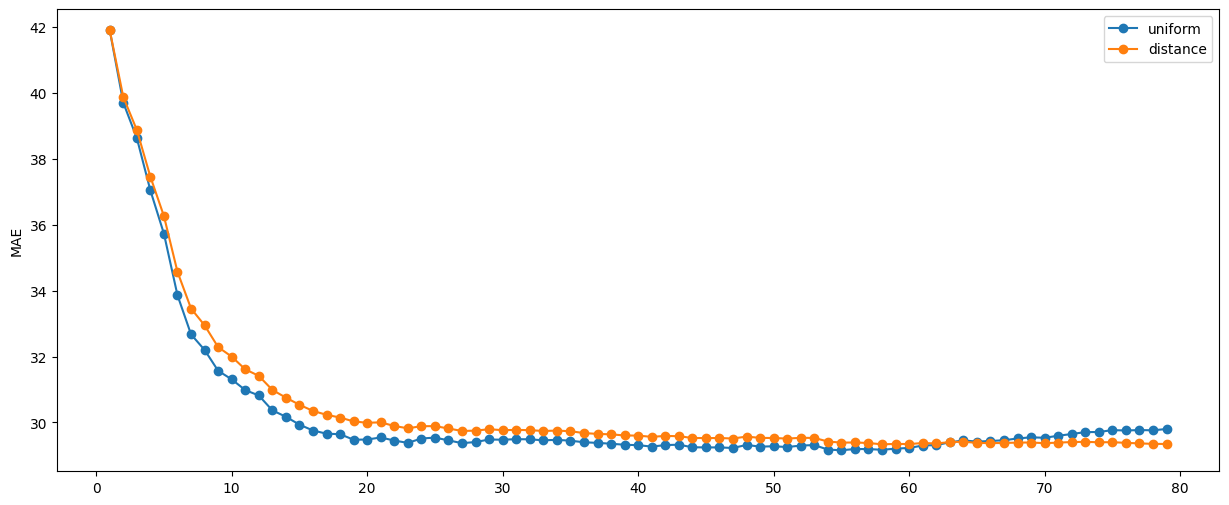

In [65]:
get_best_model_KNN(train_subtrain_selec, (1,80))

#### San Juan

Min Value uniform : 35.65029325513196 (62)
Min Value distance : 36.360463078760475 (62)


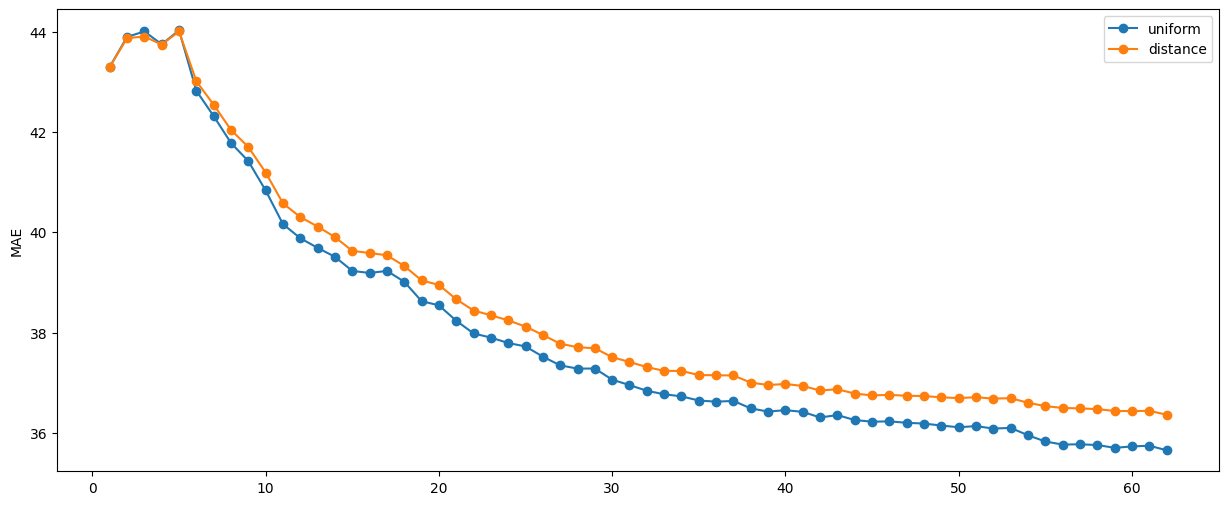

In [66]:
get_best_model_KNN(sj_train_subtrain_selec, (1,63))

#### Iquitos

Min Value uniform : 6.37871921182266 (35)
Min Value distance : 6.532348510083066 (35)


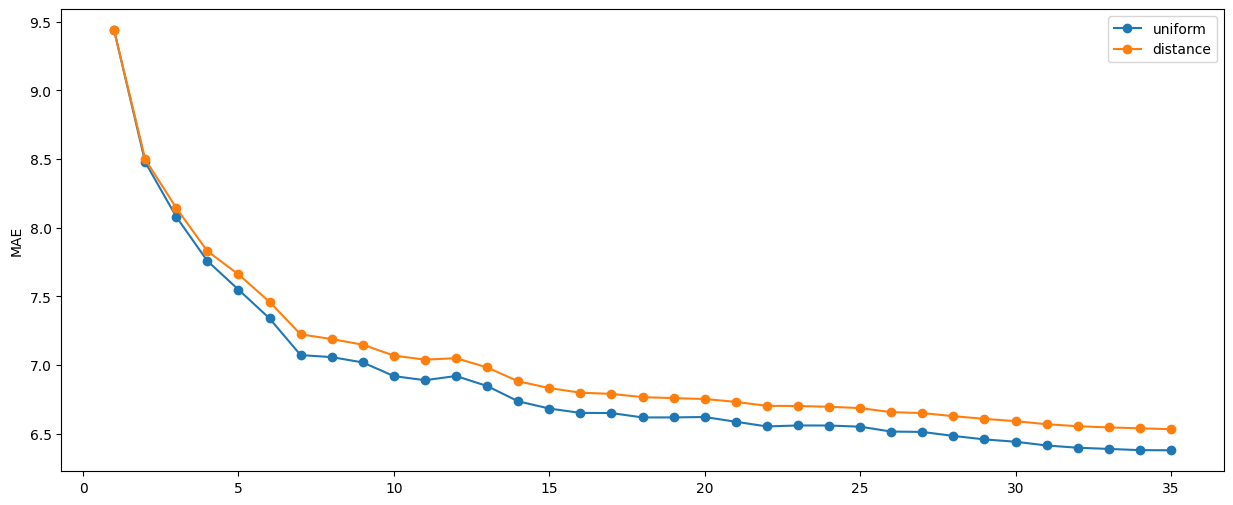

In [67]:
get_best_model_KNN(iq_train_subtrain_selec, (1,36))

##### *NOTA*
Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62], num_elements=63

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35], num_elements=36

### Construcción y ejecución del modelo

La mejor parametrización es la siguiente:
* Total:
  * Pesos: uniform
  * Número de muestras (vecinos más cercanos): 55

* San Juan:
  * Pesos: uniform
  * Número de muestras: 62
* Iquitos:
  * Pesos: uniform
  * Número de muestras: 35

El número de muestras en los dataset 'San Juan' e 'Iquitos' no es un dato totalmente fiable, ya que es el último valor posible en el *range*. No se puede aumentar el range ya que en la primera iteración de Corss Validation se sale del índice.

In [68]:
def KNN_model(train,test,n,weight):

  # constructor
  knn = KNeighborsRegressor(n_neighbors= n, weights=weight)

  # fit and predict
  fitted_model = knn.fit( X = train.drop(['total_cases'], axis=1), y = train['total_cases'])
  y_pred = knn.predict(X = test.drop(['total_cases'], axis = 1))
  mae = mean_absolute_error(test['total_cases'], y_pred)
  print ('MAE', mae)

  # x axis for plotting
  plt.figure(figsize=(15, 6))
  xx = np.stack(i for i in range(test['total_cases'].shape[0]))
  plt.plot(xx, test['total_cases'], c='r', label='data')
  #plt.plot(xx, y, c='k', label='data')
  plt.plot(xx, y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n,weight))

  plt.show()

  return fitted_model

#### Dataset conjunto

*NOTA:* Tras realizar todo el análisis de KNN, el siguiente modelo se ha considerado el más eficiente. Es por ello por lo que se ha establecido como 'KNN_best_model'.

MAE 14.715920177383593


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


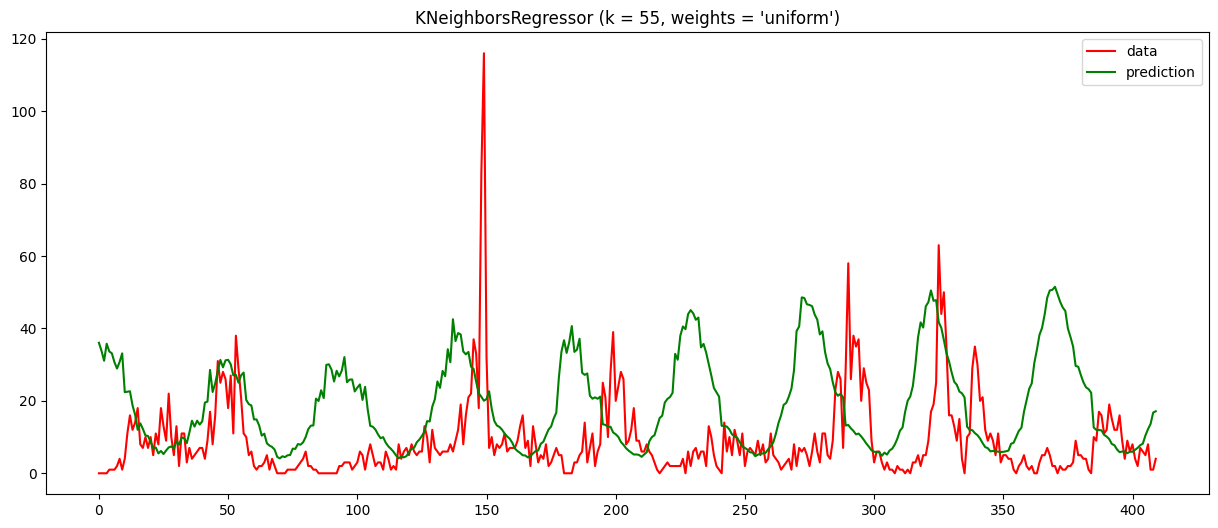

In [69]:
KNN_best_model = KNN_model(train_subtrain_selec, train_subtest_selec, 55, 'uniform')

Al utilizar el dataset con la selección de características realizada, se ha obtenido un MAE bastante razonable (14.72). Sin embargo, en este caso no estamos considerando las diferentes localizaciones.

Por su parte, el gráfico también muestra una buena predicción.

#### San Juan

MAE 21.574471635150168


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


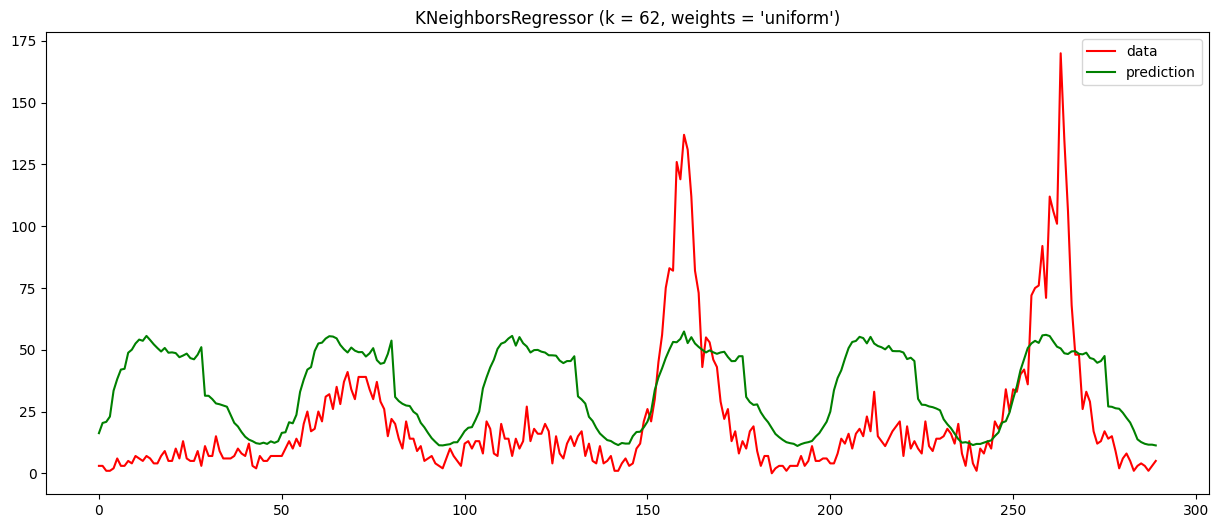

KNeighborsRegressor(n_neighbors=62)

In [70]:
KNN_model(sj_train_subtrain_selec, sj_train_subtest_selec, 62, 'uniform')

En cuanto al datset de San Juan, habiendo utilizado las características seleccionadas, el error obtenido es de 21.45, por lo que, aproximadamente  fallaría en 1 de 4 predicciones. Además, tal y como se ha especificado en la parametrización, el número de muestras establecido como hiperparámetro no parece ser del todo fiable.

#### Iquitos

MAE 6.160882893930104


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


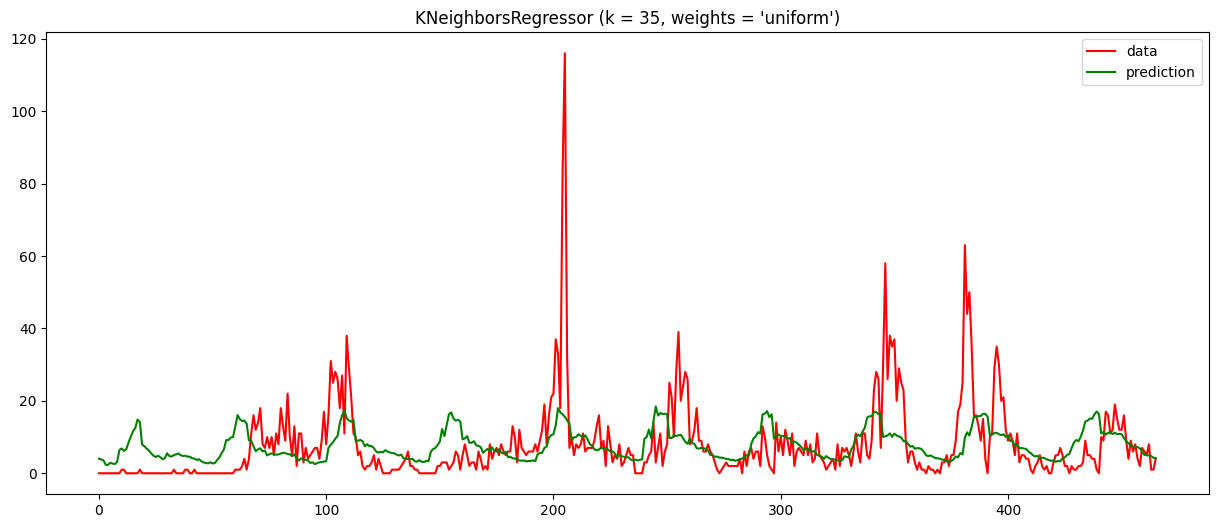

KNeighborsRegressor(n_neighbors=35)

In [71]:
KNN_model(iq_train_subtrain_selec, iq_train_subtest_selec, 35, 'uniform')

En Iquitos, aunque el error obtenido haya sido bastante aceptable (6.79), en el gráfico se puede ver que las predicciones no se acaban adaptando a los 'picos' de los datos reales. Además, en cuanto al hiperparámetro 'n_neighbors' se refiere, este dato tampoco parece ser muy fiable.

### Modelo con el dataset NO reducido (Parametrización y construcción del modelo)

#### San Juan

Min Value uniform : 35.68026392961877 (62)
Min Value distance : 36.25984740381564 (62)


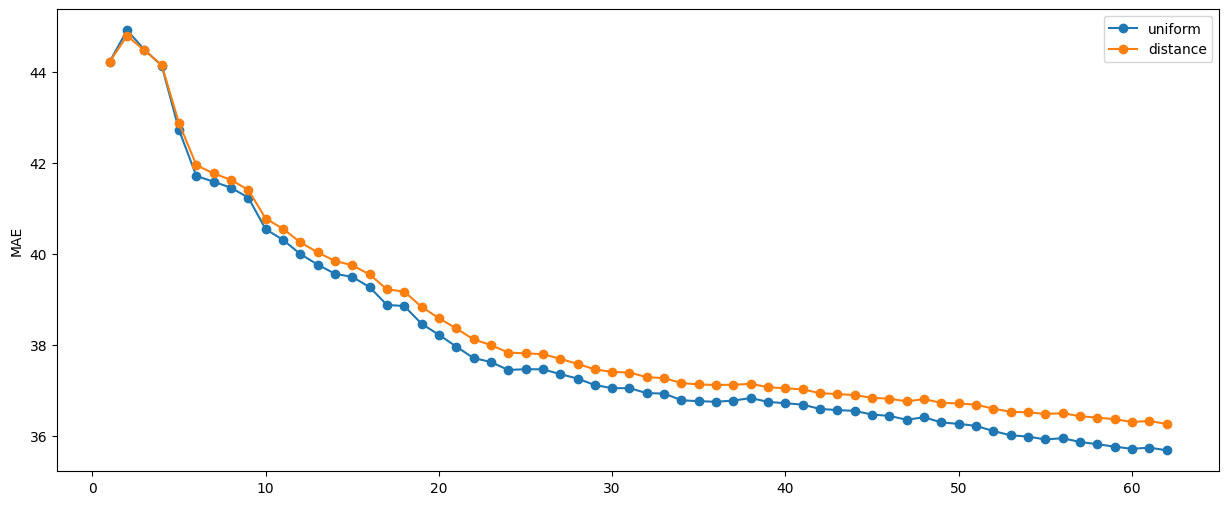

In [72]:
get_best_model_KNN(sj_train_subtrain, (1,63))

MAE 21.45


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


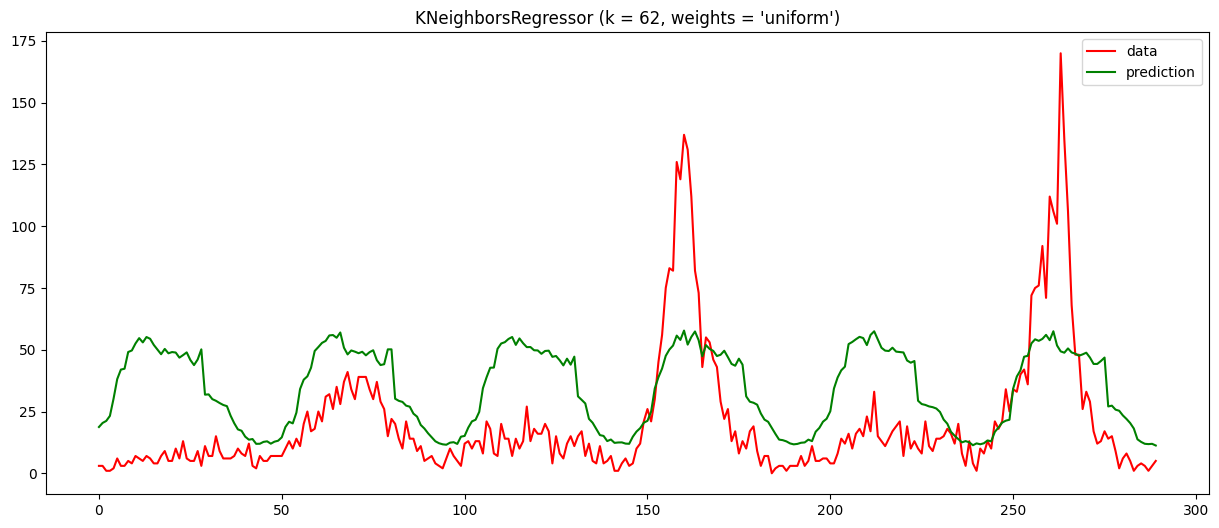

KNeighborsRegressor(n_neighbors=62)

In [73]:
KNN_model(sj_train_subtrain, sj_train_subtest, 62, 'uniform')

#### Iquitos

Min Value uniform : 6.389950738916257 (35)
Min Value distance : 6.48569011539562 (35)


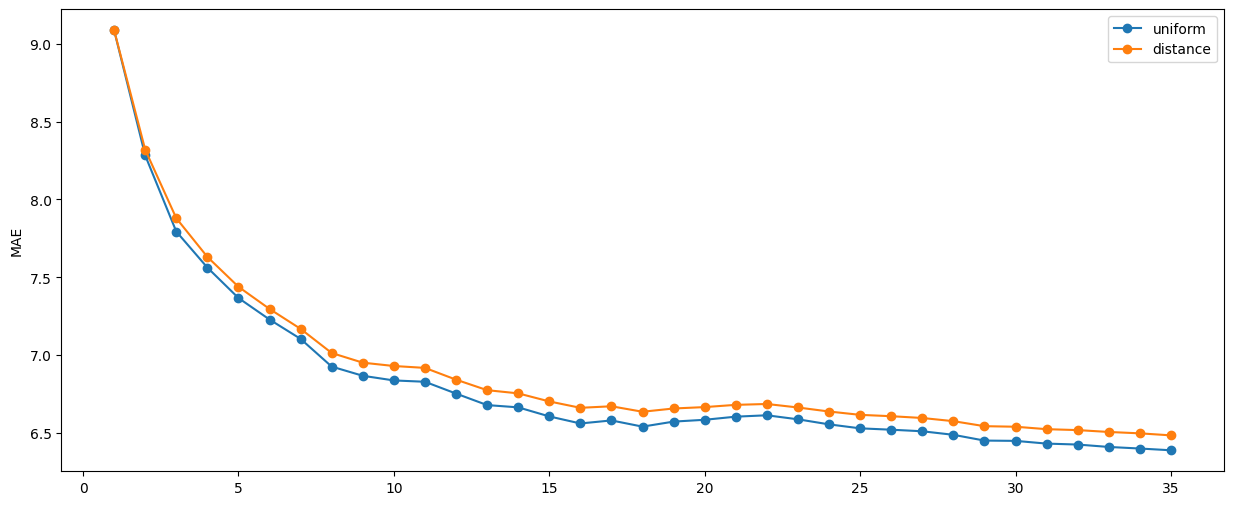

In [74]:
get_best_model_KNN(iq_train_subtrain, (1,36))

MAE 6.791894630192503


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


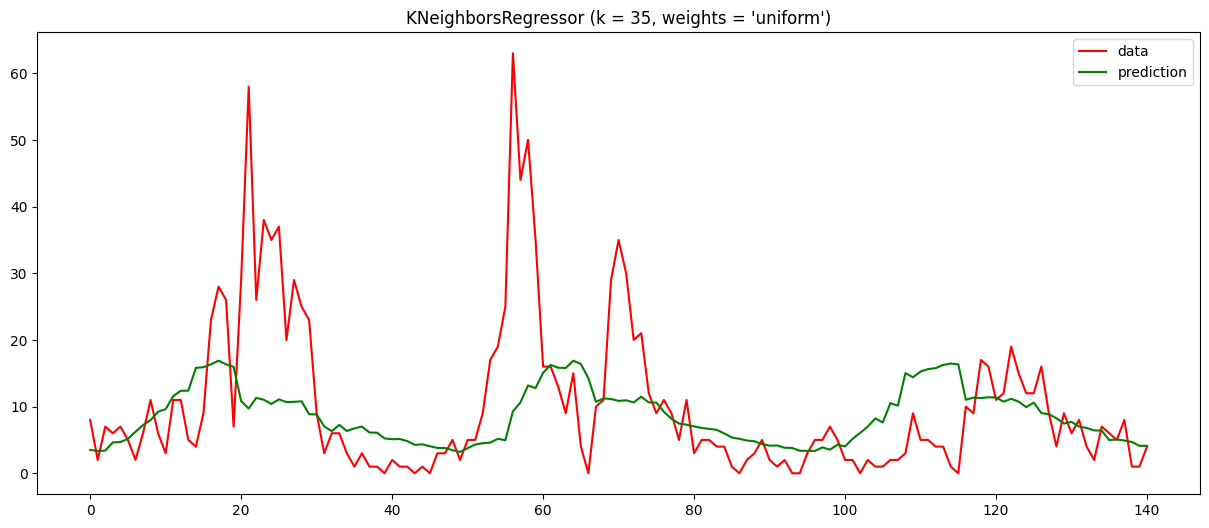

KNeighborsRegressor(n_neighbors=35)

In [75]:
KNN_model(iq_train_subtrain, iq_train_subtest, 35, 'uniform')

Los resultados son similares a los resultados obtenidos con el dataset reducido a las variables seleccioandas. Además, el tiempo de ejecución es un poco mayor.

### DRIVEN DATA score

Tras analizar los resultados, en este caso se ha decidido optar por realizar la predicción con el dataset *test* sin dividir por localizaciones, ya que el error MAE es menor.



In [76]:
KNN_predictions = KNN_best_model.predict(X=test_selec)

In [77]:
# Redondear el resultado y convertirlo a entero
KNN_pred = np.rint(KNN_predictions) # round
KNN_pred = KNN_pred.astype(int) # cast to int
KNN_res = np.hstack(KNN_pred) #aplilamiento horizontal

In [78]:
print(len(KNN_res))

416


In [79]:
#download_predictions(test_descarga,KNN_res)

## Árbol de decisión

El árbol de decisión es un algoritmo de aprendizaje automático que construye un modelo de predicción en forma de árbol. En este modelo, cada nodo interno representa una característica o atributo, cada rama representa una posible decisión o resultado, y cada hoja representa una etiqueta de clasificación. El árbol se construye dividiendo recursivamente los datos de entrenamiento en función de las características más relevantes, de manera que se maximice la pureza de las clases en cada subconjunto.

### Parametrización

En este caso, se utilizará la clase *DecisionTreeRegressor* del módulo *sklearn.tree*. Los parámetros que se pueden configurar a la hora de realizar la validación cruzada son los siguientes:

* **criterion:** Función para medir la calidad de una división (“squared_error”, “friedman_mse”, “absolute_error”, “poisson”)
* **splitter:** Estrategia utilizada para seleccionar la división de cada nodo ("best" o "random")
* **max_depth:** Controla la profundidad máxima del árbol de decisión. Limitar la profundidad puede ayudar a eviar  el sobreajuste.
* **min_samples_split:** Especifica el número mínimo de muestras requeridas para dividir un nodo interno.
* **min_samples_leaf:** Especifica el número mínimo de muestras para formar una hoja.
* **min_weight_fraction_leaf:** Especifica la fracción mínima ponderada de la suma total de peso de las muestras necesarias en una hoja.
* **random_state:** Determina la semilla utilizada por el generador de números aleatorios para mezclar los datos antes de cada división. **Proporcionar un valor fijo garantiza que los resultados sean reproducibles**
* **max_leaft_nodes:** Controla el número máximo de hojas en el árbol.
* **min_impurity_decrease:** Para realizar la poda (*Minimal Cost-Complexity Pruning*). Un nodo se dividirá si esta división induce una disminución de la impureza mayor o igual que el valor proporcionado.

In [80]:
from sklearn.tree import DecisionTreeRegressor # A decision tree regressor.

def get_best_model_tree (train, depth_max, min_split):

  # Resetear el índice del DataFrame
  train.reset_index(drop=True, inplace=True)

  # Instancia de la clase TimeSeriesSplit con 10 subconjuntos
  cv = TimeSeriesSplit(n_splits = 10)

  # Validación cruzada: Encontrar los mejores hiperparámetros

  # Hiperparámetros A que se van a validar:
  criterion_list = ['squared_error', 'poisson']
  # squared_error (error cuadrático): Es el criterio más comúnmente utilizado.  El MSE penaliza más los errores grandes y es sensible a los valores atípicos. Este criterio es adecuado para problemas de regresión estándar donde el objetivo es minimizar el MSE.
  # poisson:  Este criterio se utiliza específicamente para problemas de regresión de conteo cuando el objetivo es ajustar un modelo de regresión de Poisson. Es adecuado cuando los valores objetivo son no negativos y siguen una distribución de Poisson

  plt.figure(figsize=(15, 6))

  for crit in criterion_list:
    total_scores = [] # En esta lista se va guardar el MAE promedio de cada Cross Validation realizado por parámetro probado

    for depth in range(2, depth_max): # Hiperparámetro que se va a validar: Profundidad máxima del árbol
      fold_accuracy = [] # Lista donde se va a guardar el MAE de cada interación de Cross Validation
      regressor = DecisionTreeRegressor(criterion=crit, max_depth=depth, min_samples_split=min_split, min_samples_leaf=1, random_state=0) #Instancia de DecisionTreeRegressor
      # Se ha configurado min_samples_split=5 para evitar el sobreajuste y mejorar la capacidad de generalización del modelo.
      # Se evitan divisiones demasiado pequeñas, se reduce la complejiad del moelo y se ahorra tiempo de entrenamiento

      for train_index, test_index in cv.split(train):

        # División train test aleatoria
        f_train = train.loc[train_index]
        f_test = train.loc[test_index]

        # Entrenamiento del modelo
        regressor.fit( X = f_train.drop(['total_cases'], axis=1), #Hay que eliminar la etiqueta para entenar el modelo
                y = f_train['total_cases']) # Entrenamiento
        y_pred = regressor.predict(X = f_test.drop(['total_cases'], axis = 1)) # Predicción con el modelo entrenado

        # Evaluación del modelo
        mae = mean_absolute_error(f_test['total_cases'], y_pred)
        fold_accuracy.append(mae)

      total_scores.append(sum(fold_accuracy)/len(fold_accuracy)) #Se normaliza el resultado y se guarda el resultado promedio de la Validación Cruzada

    plt.plot(range(1,len(total_scores)+1), total_scores,
              marker='o', label=crit) #marker = 'o' --> Para marcar los puntos en una gráfica con un círculo
    print ('Min Value ' + crit + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 2) + ")")
    plt.ylabel('MAE')

  plt.legend()
  plt.show()

#### Dataset conjunto

Min Value squared_error : 38.66288567719853 (2)
Min Value poisson : 42.635437768789075 (2)


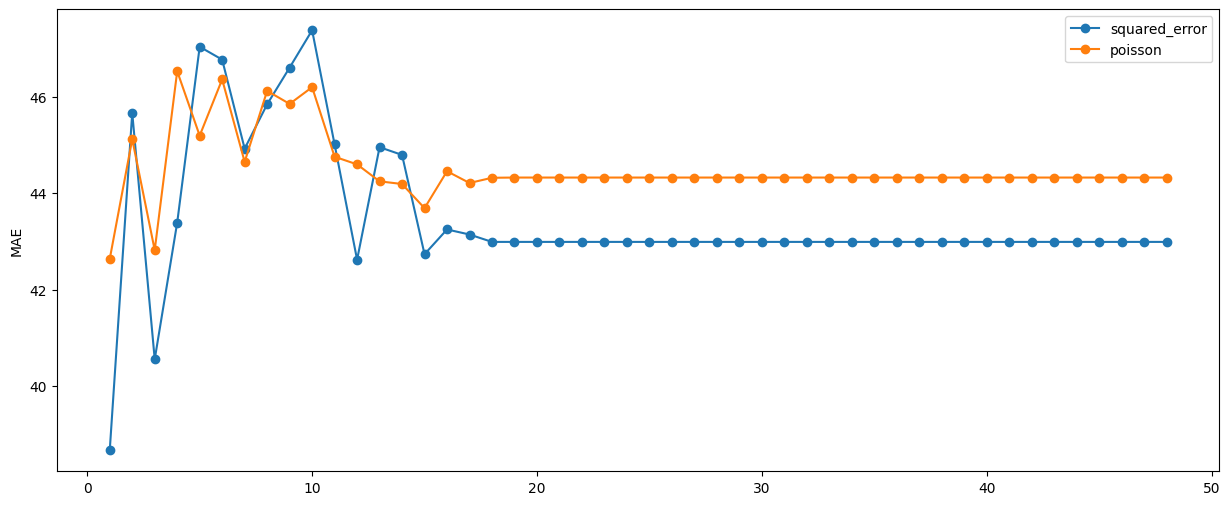

In [81]:
get_best_model_tree (train_subtrain_selec_noNorm, 50, 5)

#### San Juan

Min Value squared_error : 38.214863254392654 (10)
Min Value poisson : 37.13660706670518 (3)


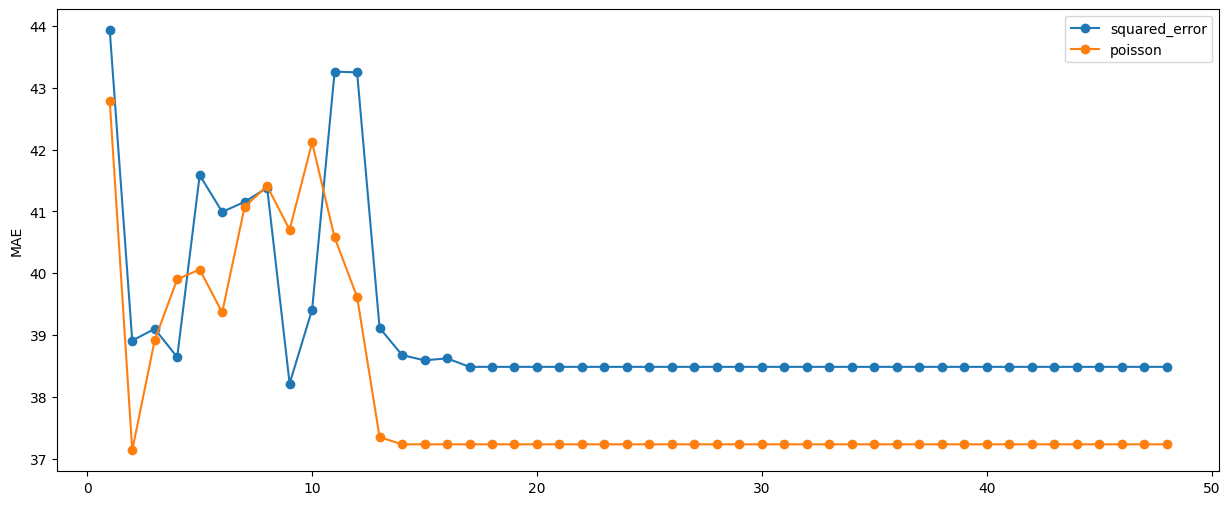

In [82]:
get_best_model_tree (sj_train_subtrain_noNorm, 50, 5)

Min Value squared_error : 34.878329985740216 (4)
Min Value poisson : 37.359703630747205 (3)


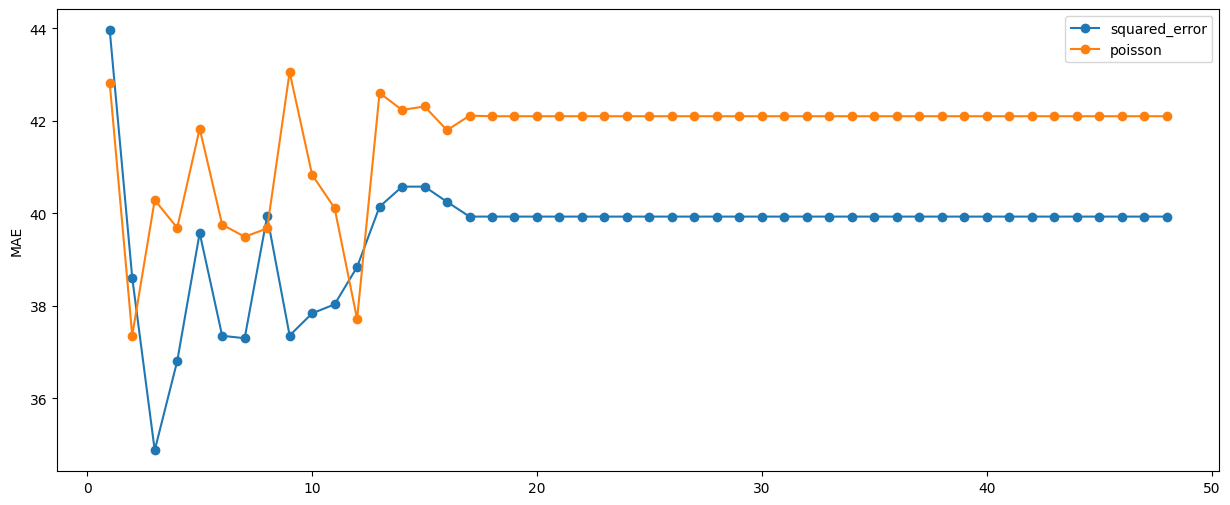

In [83]:
get_best_model_tree (sj_train_subtrain_selec_noNorm, 50, 5)

#### Iquitos

Min Value squared_error : 6.861028835631181 (2)
Min Value poisson : 7.046319167041299 (2)


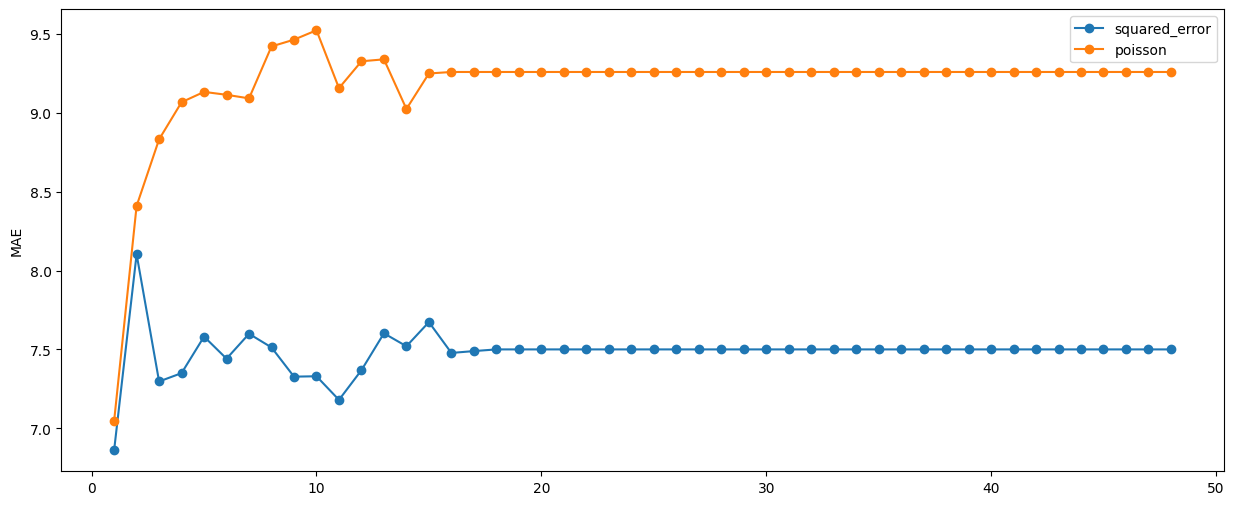

In [84]:
get_best_model_tree (iq_train_subtrain_noNorm, 50, 5)

Min Value squared_error : 6.8456459162928995 (5)
Min Value poisson : 7.005589835520891 (2)


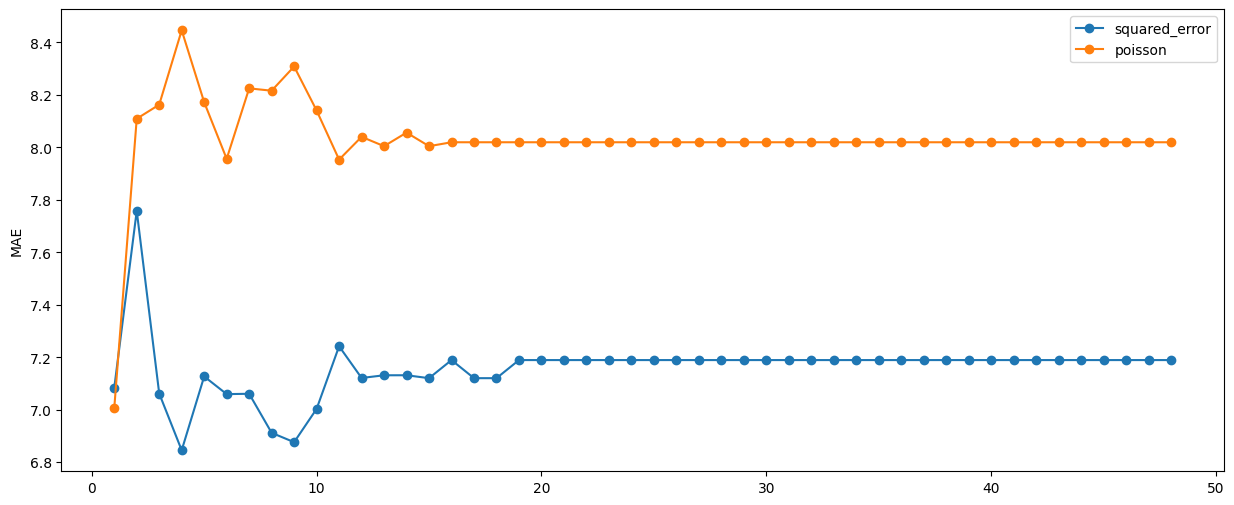

In [85]:
get_best_model_tree (iq_train_subtrain_selec_noNorm, 50, 5)

Los errores obtenidos tanto con los dataset con las características seleccionadas como con los dataset enteros son muy similares. Tras analizar los errores, esta es la mejor parametrización:

### Construcción y ejecución del modelo

La mejor parametrización es la siguiente:

* Sin dividir (con selección):
  * MAE: 38.66 (con 2 niveles)
  * Criterio: squared_error
  * Profundidad: 4 (Se ha optado por no utilizar un árbol de 2 niveles)
  * min_samples_split: 5
* San Juan (con selección)
  * MAE: 34.88
  * Criterio: squared_error
  * Profundidad: 4
  * min_samples_split: 5
* Iquitos (con selección)
  * MAE: 6.85
  * Pesos: squared_error
  * Profundidad: 5
  * min_samples_split: 5

In [86]:
def tree_model(train,test,criterion_select='poisson',splitter_select='best',depth=None,min_split=2,min_leaf=1):

  from sklearn.tree import plot_tree # Plot a decision tree.

  # constructor
  regressor = DecisionTreeRegressor(criterion=criterion_select, splitter=splitter_select, max_depth=depth, min_samples_split=min_split, min_samples_leaf=min_leaf, random_state=0)

  # fit and predict
  fitted_model = regressor.fit( X = train.drop(['total_cases'], axis=1), y = train['total_cases'])
  y_pred = regressor.predict(X = test.drop(['total_cases'], axis = 1))
  mae = mean_absolute_error(test['total_cases'], y_pred)
  print ('MAE', mae)

  # x axis for plotting
  plt.figure(figsize=(15, 6))
  xx = np.stack(i for i in range(test['total_cases'].shape[0]))
  plt.plot(xx, test['total_cases'], c='r', label='data')
  #plt.plot(xx, y, c='k', label='data')
  plt.plot(xx, y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  if depth==None:
    plt.title("DecissionTreeRegressor (max_depth = %s, min_samples_split = %i, criterion = %s)" % (depth, min_split, criterion_select))
  else:
    plt.title("DecissionTreeRegressor (max_depth = %i, min_samples_split = %i, criterion = %s)" % (depth, min_split, criterion_select))
  plt.show()

  # tree plotting
  plt.figure(figsize=(15, 6))
  plot_tree(regressor)
  plt.show()

  return fitted_model


#### Dataset conjunto

MAE 8.629255677039529


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


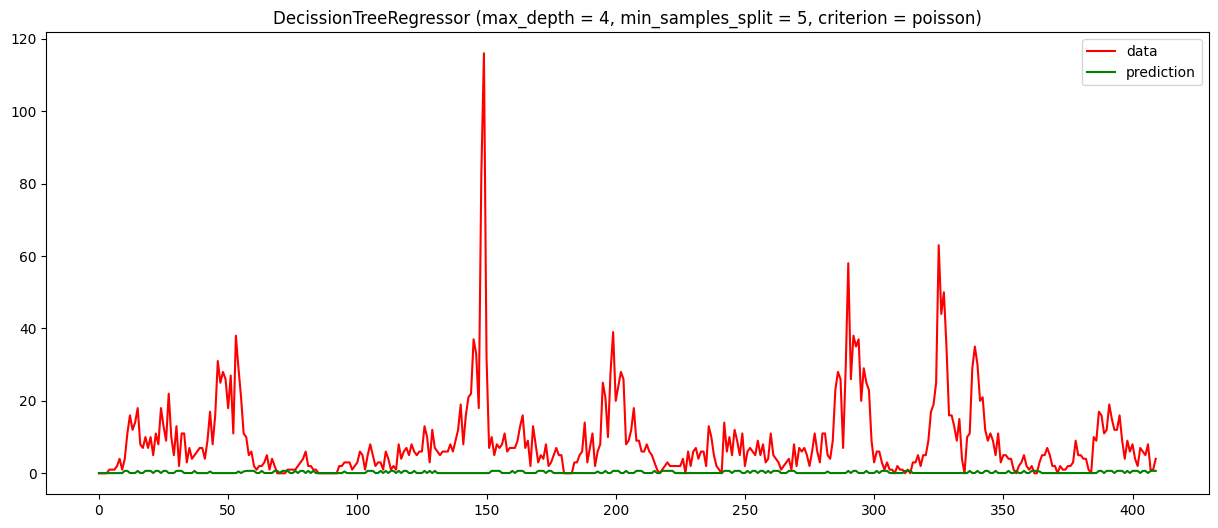

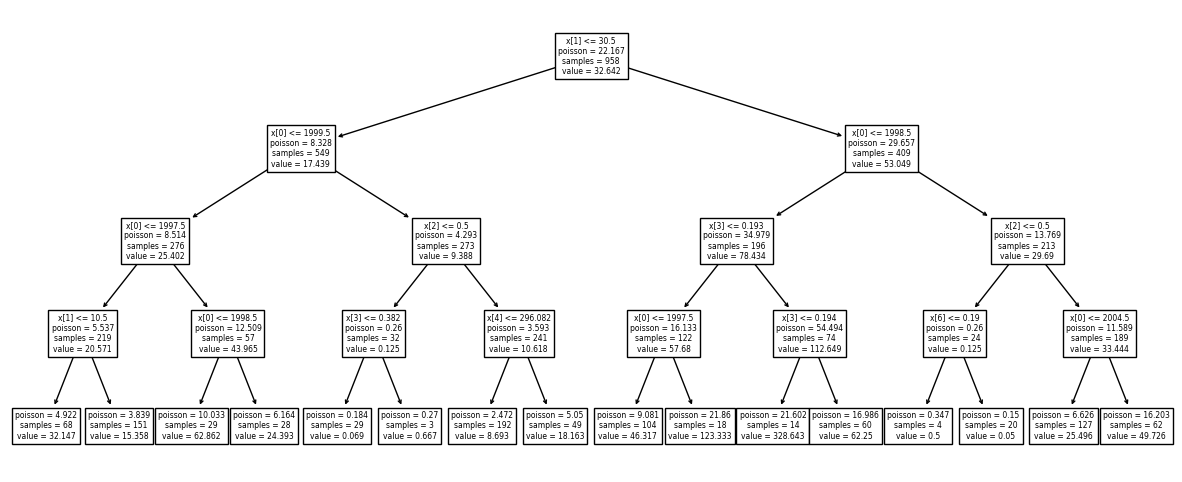

DecisionTreeRegressor(criterion='poisson', max_depth=4, min_samples_split=5,
                      random_state=0)

In [87]:
tree_model(train_subtrain_selec_noNorm,train_subtest_selec_noNorm,depth=4,min_split=5)

#### San Juan

MAE 21.20602900930487


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


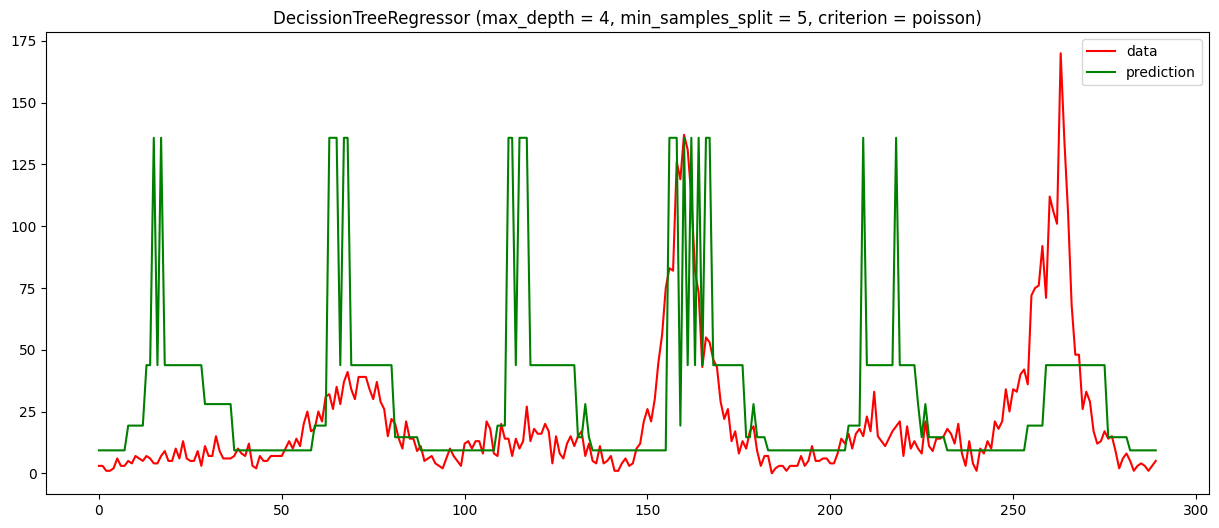

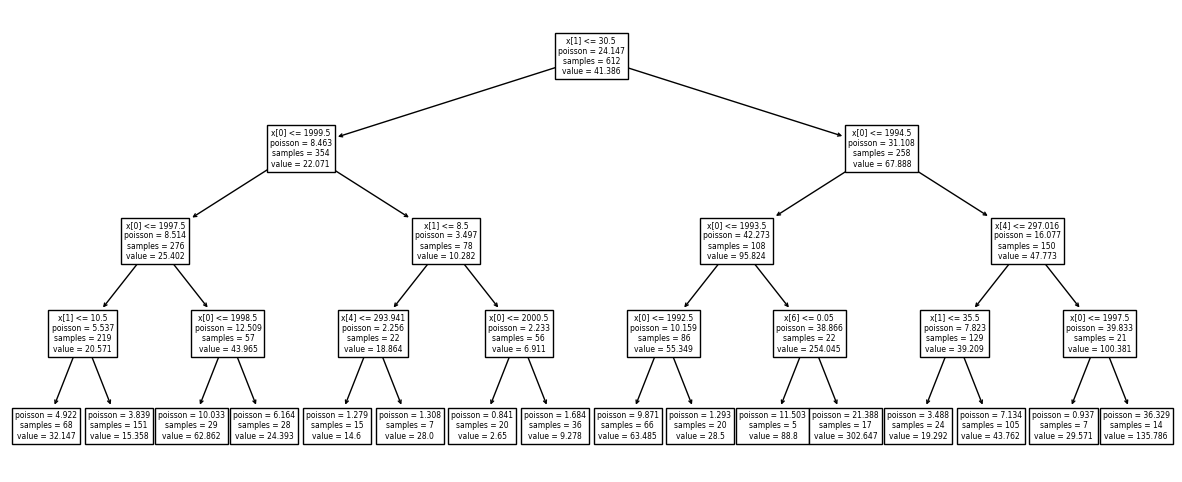

DecisionTreeRegressor(criterion='poisson', max_depth=4, min_samples_split=5,
                      random_state=0)

In [88]:
tree_model(sj_train_subtrain_selec_noNorm,sj_train_subtest_selec_noNorm,depth=4,min_split=5)

MAE 19.934654790325713


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


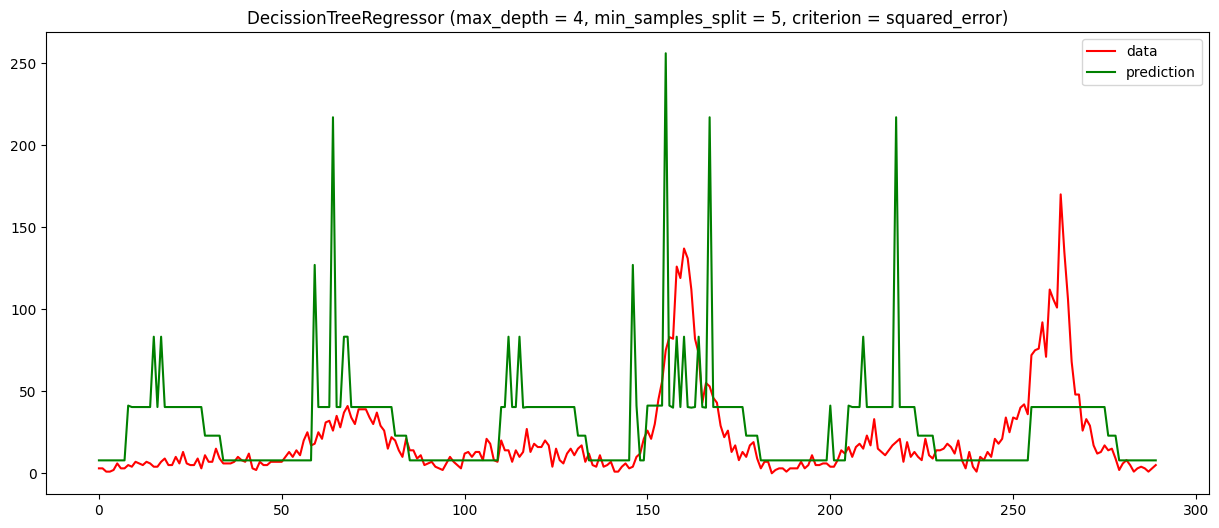

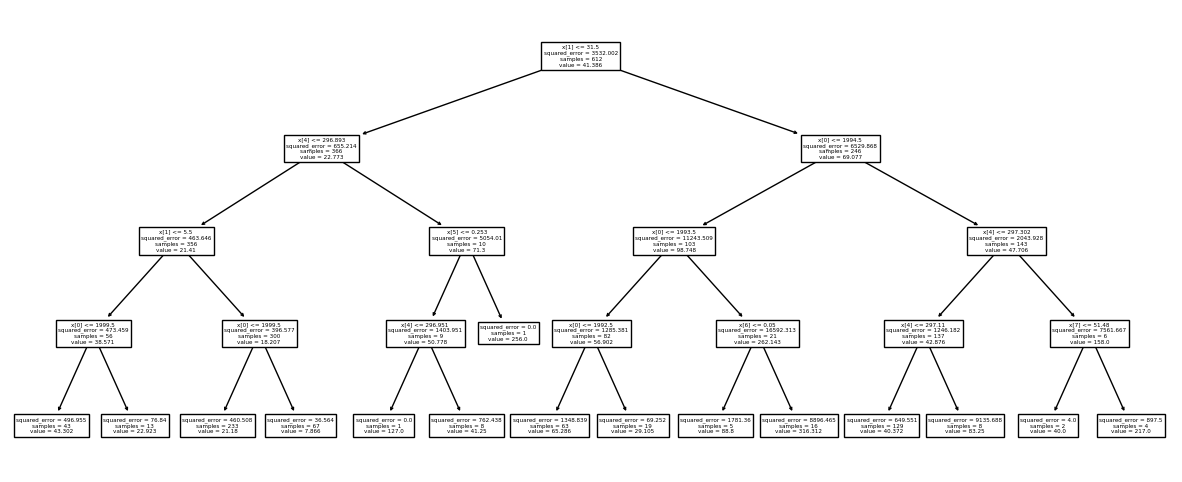

DecisionTreeRegressor(max_depth=4, min_samples_split=5, random_state=0)

In [89]:
tree_model(sj_train_subtrain_selec_noNorm,sj_train_subtest_selec_noNorm,'squared_error',depth=4,min_split=5)

#### Iquitos

MAE 7.266351457840821


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


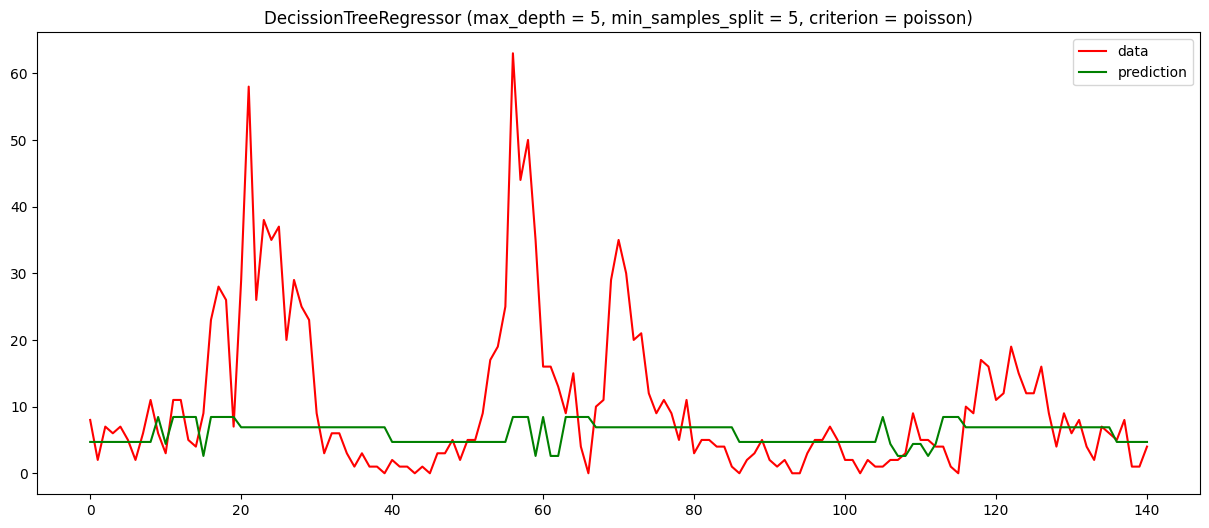

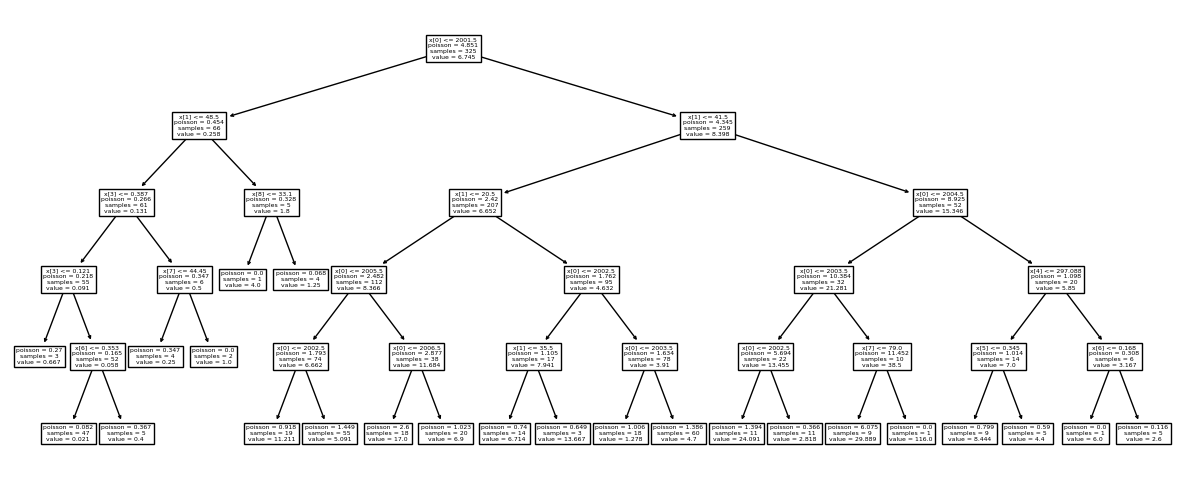

DecisionTreeRegressor(criterion='poisson', max_depth=5, min_samples_split=5,
                      random_state=0)

In [90]:
tree_model(iq_train_subtrain_selec_noNorm,iq_train_subtest_selec_noNorm,depth=5,min_split=5)

MAE 7.969209552188275


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


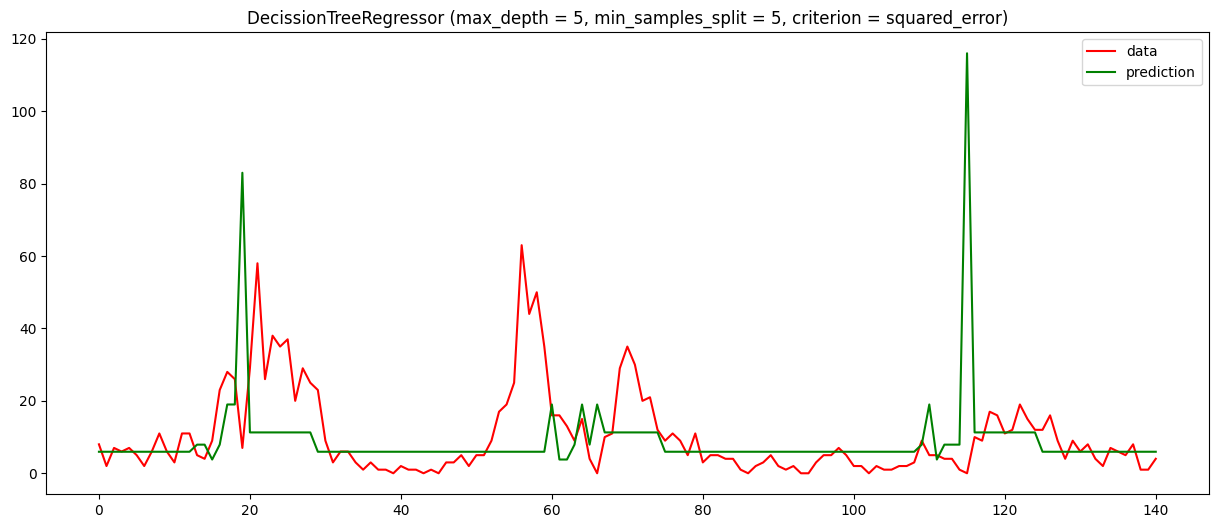

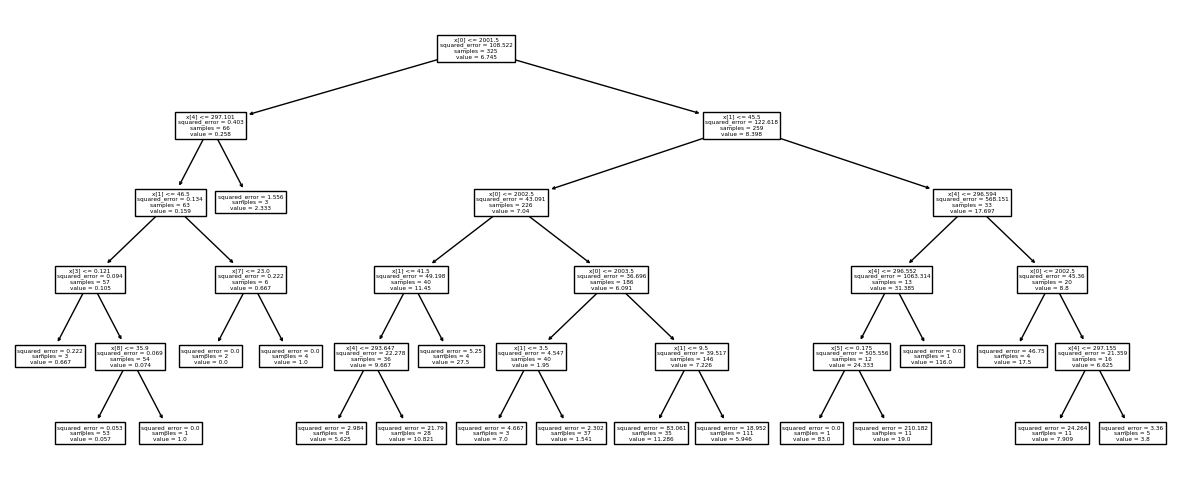

DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=0)

In [91]:
tree_model(iq_train_subtrain_selec_noNorm,iq_train_subtest_selec_noNorm,'squared_error',depth=5,min_split=5)

El modelo se ha ejecutado tanto con 'squared error' como con 'poisson' para ver si había diferencias notorias. Se va a emplear Grid search para poder ajustar los parámetros más comunes del árbol de decisión de manera más detallada.

### Ajuste de los hiperparámetros mediante Grid search

Los hiperparámetros más comunes a la hora de parametrizar el modelo 'DecisionTreeRegressor' son los siguientes:

* **spliter:** Se van a probar ambas.

* **max_depth:** La profundidad máxima del árbol puede controlar la complejidad del modelo. Se establecerá [1, 3, 5, 7, 9, 10, 15]. 'None' representa la profundidad no restringida y los valores enteros representan profundidades específicas. Cuanto más bajo sea el valor, más más simple será el árbol y menos propenso al sobreajuste.

* **min_samples_split** y **min_samples_leaf**: Estos hiperparámetros influyen en la cantidad mínima de muestras requeridas para realizar una división en un nodo interno y para considerar un nodo como una hoja, respectivamente. Valores más bajos permiten una mayor flexibilidad en la construcción del árbol, pero pueden aumentar el riesgo de sobreajuste. Valores más altos pueden generar árboles más simples, pero podrían no capturar adecuadamente las variaciones en los datos. En el contexto del dengue, donde los datos son bastante limitados, se van a considerar rangos más bajos para permitir divisiones y hojas más pequeñas: [(1), 2, 3, 5, 7, 10].

In [92]:
# Función empleada para imprimir las 100 mejores configuraciones

def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [93]:
from sklearn.metrics import get_scorer_names

scorer_names = get_scorer_names()
print(scorer_names)

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

#### San Juan

In [94]:
  from sklearn.model_selection import GridSearchCV

  # Definición de los hiperparámetros y rangos a explorar
  parameters = {'splitter':['best','random'],
                'criterion':['squared_error','poisson'],
                'max_depth': [1,3,5,7,9,10,15],
                'min_samples_split': [2, 3, 5, 7, 10],
                'min_samples_leaf': [1, 2, 3, 5, 7, 10]}

  # Modelo de regresión
  regressor_tree = DecisionTreeRegressor(random_state=0)

  # Crear el objeto GridSearchCV
  sj_grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, scoring='neg_mean_absolute_error',cv=5)
  #grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, cv=5)

  #Ajustar el modelo con los datos de entrenamiento
  sj_grid_search_tree.fit(X = sj_train_subtrain_selec_noNorm.drop(['total_cases'], axis=1), y = sj_train_subtrain_selec_noNorm['total_cases'])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['squared_error', 'poisson'],
                         'max_depth': [1, 3, 5, 7, 9, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error')

In [95]:
# Obtener los mejores hiperparámetros y el mejor puntaje
sj_best_params = sj_grid_search_tree.best_params_
sj_best_score = sj_grid_search_tree.best_score_

print("Mejores hiperparámetros encontrados:")
print(sj_best_params)
print("Mejor puntaje promedio de validación cruzada:")
print(sj_best_score)

Mejores hiperparámetros encontrados:
{'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Mejor puntaje promedio de validación cruzada:
-31.20897565198345


In [96]:
report(sj_grid_search_tree.cv_results_, n_top = 100)

Model with rank: 1
Mean validation score: -31.209 (std: 9.878)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}

Model with rank: 1
Mean validation score: -31.209 (std: 9.878)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}

Model with rank: 1
Mean validation score: -31.209 (std: 9.878)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}

Model with rank: 1
Mean validation score: -31.209 (std: 9.878)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7, 'splitter': 'best'}

Model with rank: 1
Mean validation score: -31.209 (std: 9.878)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}

Model with rank: 1
Mean validation score: -31.209

Como no tiene sentido que el árbol sea de una única profundidad, se ha elegido la siguiente configuración:
* Model with rank: 61
  * Mean validation score: -31.732 (std: 12.035)
  * Parameters: {'criterion': 'poisson', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}

MAE 18.0314998946287


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


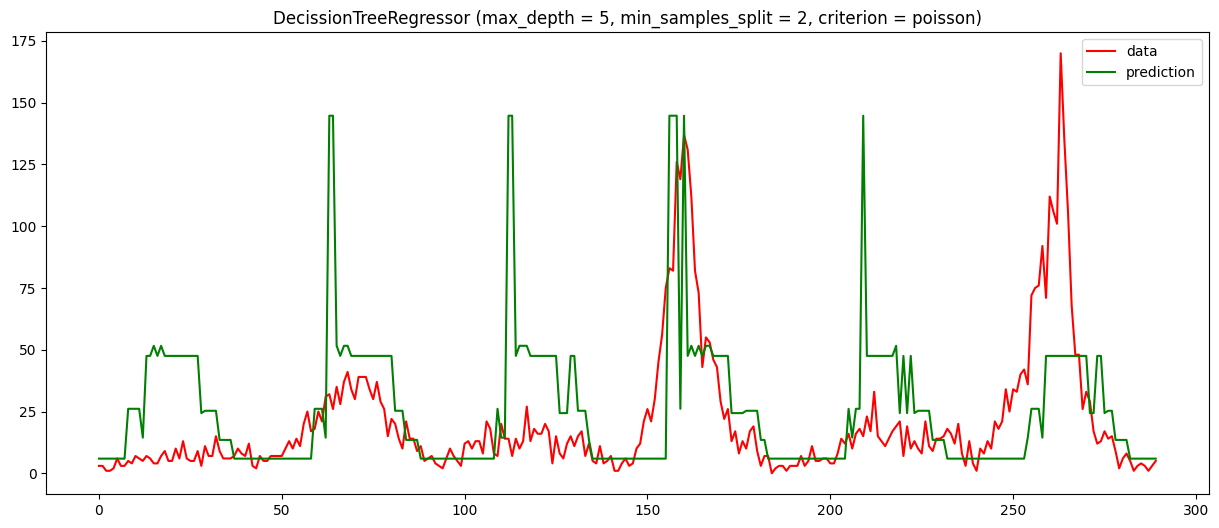

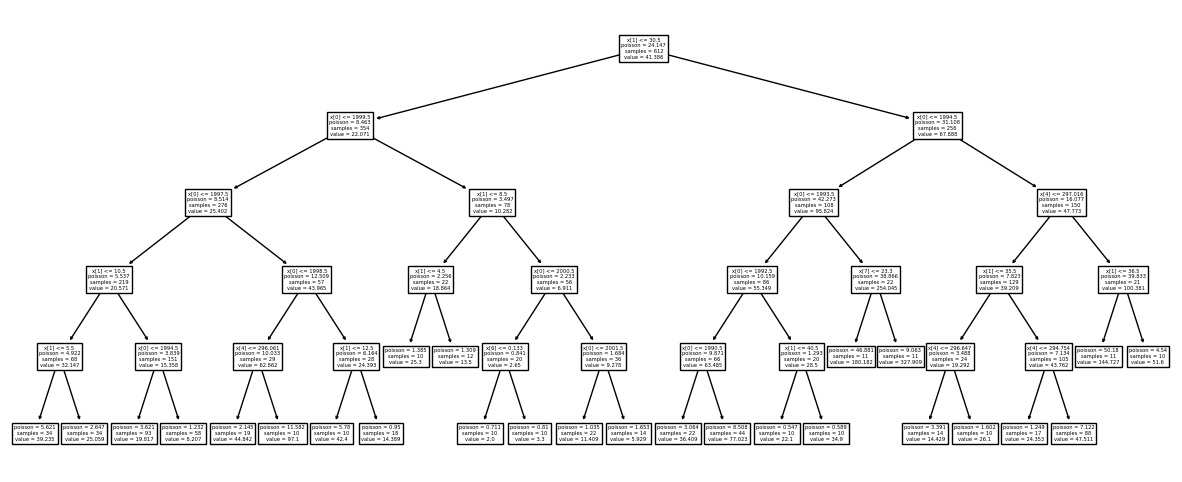

In [97]:
sj_tree_best_model = tree_model(sj_train_subtrain_selec_noNorm,sj_train_subtest_selec_noNorm,depth=5,min_split=2, min_leaf=10)

#### Iquitos

In [98]:
  from sklearn.model_selection import GridSearchCV

  # Definición de los hiperparámetros y rangos a explorar
  parameters = {'splitter':['best','random'],
                'criterion':['squared_error','poisson'],
                'max_depth': [1,3,5,7,9,10,15],
                'min_samples_split': [2, 3, 5, 7, 10],
                'min_samples_leaf': [1, 2, 3, 5, 7, 10]}

  # Modelo de regresión
  regressor_tree = DecisionTreeRegressor(random_state=0)

  # Crear el objeto GridSearchCV
  iq_grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, scoring='neg_mean_absolute_error',cv=5)
  #grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, cv=5)

  #Ajustar el modelo con los datos de entrenamiento
  iq_grid_search_tree.fit(X = iq_train_subtrain_selec_noNorm.drop(['total_cases'], axis=1), y = iq_train_subtrain_selec_noNorm['total_cases'])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['squared_error', 'poisson'],
                         'max_depth': [1, 3, 5, 7, 9, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error')

In [99]:
# Obtener los mejores hiperparámetros y el mejor puntaje
iq_best_params = iq_grid_search_tree.best_params_
iq_best_score = iq_grid_search_tree.best_score_

print("Mejores hiperparámetros encontrados:")
print(iq_best_params)
print("Mejor puntaje promedio de validación cruzada:")
print(iq_best_score)

Mejores hiperparámetros encontrados:
{'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Mejor puntaje promedio de validación cruzada:
-6.8573362758418055


In [100]:
report(iq_grid_search_tree.cv_results_, n_top = 100)

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6

No se ha obtenido un 'max_depth' distinto de 1, por lo que se va a parametrizar 'poisson' y 'squared_error' por separado.

In [101]:
  from sklearn.model_selection import GridSearchCV

  # Definición de los hiperparámetros y rangos a explorar
  parameters = {'splitter':['best','random'],
                #'criterion':['squared_error','poisson'],
                'max_depth': [1,3,5,7,9,10,15],
                'min_samples_split': [2, 3, 5, 7, 10],
                'min_samples_leaf': [1, 2, 3, 5, 7, 10]}

  # Modelo de regresión
  regressor_tree = DecisionTreeRegressor(criterion='squared_error',random_state=0)

  # Crear el objeto GridSearchCV
  iq_grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, scoring='neg_mean_absolute_error',cv=5)
  #grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, cv=5)

  #Ajustar el modelo con los datos de entrenamiento
  iq_grid_search_tree.fit(X = iq_train_subtrain_selec_noNorm.drop(['total_cases'], axis=1), y = iq_train_subtrain_selec_noNorm['total_cases'])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error')

In [102]:
report(iq_grid_search_tree.cv_results_, n_top = 100)

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 1
Mean validatio

In [103]:
  from sklearn.model_selection import GridSearchCV

  # Definición de los hiperparámetros y rangos a explorar
  parameters = {'splitter':['best','random'],
                #'criterion':['squared_error','poisson'],
                'max_depth': [1,3,5,7,9,10,15],
                'min_samples_split': [2, 3, 5, 7, 10],
                'min_samples_leaf': [1, 2, 3, 5, 7, 10]}

  # Modelo de regresión
  regressor_tree = DecisionTreeRegressor(criterion='poisson',random_state=0)

  # Crear el objeto GridSearchCV
  iq_grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, scoring='neg_mean_absolute_error',cv=5)
  #grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, cv=5)

  #Ajustar el modelo con los datos de entrenamiento
  iq_grid_search_tree.fit(X = iq_train_subtrain_selec_noNorm.drop(['total_cases'], axis=1), y = iq_train_subtrain_selec_noNorm['total_cases'])

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(criterion='poisson',
                                             random_state=0),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error')

In [104]:
report(iq_grid_search_tree.cv_results_, n_top = 100)

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -6.857 (std: 2.234)
Parameters: {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 1
Mean validatio

* criterion='squared_error'
  * Model with rank: 61
  * Mean validation score: -8.707 (std: 3.297)
  * Parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
* criterion='poisson'
  * Model with rank: 31
  * Mean validation score: -7.452 (std: 2.033)
  * Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}

Se empleará 'poisson' como criterio

MAE 8.673758865248226


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


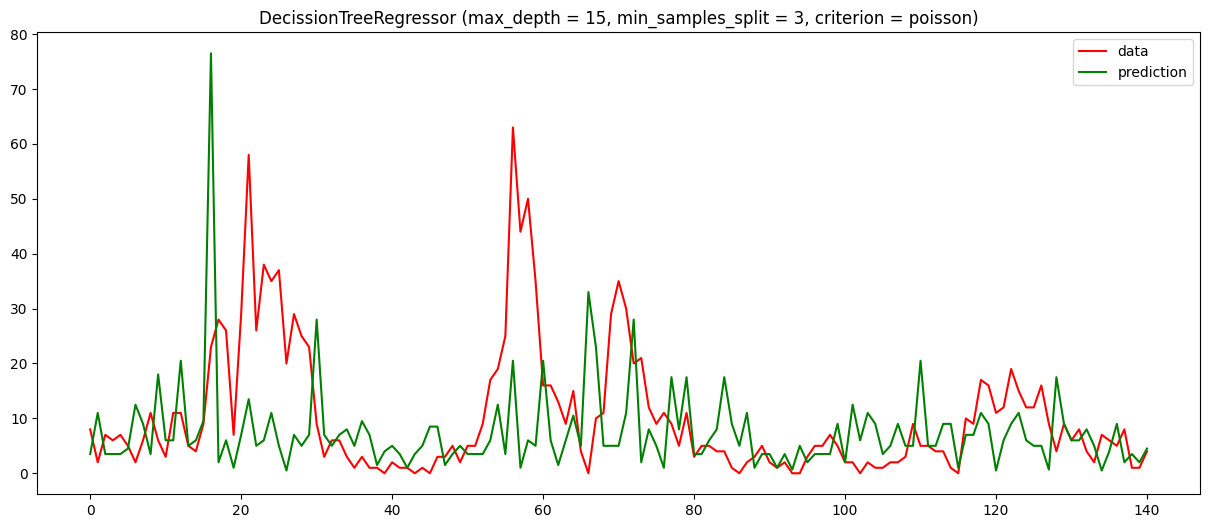

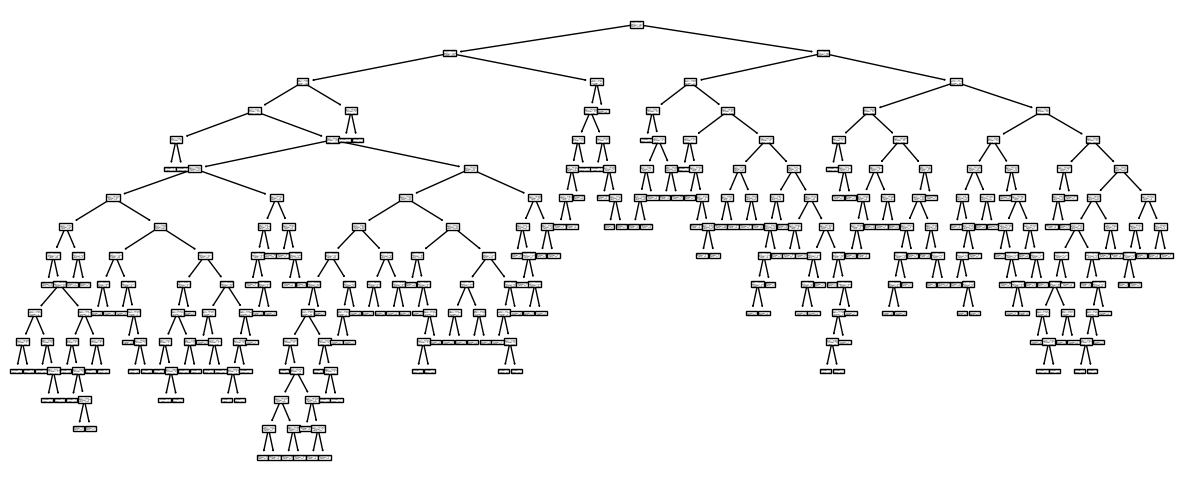

In [105]:
iq_tree_best_model = tree_model(iq_train_subtrain_selec_noNorm,iq_train_subtest_selec_noNorm,splitter_select='random',depth=15,min_split=3, min_leaf=1)

#### Dataset conjunto

In [106]:
  from sklearn.model_selection import GridSearchCV

  # Definición de los hiperparámetros y rangos a explorar
  parameters = {'splitter':['best','random'],
                'max_depth': [1,3,5,7,9,10,15],
                'min_samples_split': [2, 3, 5, 7, 10],
                'min_samples_leaf': [1, 2, 3, 5, 7, 10]}

  # Modelo de regresión
  regressor_tree = DecisionTreeRegressor(criterion='poisson', random_state=0)

  # Crear el objeto GridSearchCV
  grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, scoring='neg_mean_absolute_error',cv=5)
  #grid_search_tree = GridSearchCV(regressor_tree, param_grid = parameters, cv=5)

  #Ajustar el modelo con los datos de entrenamiento
  grid_search_tree.fit(X = train_subtrain_selec_noNorm.drop(['total_cases'], axis=1), y = train_subtrain_selec_noNorm['total_cases'])

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(criterion='poisson',
                                             random_state=0),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error')

In [107]:
# Obtener los mejores hiperparámetros y el mejor puntaje
best_params = grid_search_tree.best_params_
best_score = grid_search_tree.best_score_

print("Mejores hiperparámetros encontrados:")
print(best_params)
print("Mejor puntaje promedio de validación cruzada:")
print(best_score)

Mejores hiperparámetros encontrados:
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Mejor puntaje promedio de validación cruzada:
-26.440193252953076


In [108]:
report(grid_search_tree.cv_results_, n_top = 100)

Model with rank: 1
Mean validation score: -26.440 (std: 11.646)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -26.440 (std: 11.646)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -26.440 (std: 11.646)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -26.440 (std: 11.646)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -26.440 (std: 11.646)
Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}

Model with rank: 1
Mean validation score: -26.440 (std: 11.646)
Parameters: {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 1
Me

Como no tiene sentido utilizar un árbol con una única profundidad, se ha elegido la siguiente configuración:
* Model with rank: 31
  * Mean validation score: -29.318 (std: 13.811)
  * Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

MAE 8.541968040370058


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


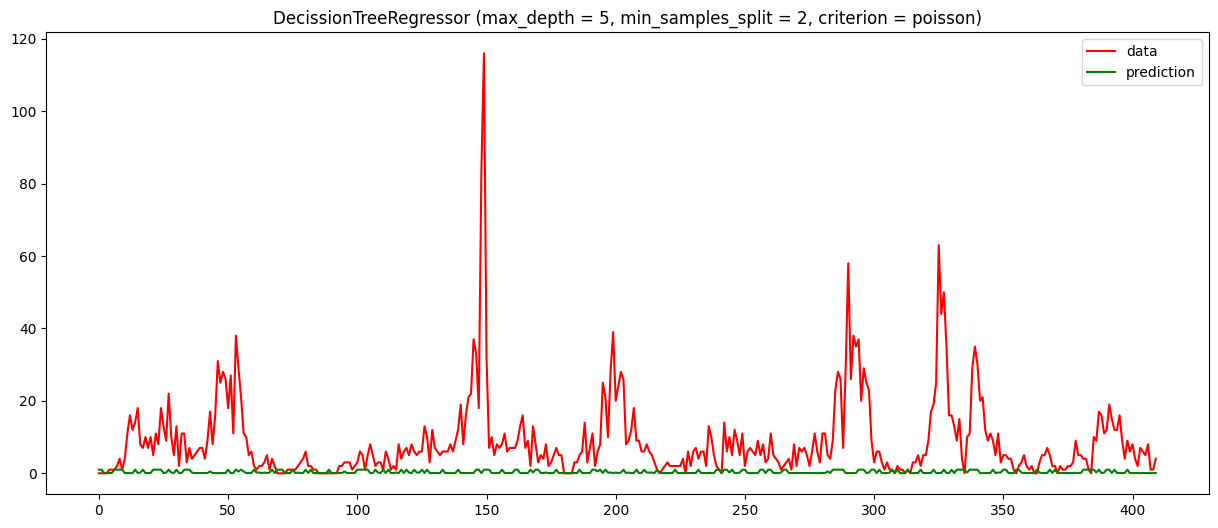

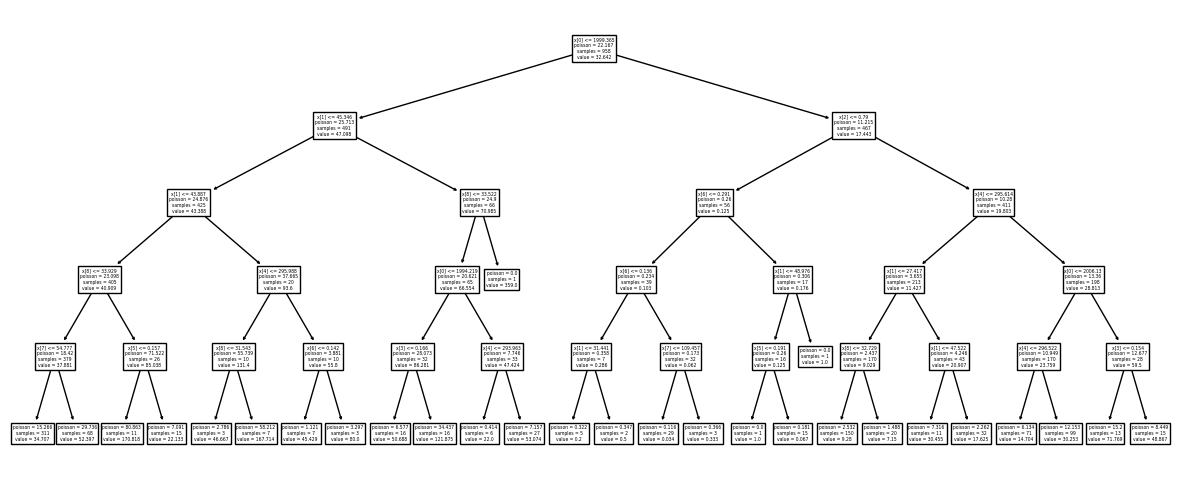

In [109]:
# tree_model(train,test,criterion_select='poisson',splitter_select='best',depth=None,min_split=2,min_leaf=1)
tree_best_model = tree_model(train_subtrain_selec_noNorm,train_subtest_selec_noNorm,splitter_select='random',depth=5,min_split=2, min_leaf=1)

### Resultados

* San Juan: 18.03
* Iquitos: 8.67
* Dataset conjunto: 8.54

El error (MAE) ha mejorado considerablemente en comparación a la parametrización del árbol de decisión sin *GridSearchCV*. Para intentar mejorar las predicciones se va a emplear *Random Forest*.

Cabe señalar que en los gráficos se puede apreciar cómo se obtienen mejores resultados al separar los dataset por ciudad.

### DRIVEN DATA score

In [110]:
# Predicciones test
sj_tree_predictions = sj_tree_best_model.predict(X=sj_test_selec_noNorm)
iq_tree_predictions = iq_tree_best_model.predict(X=iq_test_selec_noNorm)

In [111]:
# Redondear el resultado y convertirlo a entero

# San Juan
sj_tree_pred = np.rint(sj_tree_predictions) # round
sj_tree_pred = sj_tree_pred.astype(int) # cast to int
sj_tree_res = np.hstack(sj_tree_pred) #aplilamiento horizontal

# Iquitos
iq_tree_pred = np.rint(iq_tree_predictions) # round
iq_tree_pred = iq_tree_pred.astype(int) # cast to int
iq_tree_res = np.hstack(iq_tree_pred) #aplilamiento horizontal

tree_res = np.concatenate([sj_tree_res, iq_tree_res])

In [112]:
#download_predictions(test_noNorm_descarga,tree_res)

## Random Forest

Random Forest es un algoritmo de aprendizaje automático que combina múltiples árboles de decisión para realizar predicciones o clasificaciones. Cada árbol en el bosque se entrena con una muestra aleatoria de datos y utiliza diferentes características para tomar decisiones. Luego, las predicciones de todos los árboles se combinan para obtener un resultado final más preciso y estable.

Tras realizar la optimización de hiperparámetros del árbol de decisión mediante *grid search* se han obtenido los siguientes resultados (utilizando los dataset con las características selecionadas).

* **San Juan:** {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
* **Iquitos:** Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}

Una vez obtenidos los hiperparámetros óptimos, se va a impelentar el algoritmo *Random Foresst* para mejorar la generalizabilidad y robustez respecto al estimador único.

Los parámetros a considerar son:
* **n_estimators:** Representa el número de árboles que se genera en el bosque aleatorio. Cuantos más árboles, mejor va a ser el rendimiento; sin embargo, el tiempo de entrenamiento y predicción también va a aumentar.
* **max_features:** Representa el tamaño de los subconjuntos aleatorios de características a considerar al dividir un nodo. Cuanto menor sea el número (>1) mayot será la reducción de la varianza, pero también el sesgo. CUando se establece a 1.0, se consideran todas las características en cada división del nodo.

Para establecer el valor de *'n_estimators'* se va a iterar sobre las potencias de 2.

### Funciones

#### Parametrización

In [113]:
from sklearn.ensemble import RandomForestRegressor

def get_best_model_forest(train, criterion_select='poisson',depth=None,min_split=2,min_leaf=1):

  # Instancia de la clase TimeSeriesSplit con 10 subconjuntos
  cv = TimeSeriesSplit(n_splits = 10)

  # Validación cruzada: Encontrar los mejores hiperparámetros

  # Hiperparámetros A que se van a validar: n_estimators = The number of trees in the forest.
  l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

  total_scores = []
  for estimator in l_estimators:
    fold_accuracy = []
    # Intancia de RandomForestRegresor
    regressor_forest =  RandomForestRegressor(n_estimators=estimator,
                                              criterion=criterion_select,
                                              max_depth=depth,
                                              min_samples_split=min_split,
                                              min_samples_leaf=min_leaf,
                                              random_state=0)

    for train_fold, test_fold in cv.split(train):
        # División train test aleatoria
        f_train = train.loc[train_fold]
        f_test = train.loc[test_fold]

        # Entrenamiento del modelo
        regressor_forest.fit( X = f_train.drop(['total_cases'], axis=1),
                             y = f_train['total_cases'])
        y_pred = regressor_forest.predict(X = f_test.drop(['total_cases'], axis = 1))

        # Evaluación del modelo
        mae = mean_absolute_error(f_test['total_cases'], y_pred)
        fold_accuracy.append(mae)

    total_scores.append(sum(fold_accuracy)/len(fold_accuracy)) #Se normaliza el resultado y se guarda el resultado promedio de la Validación Cruzada


  plt.plot(l_estimators, total_scores, marker='o')
  plt.ylabel('MAE')
  plt.show()


  best_mae = float('inf')
  best_est = None

  for i, mae in enumerate(total_scores):
    if mae < best_mae and mae > 7.4 and l_estimators[i] < 800: # Condiciones para poder obtener best_est
      best_mae = mae
      best_est = l_estimators[i]

  print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))



#### Construcción y ejecución del modelo

In [114]:
def forest_model(train,test,estimator=100,criterion_select='poisson',depth=None,min_split=2,min_leaf=1):

  #Constructor
  regressor_forest =  RandomForestRegressor(n_estimators=estimator,
                                          criterion=criterion_select,
                                          max_depth=depth,
                                          min_samples_split=min_split,
                                          min_samples_leaf=min_leaf,
                                          random_state=0)
  # fit and predict
  fitted_model = regressor_forest.fit( X = train.drop(['total_cases'], axis=1), y = train['total_cases'])
  y_pred = regressor_forest.predict(X = test.drop(['total_cases'], axis = 1))
  mae = mean_absolute_error(test['total_cases'], y_pred)
  print ('MAE', mae)

  # x axis for plotting
  plt.figure(figsize=(15, 6))
  xx = np.stack(i for i in range(test['total_cases'].shape[0]))
  plt.plot(xx, test['total_cases'], c='r', label='data')
  #plt.plot(xx, y, c='k', label='data')
  plt.plot(xx, y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  plt.title("DecissionTreeRegressor (n_estimators = %i, max_depth = %i, min_samples_split = %i, min_samples_leaf= = %i)" % (estimator, depth, min_split, min_leaf))
  plt.show()

  return fitted_model


### San Juan

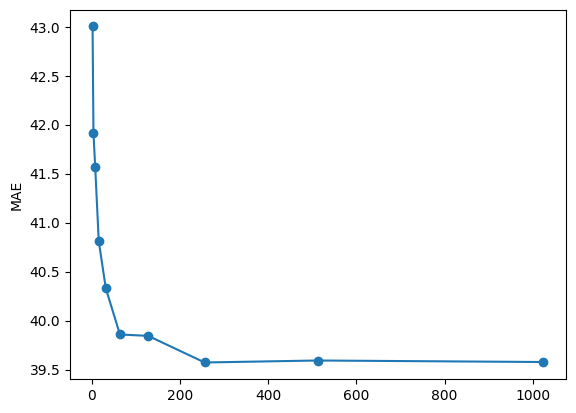

Min Value (estimators = 256, MAE =  39.57)


In [115]:
#: San Juan:  {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
get_best_model_forest(sj_train_subtrain_selec_noNorm, criterion_select='poisson',depth=5,min_split=2,min_leaf=10)

MAE 19.886960010314112


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


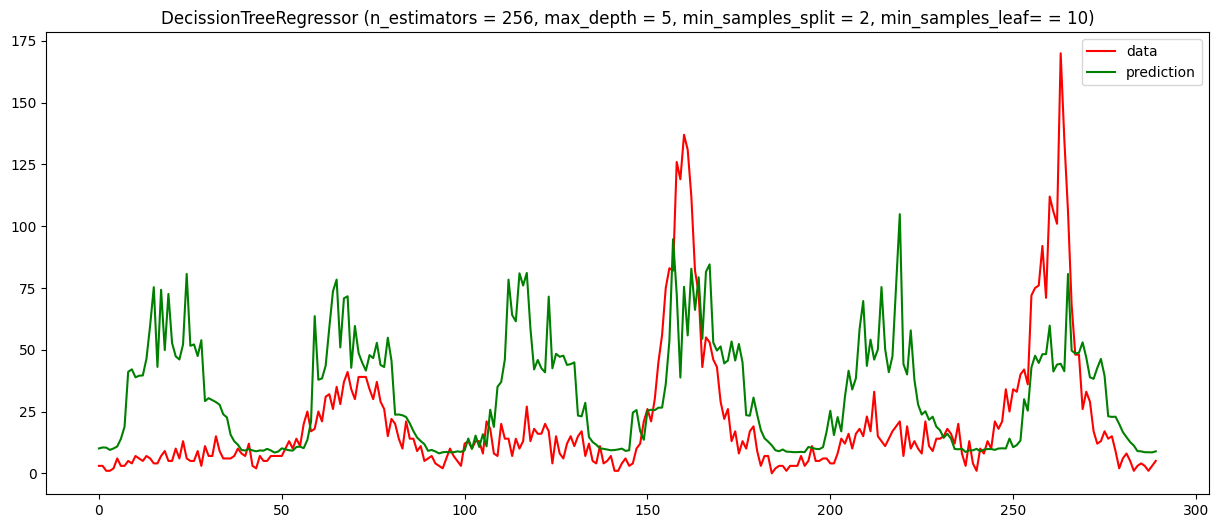

In [116]:
sj_forest_best_model = forest_model(sj_train_subtrain_selec_noNorm,sj_train_subtest_selec_noNorm,256,criterion_select='poisson',depth=5,min_split=2,min_leaf=10)

### Iquitos

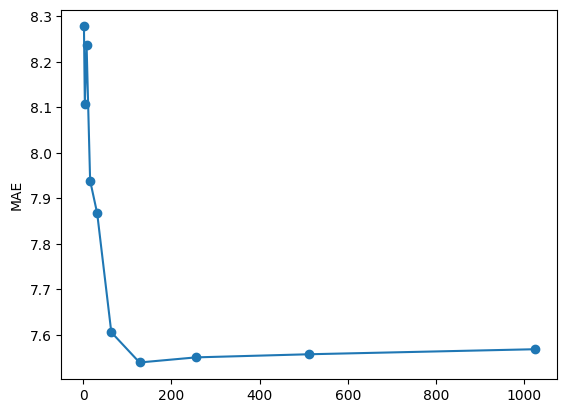

Min Value (estimators = 128, MAE =   7.54)


In [117]:
# Iquitos: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
get_best_model_forest(iq_train_subtrain_selec_noNorm, criterion_select='poisson',depth=15,min_split=3,min_leaf=1)

MAE 7.518028746288803


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


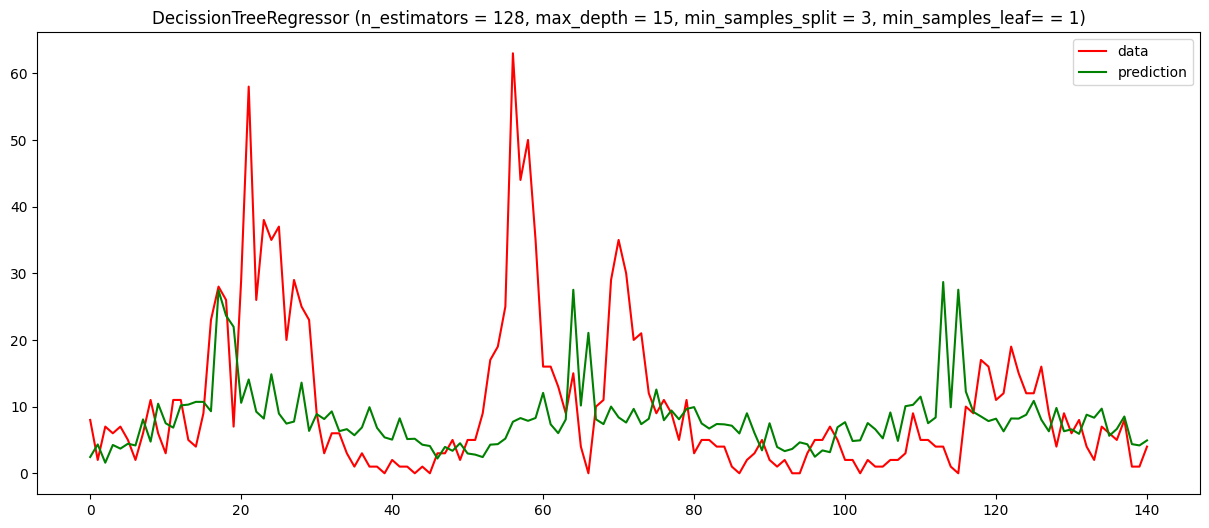

In [118]:
iq_forest_best_model = forest_model(iq_train_subtrain_selec_noNorm,iq_train_subtest_selec_noNorm,128,criterion_select='poisson',depth=15,min_split=3,min_leaf=1)

Al emplear Random Forest, los resultados (MAE) son los siguientes:
* San Juan: 19.89
* Iquitos: 7.52

En comparación con el Árbol de decisión, el error en Iquitos se ha reducido ligeramente, y en San Juan ha aumentado ligeramente; pero el beneficio no es notorio.

### DRIVEN DATA score

In [119]:
# Predicciones test
sj_forest_predictions = sj_forest_best_model.predict(X=sj_test_selec_noNorm)
iq_forest_predictions = iq_forest_best_model.predict(X=iq_test_selec_noNorm)

In [120]:
# Redondear el resultado y convertirlo a entero

# San Juan
sj_forest_pred = np.rint(sj_forest_predictions) # round
sj_forest_pred = sj_forest_pred.astype(int) # cast to int
sj_forest_res = np.hstack(sj_forest_pred) #aplilamiento horizontal

# Iquitos
iq_forest_pred = np.rint(iq_forest_predictions) # round
iq_forest_pred = iq_forest_pred.astype(int) # cast to int
iq_forest_res = np.hstack(iq_forest_pred) #aplilamiento horizontal

forest_res = np.concatenate([sj_forest_res, iq_forest_res])

In [121]:
#download_predictions(test_noNorm_descarga,forest_res)

## Regresión lineal múltiple

La regresión lineal múltiple es un método de análisis estadístico utilizado para predecir o modelar la relación entre una variable dependiente y múltiples variables independientes. Se basa en la suposición de que existe una relación lineal entre la variable dependiente y las variables independientes. El objetivo de la regresión lineal múltiple es encontrar la mejor línea o plano de ajuste que minimice la diferencia entre los valores observados y los valores predichos por el modelo. Esto se logra mediante el cálculo de los coeficientes de regresión que representan las contribuciones de las variables independientes al modelo.

### Regularización

La regularización se basa en el ajuste del modelo incluyendo todos los predictores, pero se aplicará una penalización para forzar que las estimaciones de los coeficientes de regresión puedan tender a cero; así se evita el overfitting, se reducirá la varianza, se atenuará el efecto de la correlación entre predictores y se minimizará la influencia en el modelo de los predictores que tengan menos relevancia. De forma general, se puede decir que al aplicar la regularización se conseguirán modelos que tendrán un poder predictivo mayor.

Debido a que esta regularización va a actuar sobre las magnitudes de los coeficientes del modelo, deberán estar todos en la misma escala. Por eso, es importante normalizar o estandarizar los predictores antes de entrenar el modelo. Los modelos van a estar indicados especialmente en situaciones para las que haya un número mayor de predictores que de observaciones.

* **Ridge:** La regularización Ridge penalizará la suma de los coeficientes que están elevados al cuadrado. A dicha penalización se le denomina I2 y tendrá el efecto de la reducción, de manera proporcional, del valor de todos los coeficientes del modelo, pero nunca llegando a cero.

* **Lasso:** La regularización Lasso va a penalizar la suma de los valores absolutos de los coeficientes de regresión. A dicha penalización se le denomina I1 y tendrá el efecto de obligar a los coeficientes de los predictores a tender a cero. Como un predictor cuyo coeficiente de regresión igual a cero no va a influir en el modelo, con Lasso se consiguen eliminar los predictores que tengan menor relevancia.

### Clases de Scikit-learn

* **linear_model.LinearRegression(*[, ...]):** Ordinary least squares Linear Regression.

* **linear_model.Ridge([alpha, fit_intercept, ...]):** Linear least squares with l2 regularization.

* **linear_model.RidgeCV([alphas, ...]):** Ridge regression with built-in cross-validation.

* **linear_model.SGDRegressor([loss, penalty, ...]):** Linear model fitted by minimizing a regularized empirical loss with SGD.

* **linear_model.Lasso([alpha, fit_intercept, ...]):** Linear Model trained with L1 prior as regularizer (aka the Lasso).

* **linear_model.LassoCV(*[, eps, n_alphas, ...]):** Lasso linear model with iterative fitting along a regularization path.

#### Explicación

linear_model.LinearRegression: Esta clase implementa el modelo de regresión lineal utilizando el método de los mínimos cuadrados ordinarios. Es un modelo de regresión lineal clásico que ajusta una línea recta a los datos de entrada para predecir un valor continuo de salida.

linear_model.Ridge: Esta clase también implementa un modelo de regresión lineal, pero utiliza regularización L2 (Ridge) para controlar la complejidad del modelo y evitar el sobreajuste. La regularización L2 agrega una penalización proporcional al cuadrado de los coeficientes, lo que ayuda a reducir la magnitud de los coeficientes y, por lo tanto, controlar la complejidad del modelo.

linear_model.RidgeCV: Similar a la clase Ridge, pero con la ventaja adicional de tener incorporada la validación cruzada para seleccionar automáticamente el mejor valor de hiperparámetro alpha (el factor de regularización) utilizando la métrica de rendimiento especificada.

linear_model.SGDRegressor: Esta clase implementa un modelo de regresión lineal utilizando el método del descenso de gradiente estocástico (SGD). El modelo se ajusta minimizando una función de pérdida empírica regularizada utilizando SGD. Es útil cuando se tienen conjuntos de datos grandes, ya que el descenso de gradiente estocástico permite realizar actualizaciones de los coeficientes en línea, en lugar de utilizar la matriz completa de características.

linear_model.Lasso: Esta clase implementa el modelo de regresión lineal con regularización L1 (Lasso). A diferencia de la regularización L2, la regularización L1 agrega una penalización proporcional al valor absoluto de los coeficientes. Esto permite que algunos coeficientes se vuelvan exactamente cero, lo que conduce a la selección automática de características y a la interpretabilidad del modelo.

linear_model.LassoCV: Similar a la clase Lasso, pero con la funcionalidad adicional de realizar ajustes iterativos a lo largo de una ruta de regularización. También utiliza validación cruzada para seleccionar automáticamente el mejor valor de hiperparámetro alpha (el factor de regularización) utilizando la métrica de rendimiento especificada.

Tras realizar un análisis de los diferentes modelos posibles para realizar la Regresión Lineal, se realizará con la **Regulación de Lasso**. De esta manera, se evitará el sobreajuste y se minimizará la influencia de los predictores que tengan menos relevancia. Además, se realizará una selección de predictores.

Del mismo modo, se va a utilizar **'linear_model.LassoCV'** para incorporar la validación cruzada integrada del hiperparámetro alpha (factor de regularización).

También se va a utilizar la **Regularización de Ridge** para tener un enfoque con todas las características seleccionadas en un primer momento.

#### NOTAS: LassoCV

LassoCV conduce a resultados diferentes que una búsqueda de hiperparámetros utilizando GridSearchCV con un modelo Lasso. En LassoCV, un modelo para una penalización alfa dada se inicia en caliente utilizando los coeficientes del modelo más cercano (entrenado en la iteración anterior) en la ruta de regularización. Esto tiende a acelerar la búsqueda de hiperparámetros.

### Lasso - Parametrización, construcción y ejecución del modelo

In [122]:
from sklearn.linear_model  import LassoCV # Lasso linear model with iterative fitting along a regularization path.

def get_best_model_linear_lasso(train, test, var_objetivo):

  # Resetear el índice del DataFrame
  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)

  # Datos de entrenamiento y prueba
  X_train = train.drop(var_objetivo, axis=1)
  y_train = train[var_objetivo]
  X_test = test.drop(var_objetivo, axis=1)
  y_test = test[var_objetivo]

  # Instancia de LassoCV
  lasso_cv = LassoCV (cv=10, random_state = 0)

  # Ajustar el modelo con los datos de entrenamiento
  fitted_model = lasso_cv.fit(X_train, y_train)

  # Obtener los coeficientes y el parámetro de regularización seleccionado
  coeficientes = lasso_cv.coef_
  alpha = lasso_cv.alpha_
  #print("Coeficientes:", coef)
  print("Alpha:", alpha)

  # Obtener los nombres de las características
  caracteristicas = train.drop(['total_cases'], axis=1).columns.tolist()

  # Imprimir características y coeficientes
  for carac, coef in zip(caracteristicas, coeficientes):
      print(f"Característica: {carac}, Coeficiente: {coef}")

  # Predecir en los datos de prueba
  y_pred = lasso_cv.predict(X_test)

  # Calcular el error absoluto medio
  mae = mean_absolute_error(y_test, y_pred)
  print("Error absoluto medio: ", mae)

  # x axis for plotting
  plt.figure(figsize=(15, 6))
  xx = np.stack(i for i in range(test['total_cases'].shape[0]))
  plt.plot(xx, test['total_cases'], c='r', label='data')
  #plt.plot(xx, y, c='k', label='data')
  plt.plot(xx, y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  # Filtrar características con coeficientes diferentes de cero
  caracteristicas_seleccionadas = [carac for carac, coef in zip(caracteristicas, coeficientes) if coef != 0]
  # Imprimir características seleccionadas en el título
  plt.title("LinearRegressor (characteristics = %s)" % (', '.join(caracteristicas_seleccionadas)))
  plt.show()

  return fitted_model

#### Lasso - San Juan

Alpha: 36.37533487520189
Característica: year, Coeficiente: -0.0
Característica: weekofyear, Coeficiente: 1.092361356022949
Característica: city_bin, Coeficiente: 0.0
Característica: ndvi_sw, Coeficiente: 0.0
Característica: reanalysis_dew_point_temp_k, Coeficiente: 0.0
Característica: ndvi_se, Coeficiente: -0.0
Característica: ndvi_nw, Coeficiente: -0.0
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: 0.0
Característica: station_max_temp_c, Coeficiente: 0.0
Error absoluto medio:  29.04031354952721


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


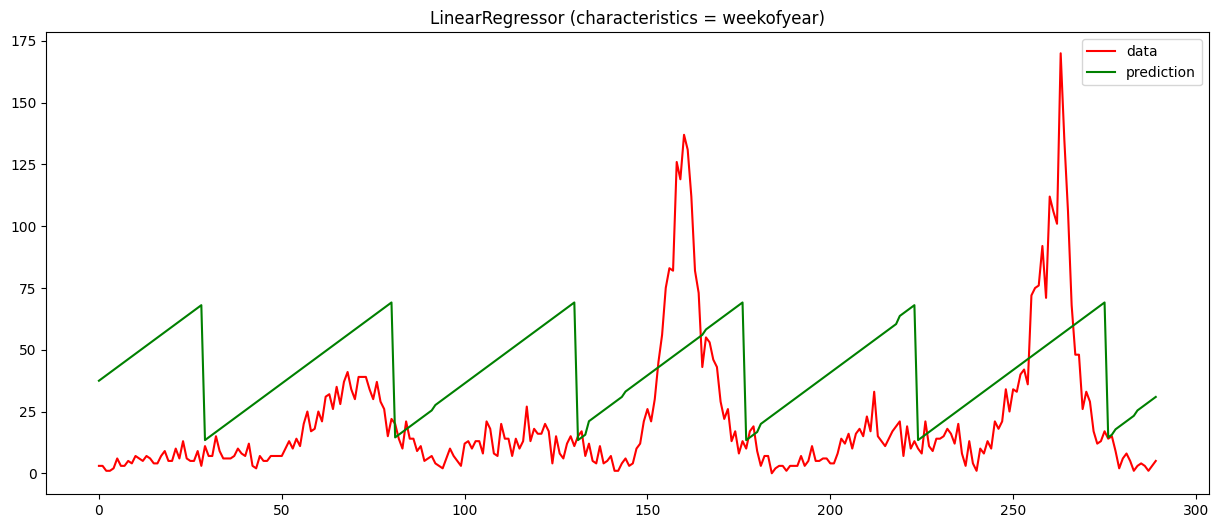

In [123]:
sj_lasso_best_model = get_best_model_linear_lasso(sj_train_subtrain_selec,sj_train_subtest_selec,'total_cases')

Alpha: 36.37533487520189
Característica: city_bin, Coeficiente: 0.0
Característica: year, Coeficiente: -0.0
Característica: weekofyear, Coeficiente: 1.092361356022949
Característica: ndvi_ne, Coeficiente: 0.0
Característica: ndvi_nw, Coeficiente: -0.0
Característica: ndvi_se, Coeficiente: -0.0
Característica: ndvi_sw, Coeficiente: 0.0
Característica: precipitation_amt_mm, Coeficiente: -0.0
Característica: reanalysis_air_temp_k, Coeficiente: 0.0
Característica: reanalysis_dew_point_temp_k, Coeficiente: 0.0
Característica: reanalysis_max_air_temp_k, Coeficiente: 0.0
Característica: reanalysis_min_air_temp_k, Coeficiente: 0.0
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: 0.0
Característica: reanalysis_relative_humidity_percent, Coeficiente: 0.0
Característica: station_avg_temp_c, Coeficiente: 0.0
Característica: station_diur_temp_rng_c, Coeficiente: 0.0
Característica: station_max_temp_c, Coeficiente: 0.0
Característica: station_min_temp_c, Coeficiente: 0.0
Característica:

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


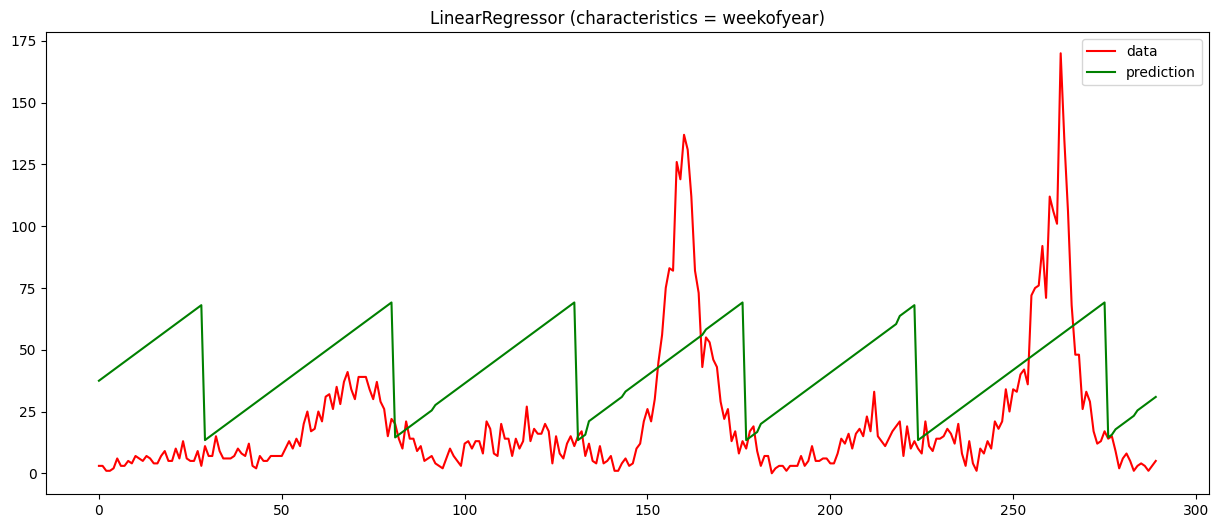

LassoCV(cv=10, random_state=0)

In [124]:
get_best_model_linear_lasso(sj_train_subtrain,sj_train_subtest,'total_cases')

En este caso, al tener únicamente dos características coeficientes diferentes de 0, la predicción es demasiado consistente y no se adapta a los casos reales.

#### Lasso - Iquitos

Alpha: 13.07514319526627
Característica: year, Coeficiente: 0.0
Característica: weekofyear, Coeficiente: 0.0
Característica: city_bin, Coeficiente: 0.0
Característica: ndvi_sw, Coeficiente: -0.0
Característica: reanalysis_dew_point_temp_k, Coeficiente: 0.0
Característica: ndvi_se, Coeficiente: -0.0
Característica: ndvi_nw, Coeficiente: -0.0
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: 0.0
Característica: station_max_temp_c, Coeficiente: 0.0
Error absoluto medio:  6.426794321558271


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


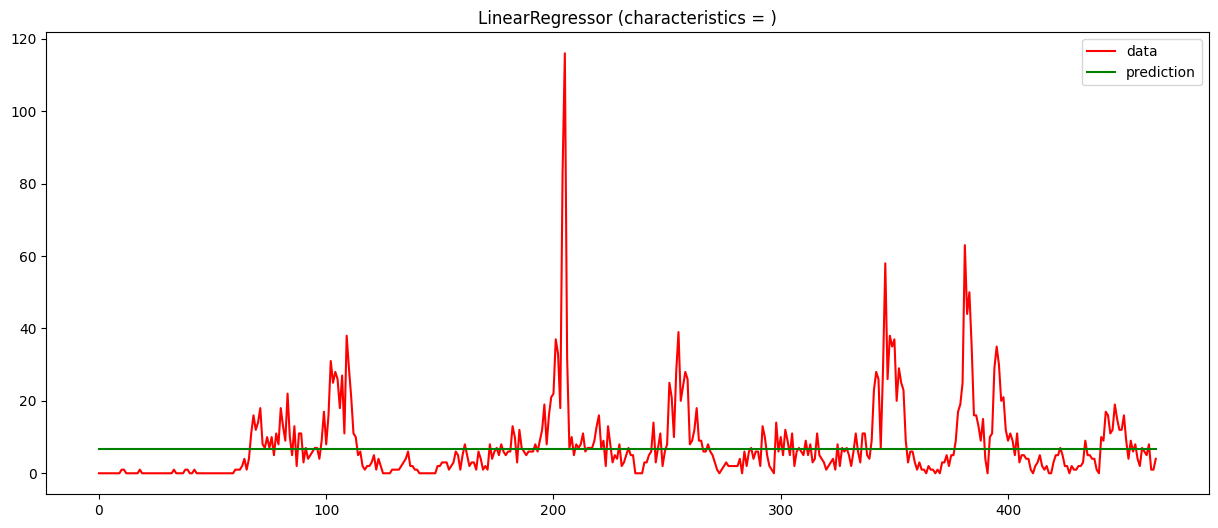

In [125]:
iq_lasso_best_model = get_best_model_linear_lasso(iq_train_subtrain_selec,iq_train_subtest_selec,'total_cases')

Alpha: 13.07514319526627
Característica: city_bin, Coeficiente: 0.0
Característica: year, Coeficiente: 0.0
Característica: weekofyear, Coeficiente: 0.0
Característica: ndvi_ne, Coeficiente: -0.0
Característica: ndvi_nw, Coeficiente: -0.0
Característica: ndvi_se, Coeficiente: -0.0
Característica: ndvi_sw, Coeficiente: -0.0
Característica: precipitation_amt_mm, Coeficiente: 0.0
Característica: reanalysis_air_temp_k, Coeficiente: 0.0
Característica: reanalysis_dew_point_temp_k, Coeficiente: 0.0
Característica: reanalysis_max_air_temp_k, Coeficiente: -0.0
Característica: reanalysis_min_air_temp_k, Coeficiente: 0.0
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: 0.0
Característica: reanalysis_relative_humidity_percent, Coeficiente: 0.0
Característica: station_avg_temp_c, Coeficiente: 0.0
Característica: station_diur_temp_rng_c, Coeficiente: -0.0
Característica: station_max_temp_c, Coeficiente: 0.0
Característica: station_min_temp_c, Coeficiente: 0.0
Característica: station_pre

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


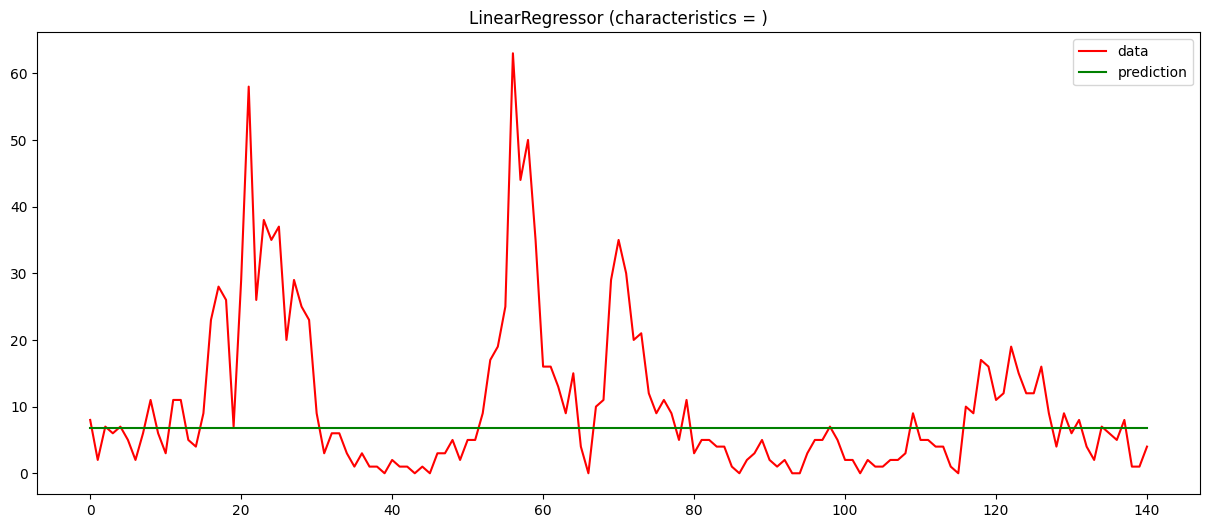

LassoCV(cv=10, random_state=0)

In [126]:
get_best_model_linear_lasso(iq_train_subtrain,iq_train_subtest,'total_cases')

La casuística de Iquitos es todavía peor, ya que todos los coeficientes son nulos. El modelo no es válido.

#### Lasso - Dataset conjunto

Alpha: 5.625639905516667
Característica: year, Coeficiente: -1.80230414202682
Característica: weekofyear, Coeficiente: 0.916813089635086
Característica: city_bin, Coeficiente: 0.0
Característica: ndvi_sw, Coeficiente: -0.0
Característica: reanalysis_dew_point_temp_k, Coeficiente: 0.0
Característica: ndvi_se, Coeficiente: -0.0
Característica: ndvi_nw, Coeficiente: -0.0
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: 0.0
Característica: station_max_temp_c, Coeficiente: 0.0
Error absoluto medio:  18.077436160919184


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


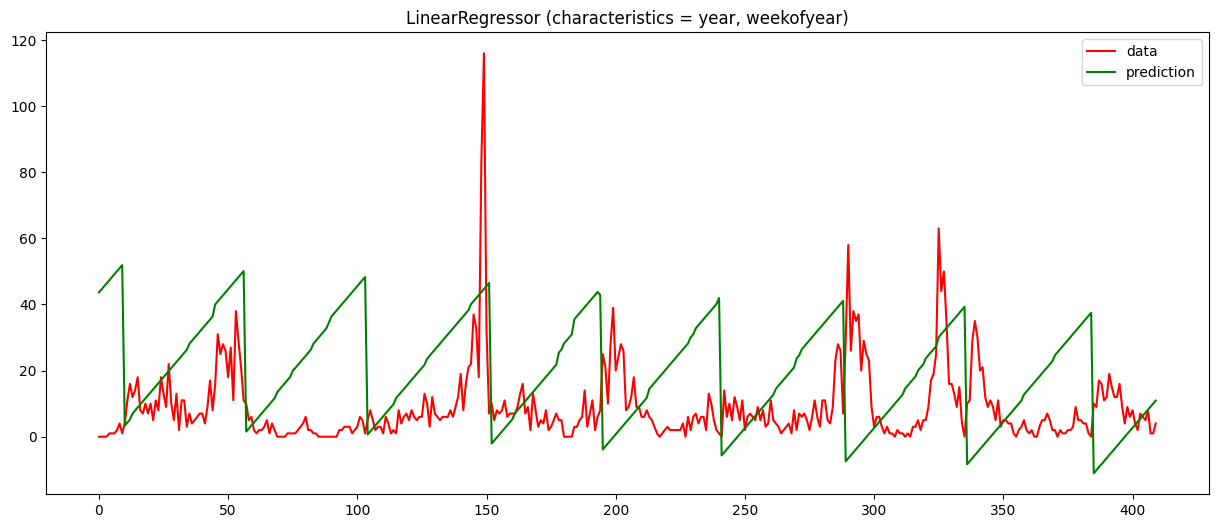

In [127]:
lasso_best_model = get_best_model_linear_lasso(train_subtrain_selec,train_subtest_selec,'total_cases')

Alpha: 6.032189273518773
Característica: city_bin, Coeficiente: 0.0
Característica: year, Coeficiente: -1.7867913547402334
Característica: weekofyear, Coeficiente: 0.9152661689976666
Característica: ndvi_ne, Coeficiente: -0.0
Característica: ndvi_nw, Coeficiente: -0.0
Característica: ndvi_se, Coeficiente: -0.0
Característica: ndvi_sw, Coeficiente: -0.0
Característica: precipitation_amt_mm, Coeficiente: -0.0
Característica: reanalysis_air_temp_k, Coeficiente: 0.0
Característica: reanalysis_dew_point_temp_k, Coeficiente: 0.0
Característica: reanalysis_max_air_temp_k, Coeficiente: -0.0
Característica: reanalysis_min_air_temp_k, Coeficiente: 0.0
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: 0.0
Característica: reanalysis_relative_humidity_percent, Coeficiente: -0.0
Característica: station_avg_temp_c, Coeficiente: 0.0
Característica: station_diur_temp_rng_c, Coeficiente: -0.0
Característica: station_max_temp_c, Coeficiente: 0.0
Característica: station_min_temp_c, Coeficiente

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


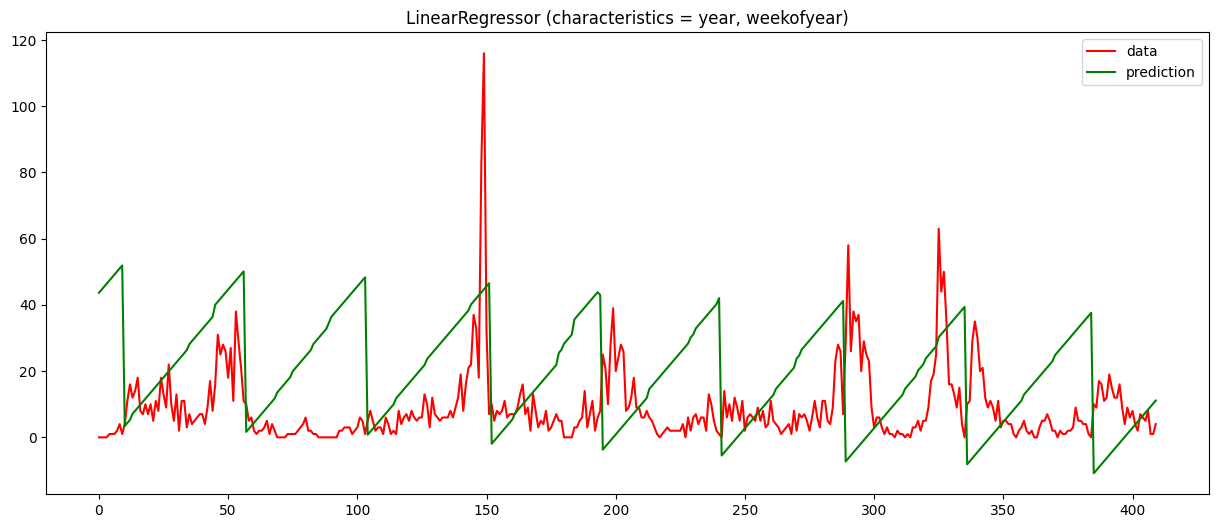

LassoCV(cv=10, random_state=0)

In [128]:
get_best_model_linear_lasso(train_subtrain,train_subtest,'total_cases')

### DRIVEN DATA score

In [129]:
# Predicciones test
sj_lasso_predictions = sj_lasso_best_model.predict(X=sj_test_selec)
iq_lasso_predictions = iq_lasso_best_model.predict(X=iq_test_selec)

In [130]:
# Redondear el resultado y convertirlo a entero

# San Juan
sj_lasso_pred = np.rint(sj_lasso_predictions) # round
sj_lasso_pred = sj_lasso_pred.astype(int) # cast to int
sj_lasso_res = np.hstack(sj_lasso_pred) #aplilamiento horizontal

# Iquitos
iq_lasso_pred = np.rint(iq_lasso_predictions) # round
iq_lasso_pred = iq_lasso_pred.astype(int) # cast to int
iq_lasso_res = np.hstack(iq_lasso_pred) #aplilamiento horizontal

lasso_res = np.concatenate([sj_lasso_res, iq_lasso_res])

In [131]:
#download_predictions(test_descarga,lasso_res)

### Ridge - Parametrización, construcción y ejecucicón del modelo

In [132]:
from sklearn.linear_model  import RidgeCV # Ridge regression with built-in cross-validation.

def get_best_model_linear_ridge(train, test, var_objetivo):

  # Resetear el índice del DataFrame
  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)

  # Datos de entrenamiento y prueba
  X_train = train.drop(var_objetivo, axis=1)
  y_train = train[var_objetivo]
  X_test = test.drop(var_objetivo, axis=1)
  y_test = test[var_objetivo]

  # Instancia de LassoCV
  ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10)

  # Ajustar el modelo con los datos de entrenamiento
  fitted_model = ridge_cv.fit(X_train, y_train)

  # Obtener los coeficientes y el parámetro de regularización seleccionado
  coeficientes = ridge_cv.coef_
  alpha = ridge_cv.alpha_
  print("Alpha:", alpha)

  # Obtener los nombres de las características
  caracteristicas = train.drop(['total_cases'], axis=1).columns.tolist()

  # Imprimir características y coeficientes
  for carac, coef in zip(caracteristicas, coeficientes):
      print(f"Característica: {carac}, Coeficiente: {coef}")

  # Predecir en los datos de prueba
  y_pred = ridge_cv.predict(X_test)

  # Calcular el error absoluto medio
  mae = mean_absolute_error(y_test, y_pred)
  print("Error absoluto medio: ", mae)

  # x axis for plotting
  plt.figure(figsize=(15, 6))
  xx = np.stack(i for i in range(test['total_cases'].shape[0]))
  plt.plot(xx, test['total_cases'], c='r', label='data')
  #plt.plot(xx, y, c='k', label='data')
  plt.plot(xx, y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  plt.title("LinearRegressor (characteristics = %s)" % (', '.join(caracteristicas)))
  plt.show()

  return fitted_model

#### Ridge - San Juan

Alpha: 100000.0
Característica: year, Coeficiente: -0.1258823768423047
Característica: weekofyear, Coeficiente: 0.7169218975355808
Característica: city_bin, Coeficiente: 0.0
Característica: ndvi_sw, Coeficiente: 0.017202084080671774
Característica: reanalysis_dew_point_temp_k, Coeficiente: 0.03751656994062673
Característica: ndvi_se, Coeficiente: -0.017978482767052783
Característica: ndvi_nw, Coeficiente: -0.021546366704048747
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: 0.0275477385258627
Característica: station_max_temp_c, Coeficiente: 0.03301693063208854
Error absoluto medio:  28.362438645072526


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


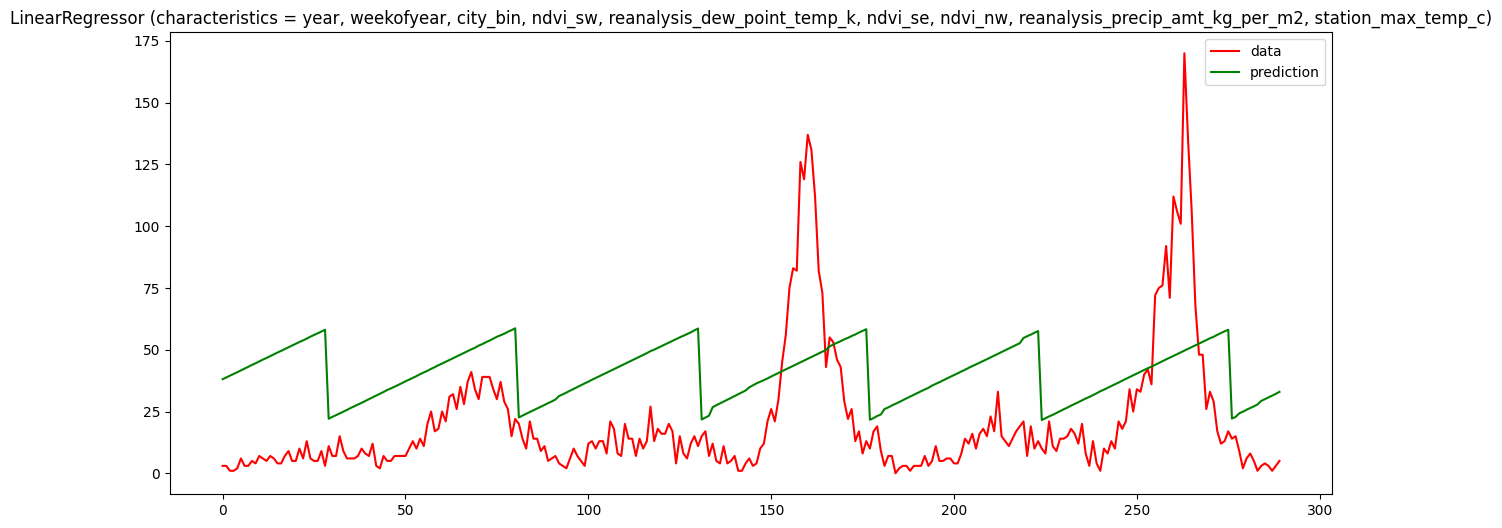

In [133]:
sj_ridge_best_model = get_best_model_linear_ridge(sj_train_subtrain_selec,sj_train_subtest_selec,'total_cases')

En el caso de la regeresión de Ridge nos encontramos con un caso similar a la regresión de Lasso, ya que los características con un coeficiente superior al 0.1 absoluto son únicamente 3: year, weekofyear y reanalysis_precip_amt_kg_per_m2.

#### Ridge - Iquitos

Alpha: 1e-06
Característica: year, Coeficiente: 0.6915453628467433
Característica: weekofyear, Coeficiente: 0.09743536732706615
Característica: city_bin, Coeficiente: 0.0
Característica: ndvi_sw, Coeficiente: 0.9575090579895099
Característica: reanalysis_dew_point_temp_k, Coeficiente: 3.0858482769928868
Característica: ndvi_se, Coeficiente: -1.2241052036184221
Característica: ndvi_nw, Coeficiente: -0.728442712121829
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: -0.8352768150605852
Característica: station_max_temp_c, Coeficiente: 0.07438301856380279
Error absoluto medio:  6.575422699674107


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


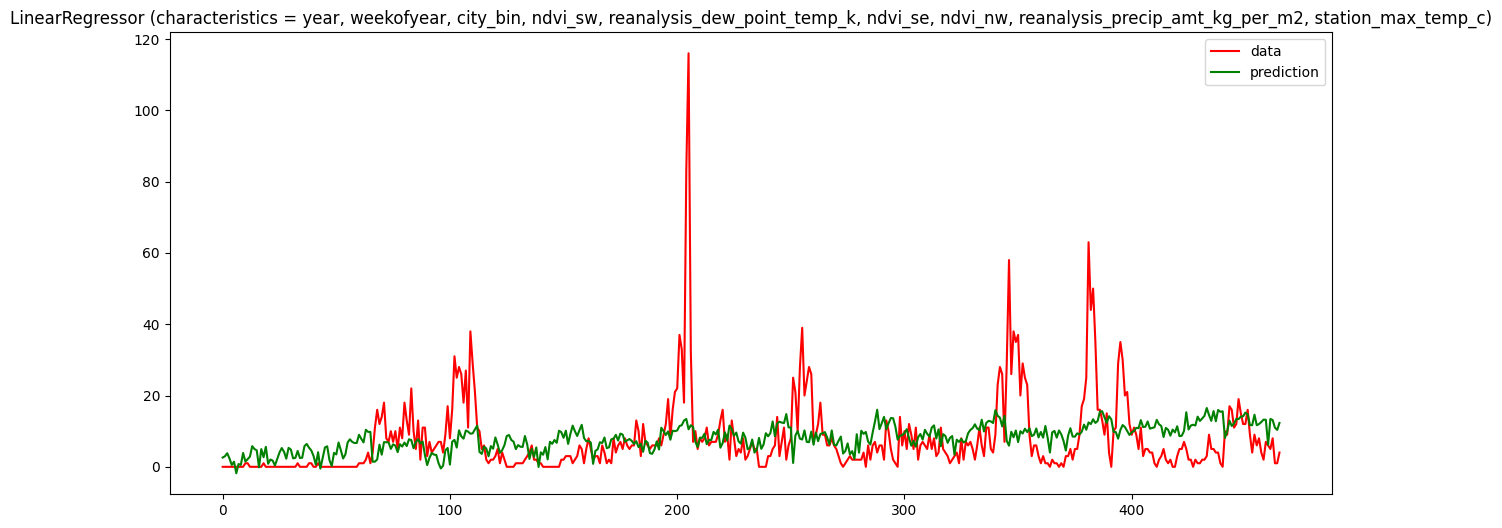

In [134]:
iq_ridge_best_model = get_best_model_linear_ridge(iq_train_subtrain_selec,iq_train_subtest_selec,'total_cases')

En cuanto a Iquitos, las predicciones si que se adaptan mejor a los casos reales, y el error es muy bajo. Sin embargo, los brotes (picos rojos) no se predicen correctamente.

Alpha: 100000.0
Característica: year, Coeficiente: -0.4092622542624527
Característica: weekofyear, Coeficiente: 0.6538951885480639
Característica: city_bin, Coeficiente: 0.017676347537745506
Característica: ndvi_sw, Coeficiente: -0.006016835200213732
Característica: reanalysis_dew_point_temp_k, Coeficiente: 0.053754202965035934
Característica: ndvi_se, Coeficiente: -0.037172304903156234
Característica: ndvi_nw, Coeficiente: -0.01766372725410332
Característica: reanalysis_precip_amt_kg_per_m2, Coeficiente: 0.028384201609428315
Característica: station_max_temp_c, Coeficiente: 0.02687428603283349
Error absoluto medio:  22.71734753405201


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


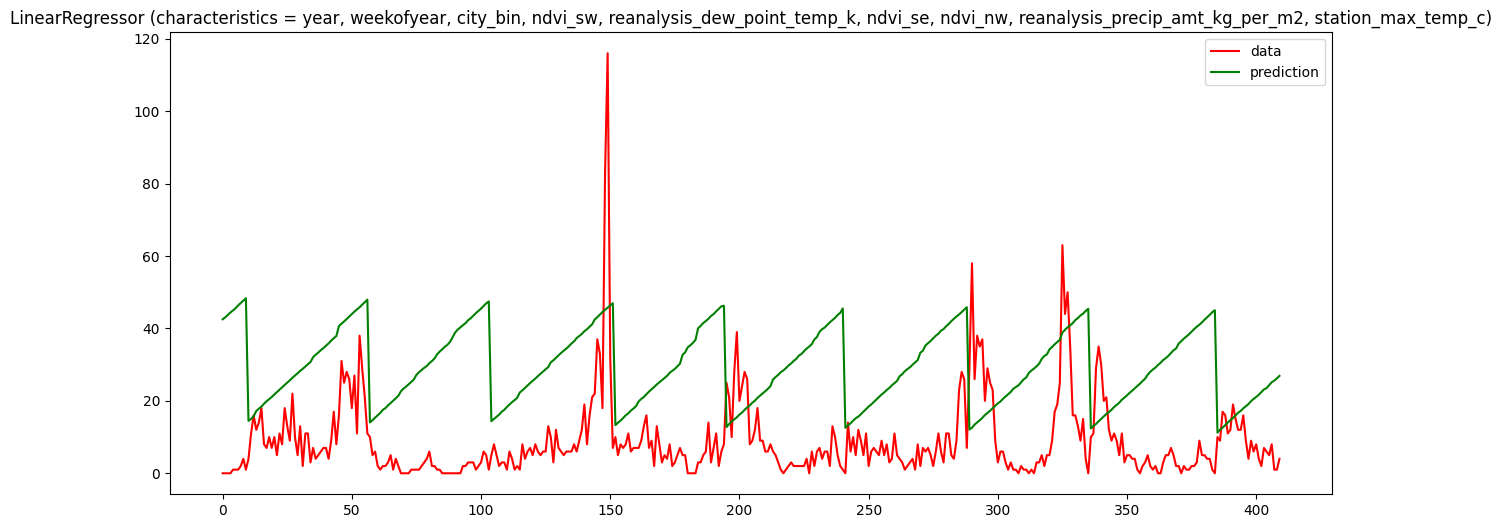

In [135]:
ridge_best_model = get_best_model_linear_ridge(train_subtrain_selec,train_subtest_selec,'total_cases')

### DRIVEN DATA score

In [136]:
# Predicciones test
sj_ridge_predictions = sj_ridge_best_model.predict(X=sj_test_selec)
iq_ridge_predictions = iq_ridge_best_model.predict(X=iq_test_selec)

In [137]:
# Redondear el resultado y convertirlo a entero

# San Juan
sj_ridge_pred = np.rint(sj_ridge_predictions) # round
sj_ridge_pred = sj_ridge_pred.astype(int) # cast to int
sj_ridge_res = np.hstack(sj_ridge_pred) #aplilamiento horizontal

# Iquitos
iq_ridge_pred = np.rint(iq_ridge_predictions) # round
iq_ridge_pred = iq_ridge_pred.astype(int) # cast to int
iq_ridge_res = np.hstack(iq_ridge_pred) #aplilamiento horizontal

ridge_res = np.concatenate([sj_ridge_res, iq_ridge_res])

In [138]:
#download_predictions(test_descarga,ridge_res)

---
# Conclusiones
---

A continuación, se muestra una tabla resumen con todos los modelos de la memoria:

| Modelo | MAE test (DrivenData) | MAE validación conjunto | MAE validación San Juan | MAE validación Iquitos | Algoritmo | Hiperparámetros conjunto | Hiperparámetros San Juan | Hiperparámetros Iquitos  | Características
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Final | 26,0120 | N/A | 19,8870 | 7,5180 | Random Forest | N/A | n_estimators=256; criterion='poisson'; max_depth=5; min_samples_split=2; min_samples_seaf=10 | n_estimators=128; criterion='poisson'; max_depth=15; min_samples_split=3; min_samples_seaf=1 | 'year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c'
| A | 32,7716 | 14,7160 | 21,5745 | 6,1606 | KNN | n_neighbors=55; weights='uniform' | n_neighbors=62; weights='uniform' | n_neighbors=35; weights='uniform' | 'year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c'
| B | 27,8101 | 8,5420 | 18,0315 | 8,6738 | Decision Tree & Grid Search | criterion: 'poisson', max_depth: 5, min_samples_leaf: 1, min_samples_split: 2, splitter: 'random' | criterion: 'poisson', max_depth: 5, min_samples_leaf: 10, min_samples_split: 2, splitter: 'best' | criterion: 'poisson', max_depth: 15, min_samples_leaf: 1, min_samples_split: 3, splitter: 'random' | 'year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c'
| C | 26,0120 | N/A | 19,8870 | 7,5180 | Random Forest | N/A | n_estimators=256; criterion='poisson'; max_depth=5; min_samples_split=2; min_samples_seaf=10 | n_estimators=128; criterion='poisson'; max_depth=15; min_samples_split=3; min_samples_seaf=1 | 'year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c'
| D | 28,1106 | 18,0774  | 29,0403 | 6,4268 | Linear Regression - Lasso | alpha=5,6256 | alpha=36,3753 | alpha=13,0751 | 'year', 'weekofyear'
| E | 28,4976 | 22,7173 | 28,3624 | 6,5754 | Linear Regression - Ridge | alpha=100000,0 | alpha=100000,0 | alpha=1e-6 | 'year', 'weekofyear', 'city_bin', 'ndvi_sw', 'reanalysis_dew_point_temp_k', 'ndvi_se', 'ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'station_max_temp_c'


## Análisis de los resultados obtenidos

Tras realizar en entrenamiento, la parametrización y la evaluación de cada uno de los modelos con las características seleccionadas, se ha seleccionado el modelo con el que mejor puntuación se ha obtenido en DrivenData.

Para realizar la evaluación del modelo, tal y como se ha explicado en el apartado correspondiente, se ha utilizado el error absoluto medio (MAE). Esta métrica se utiliza en problemas de regresión y sirve para cuantificar la precisión de una técnica de predicción comparando por ejemplo los valores predichos frente a los observados.

El MAE más es de 26,0120 y se ha obtenido con el modelo Random Forest. Tras parametrizar el modelo, estos han sido los paramámetros escogidos:
* San Juan
  * n_estimators=256
  * criterion='poisson'
  * max_depth=5
  * min_samples_split=2
  * min_samples_seaf=10
* Iquitos
	* n_estimators=128
  * criterion='poisson'
  * max_depth=15
  * min_samples_split=3
  * min_samples_seaf=1

Por otro lado, también se ha realizado una selección de características mediante *'RandomForestRegressor'*. Con este algoritmo se ha obtenido una medida de importancia de características.

## Análisis de los gráficos obtenidos

Por último, vamos a analizar los gráficos obtenidos en el modelo Random Forest, ya que es el modelo elegido para la actividad. Los gráficos son herramientas muy útiles para saber dónde radican los fallos del modelo y que cambios podríamos realizar para mejorar el rendimiento de éste.

En cuanto a la estacionalidad, se puede observar que el modelo predictivo (verde) sigue el patrón de la estacionalidad del Denge (datos reales, rojo); no obstante, en algunos casos no coincide con los datos reales, ya que está ligeramente desfasado. Existen varias razones que pueden la casusa de este problema. Una explicación válida y muy relevante para el desfase observado entre los datos predichos y los datos reales puede ser el ciclo de vida del mosquito y el tiempo transcurrido entre la infección y la aparición de los síntomas. Si las características utilizadas en el modelo solo se centran en las condiciones actuales (p.ej. humedad, temperatura o precipitaciones en el momento de la medición). es posible que no estén capturando adecuadamente la influencia del ciclo de vida del mosquito y el retraso entre la infección y la manifestación de los síntomas. Para mejorar el modelo, es necesario explorar características que abarquen un período más amplio en el pasado, permitiendo capturar mejor los efectos acumulativos y los retrasos asociados con la propagación del dengue. Por ejemplo, podrían considerarse características que reflejen la presencia de agua estancada durante un período prolongado, lo cual es relevante para el ciclo de vida del mosquito.

El otro error en las prediccones realizadas es que se están pasando por alto los picos que constituyen grandes brotes. Los grandes brotes suelen estar relacionados con la contagiosidad del dengue. Por lo tanto, una posible mejora sería construir un modelo que prediga un nuevo valor teniendo en cuenta la predicción anterior.

Por lo demás, observando los gráficos, se han conseguido modelos bastante precisos.

---
# Competición
---

Mi nombre de usuario en DrivenData es el siguiente: **Nunez** (mi perfil se muestra en la segunda imagen).

In [139]:
from google.colab import files

# Pide al usuario que seleccione el archivo de imagen
uploaded = files.upload()

# Obtiene el nombre del archivo cargado
drivenData = next(iter(uploaded))

# Muestra el nombre del archivo cargado
print("Archivo cargado:", drivenData)


Saving Malena Nunez Martinez - Driven Data Score.png to Malena Nunez Martinez - Driven Data Score.png
Archivo cargado: Malena Nunez Martinez - Driven Data Score.png


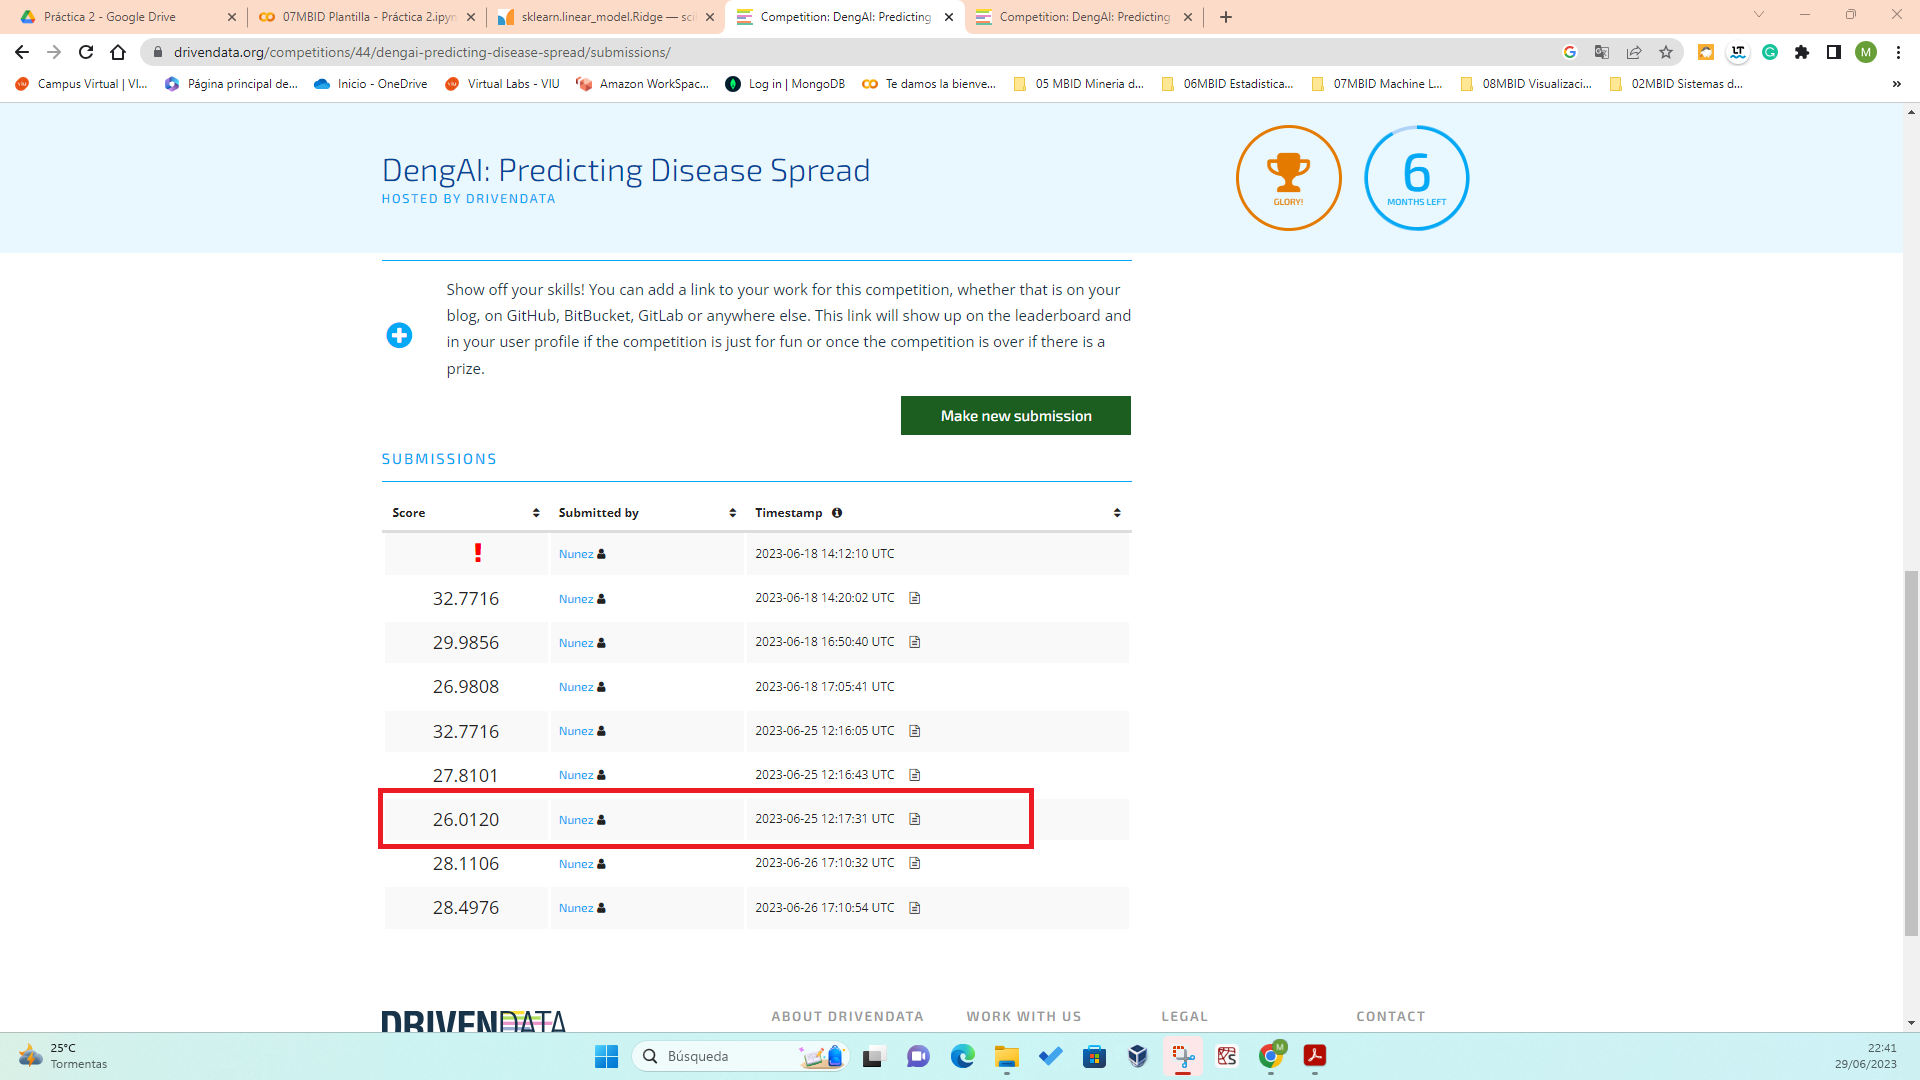

In [140]:
from PIL import Image
import io

# Lee la imagen cargada
image = Image.open(io.BytesIO(uploaded[drivenData]))

# Muestra la imagen
image.show()


In [141]:
# Pide al usuario que seleccione el archivo de imagen
uploaded = files.upload()

# Obtiene el nombre del archivo cargado
user = next(iter(uploaded))

# Muestra el nombre del archivo cargado
print("Archivo cargado:", user)


Saving Malena Nunez Martinez - user.png to Malena Nunez Martinez - user.png
Archivo cargado: Malena Nunez Martinez - user.png


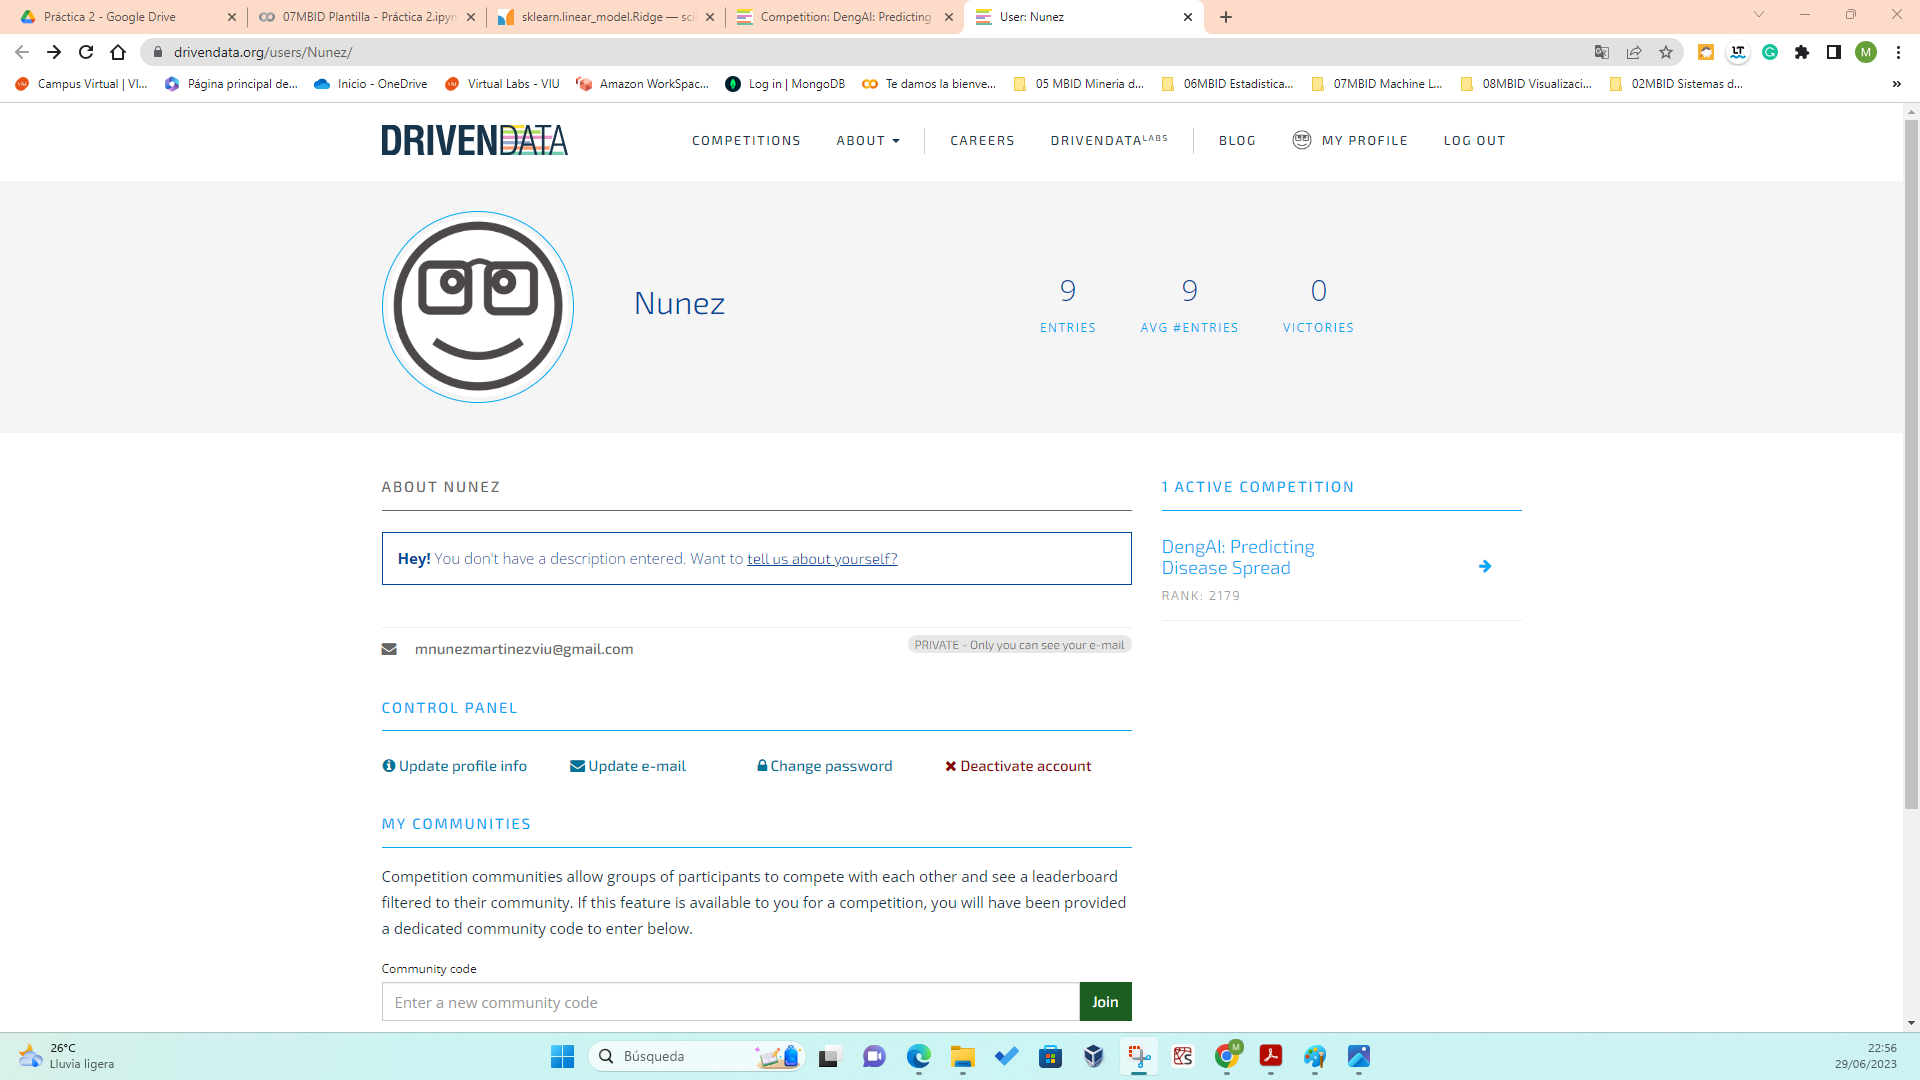

In [142]:
# Lee la imagen cargada
image = Image.open(io.BytesIO(uploaded[user]))

# Muestra la imagen
image.show()
